In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import os
import torch.optim as optim
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)


In [44]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [45]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp1/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [46]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Training on bin 1/50
Bin 1, Epoch 1/4000, Train Loss: 0.6747, Validation Loss: 0.6874,  Accuracy: 0.7825, LR: 0.000010
Bin 1, Epoch 101/4000, Train Loss: 0.6049, Validation Loss: 0.6730,  Accuracy: 0.7797, LR: 0.000010
Bin 1, Epoch 201/4000, Train Loss: 0.5610, Validation Loss: 0.6365,  Accuracy: 0.8220, LR: 0.000010
Bin 1, Epoch 301/4000, Train Loss: 0.5096, Validation Loss: 0.5809,  Accuracy: 0.8475, LR: 0.000010
Bin 1, Epoch 401/4000, Train Loss: 0.4678, Validation Loss: 0.5461,  Accuracy: 0.8475, LR: 0.000010
Bin 1, Epoch 501/4000, Train Loss: 0.4424, Validation Loss: 0.5509,  Accuracy: 0.8362, LR: 0.000010
Bin 1, Epoch 601/4000, Train Loss: 0.4080, Validation Loss: 0.4585,  Accuracy: 0.8814, LR: 0.000010
Bin 1, Epoch 701/4000, Train Loss: 0.3776, Validation Loss: 0.4918,  Accuracy: 0.8531, LR: 0.000010
Bin 1, Epoch 801/4000, Train Loss: 0.3698, Validation Loss: 0.5190,  Accuracy: 0.8362, LR: 0.000009
Bin 1, Epoch 901/4000, Train Loss: 0.3549, Validation Loss: 0.4873,  Accuracy: 0.

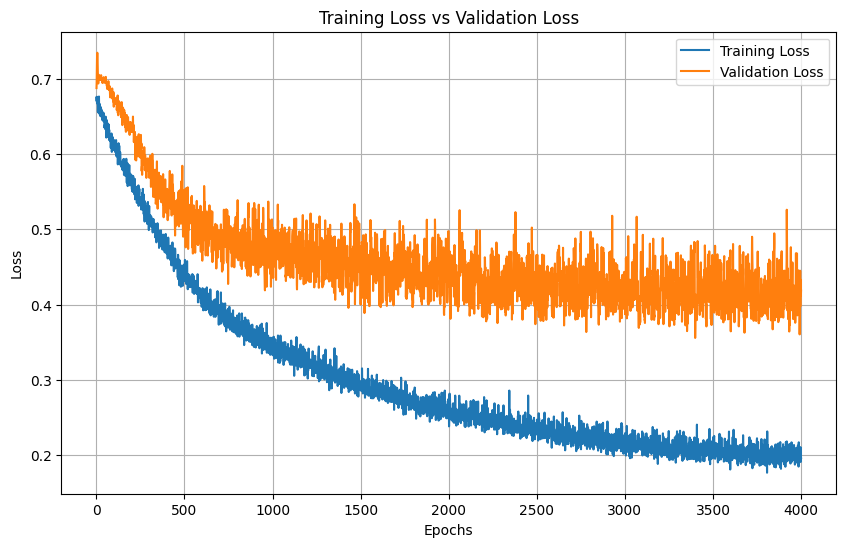

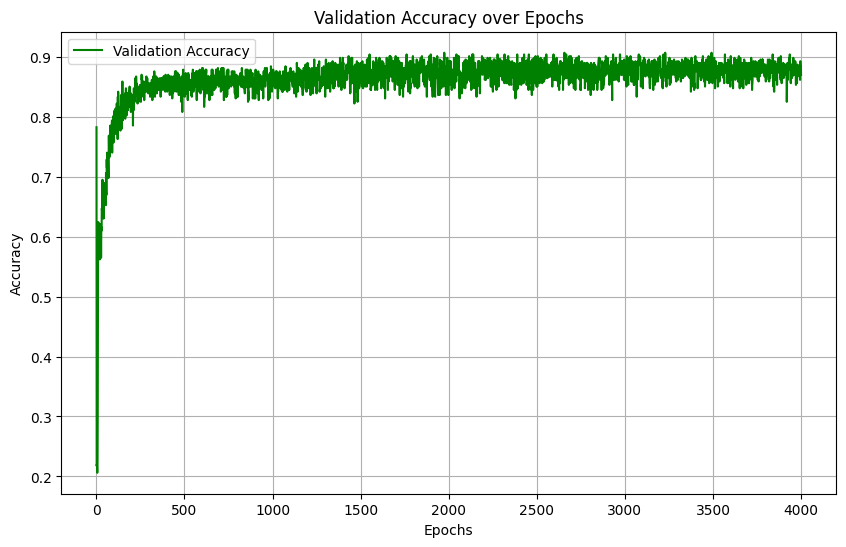

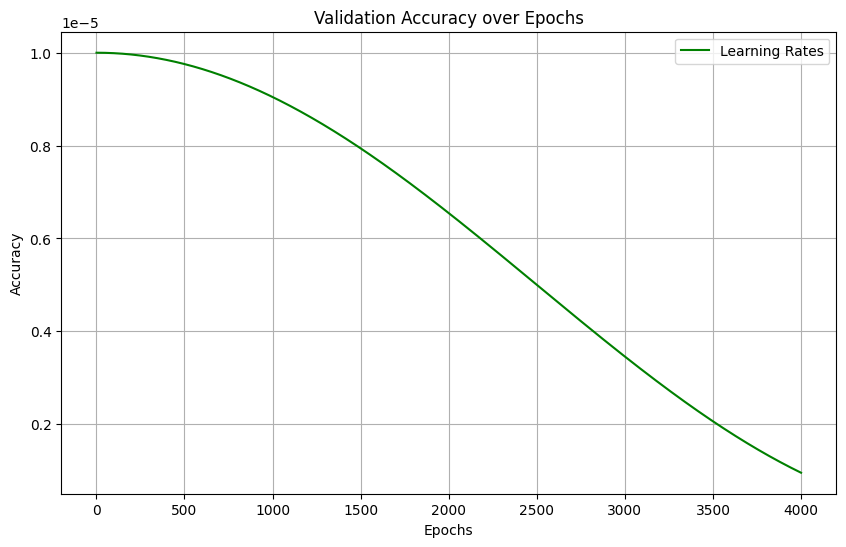

Model for bin 1 saved to GCNModels-5A_exp1/model_bin_1.pth
Training on bin 2/50
Bin 2, Epoch 1/4000, Train Loss: 0.6851, Validation Loss: 0.6817,  Accuracy: 0.7825, LR: 0.000010
Bin 2, Epoch 101/4000, Train Loss: 0.6457, Validation Loss: 0.6172,  Accuracy: 0.7401, LR: 0.000010
Bin 2, Epoch 201/4000, Train Loss: 0.5750, Validation Loss: 0.5747,  Accuracy: 0.7542, LR: 0.000010
Bin 2, Epoch 301/4000, Train Loss: 0.5341, Validation Loss: 0.4963,  Accuracy: 0.8079, LR: 0.000010
Bin 2, Epoch 401/4000, Train Loss: 0.4976, Validation Loss: 0.4917,  Accuracy: 0.7881, LR: 0.000010
Bin 2, Epoch 501/4000, Train Loss: 0.4579, Validation Loss: 0.4240,  Accuracy: 0.8277, LR: 0.000010
Bin 2, Epoch 601/4000, Train Loss: 0.4429, Validation Loss: 0.4278,  Accuracy: 0.8107, LR: 0.000010
Bin 2, Epoch 701/4000, Train Loss: 0.4028, Validation Loss: 0.3943,  Accuracy: 0.8362, LR: 0.000010
Bin 2, Epoch 801/4000, Train Loss: 0.3787, Validation Loss: 0.3542,  Accuracy: 0.8503, LR: 0.000009
Bin 2, Epoch 901/4000,

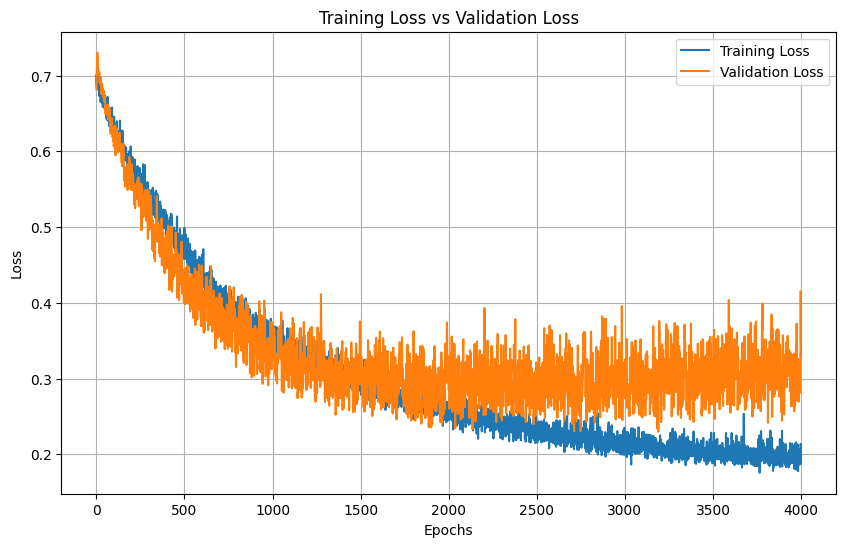

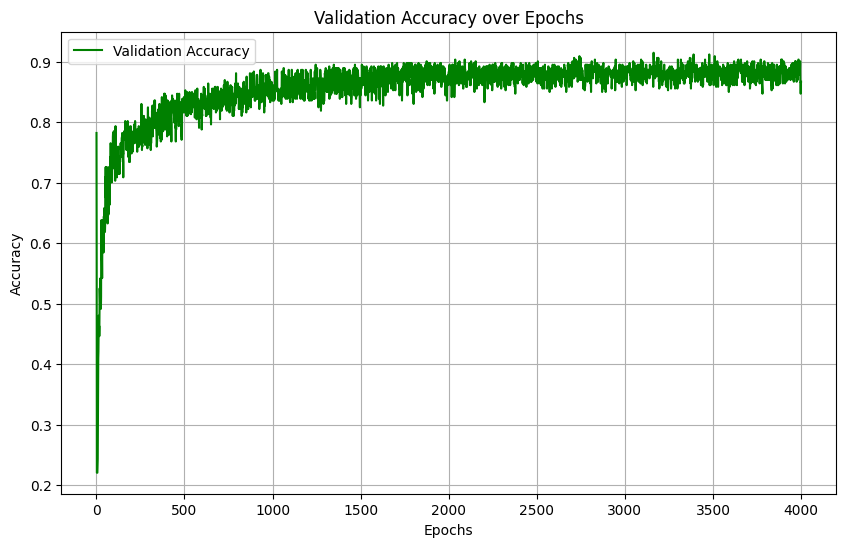

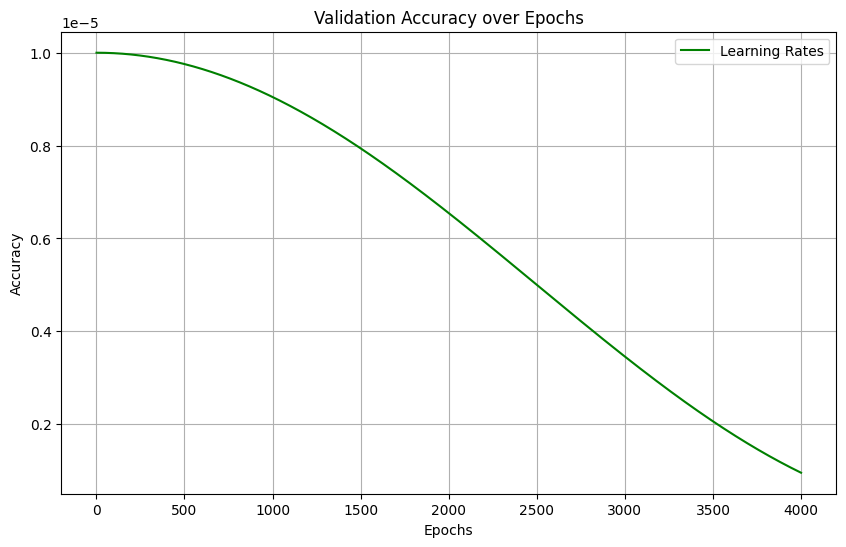

Model for bin 2 saved to GCNModels-5A_exp1/model_bin_2.pth
Training on bin 3/50
Bin 3, Epoch 1/4000, Train Loss: 0.7026, Validation Loss: 0.7191,  Accuracy: 0.2175, LR: 0.000010
Bin 3, Epoch 101/4000, Train Loss: 0.6178, Validation Loss: 0.6509,  Accuracy: 0.7599, LR: 0.000010
Bin 3, Epoch 201/4000, Train Loss: 0.5744, Validation Loss: 0.5933,  Accuracy: 0.7740, LR: 0.000010
Bin 3, Epoch 301/4000, Train Loss: 0.5177, Validation Loss: 0.5027,  Accuracy: 0.8503, LR: 0.000010
Bin 3, Epoch 401/4000, Train Loss: 0.4811, Validation Loss: 0.4215,  Accuracy: 0.8785, LR: 0.000010
Bin 3, Epoch 501/4000, Train Loss: 0.4388, Validation Loss: 0.4399,  Accuracy: 0.8362, LR: 0.000010
Bin 3, Epoch 601/4000, Train Loss: 0.4173, Validation Loss: 0.4017,  Accuracy: 0.8446, LR: 0.000010
Bin 3, Epoch 701/4000, Train Loss: 0.4063, Validation Loss: 0.3598,  Accuracy: 0.8588, LR: 0.000010
Bin 3, Epoch 801/4000, Train Loss: 0.3763, Validation Loss: 0.3462,  Accuracy: 0.8588, LR: 0.000009
Bin 3, Epoch 901/4000,

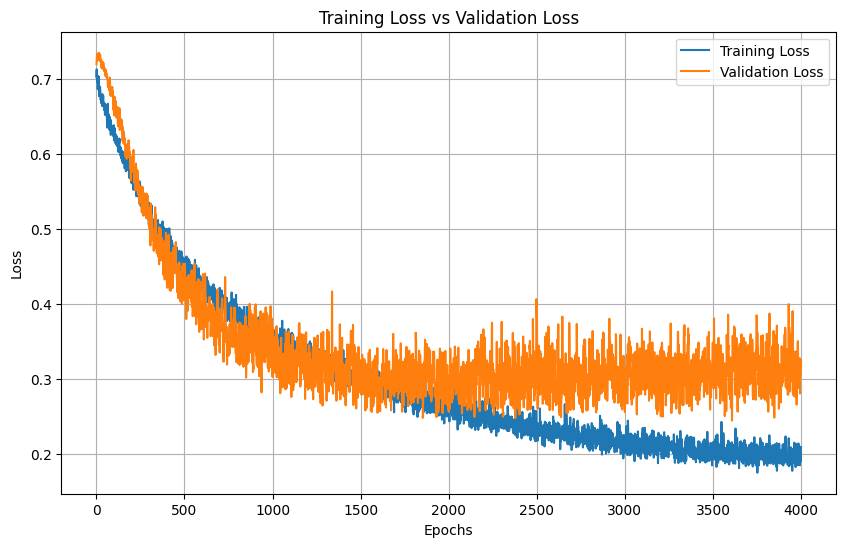

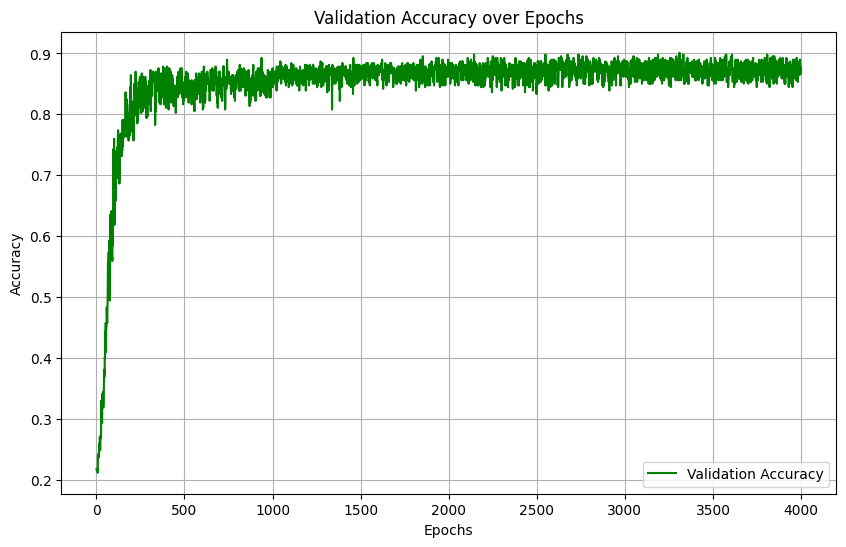

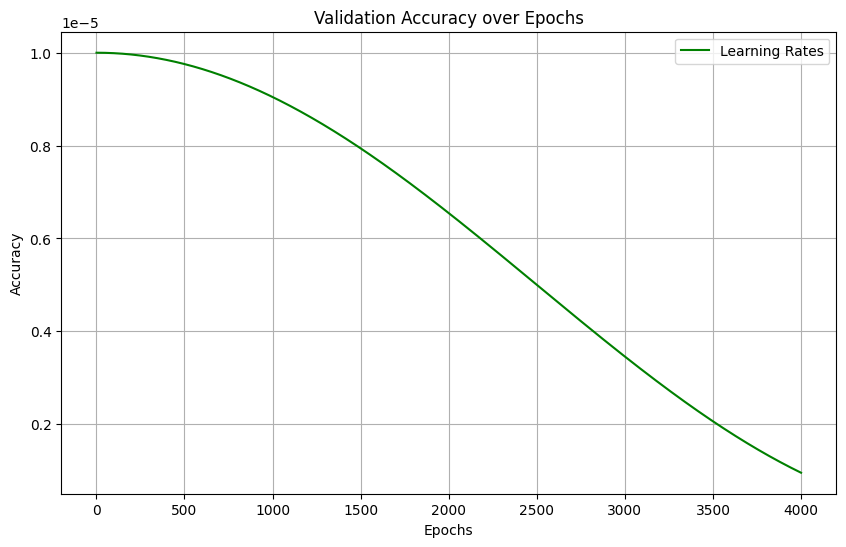

Model for bin 3 saved to GCNModels-5A_exp1/model_bin_3.pth
Training on bin 4/50
Bin 4, Epoch 1/4000, Train Loss: 0.7134, Validation Loss: 0.6758,  Accuracy: 0.7825, LR: 0.000010
Bin 4, Epoch 101/4000, Train Loss: 0.6003, Validation Loss: 0.6489,  Accuracy: 0.7401, LR: 0.000010
Bin 4, Epoch 201/4000, Train Loss: 0.5376, Validation Loss: 0.5503,  Accuracy: 0.8418, LR: 0.000010
Bin 4, Epoch 301/4000, Train Loss: 0.4854, Validation Loss: 0.5039,  Accuracy: 0.8531, LR: 0.000010
Bin 4, Epoch 401/4000, Train Loss: 0.4457, Validation Loss: 0.4651,  Accuracy: 0.8644, LR: 0.000010
Bin 4, Epoch 501/4000, Train Loss: 0.4094, Validation Loss: 0.4285,  Accuracy: 0.8672, LR: 0.000010
Bin 4, Epoch 601/4000, Train Loss: 0.3685, Validation Loss: 0.4049,  Accuracy: 0.8701, LR: 0.000010
Bin 4, Epoch 701/4000, Train Loss: 0.3518, Validation Loss: 0.3785,  Accuracy: 0.8757, LR: 0.000010
Bin 4, Epoch 801/4000, Train Loss: 0.3302, Validation Loss: 0.3397,  Accuracy: 0.8842, LR: 0.000009
Bin 4, Epoch 901/4000,

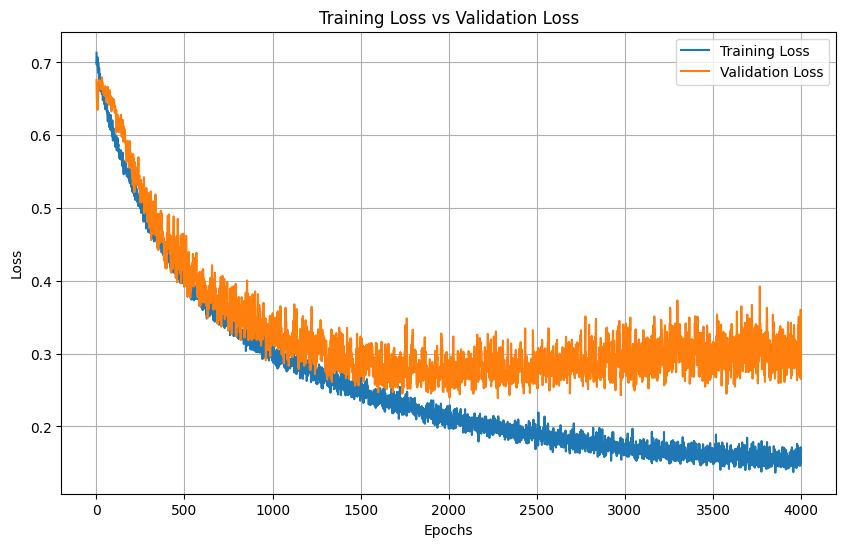

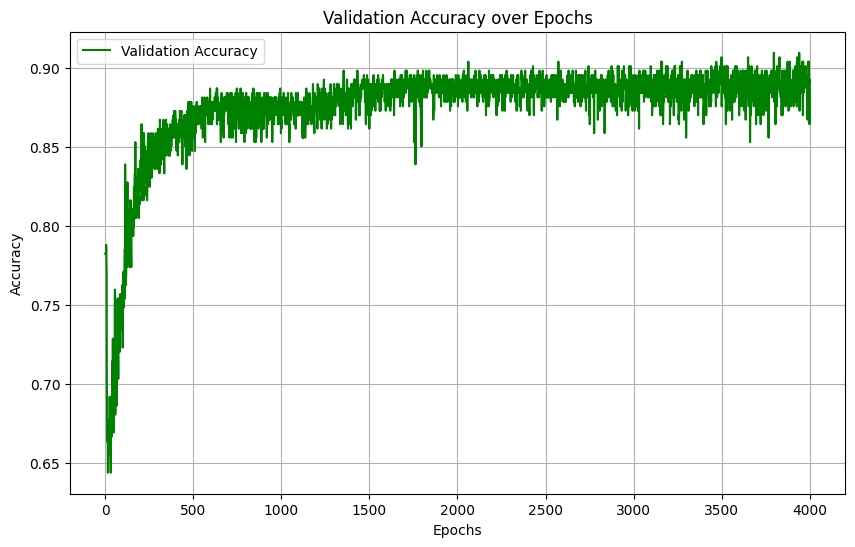

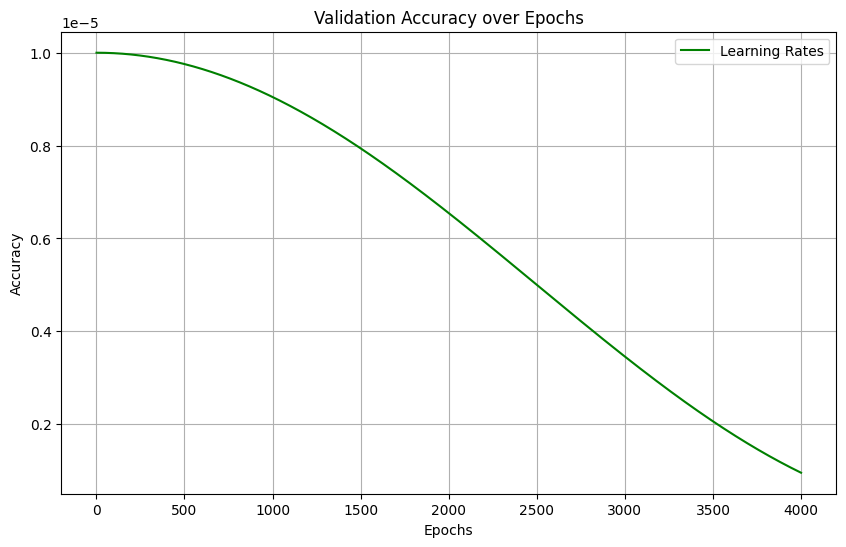

Model for bin 4 saved to GCNModels-5A_exp1/model_bin_4.pth
Training on bin 5/50
Bin 5, Epoch 1/4000, Train Loss: 0.6804, Validation Loss: 0.6998,  Accuracy: 0.2175, LR: 0.000010
Bin 5, Epoch 101/4000, Train Loss: 0.6345, Validation Loss: 0.6402,  Accuracy: 0.7232, LR: 0.000010
Bin 5, Epoch 201/4000, Train Loss: 0.5651, Validation Loss: 0.5743,  Accuracy: 0.7910, LR: 0.000010
Bin 5, Epoch 301/4000, Train Loss: 0.5229, Validation Loss: 0.5250,  Accuracy: 0.8277, LR: 0.000010
Bin 5, Epoch 401/4000, Train Loss: 0.4966, Validation Loss: 0.4572,  Accuracy: 0.8305, LR: 0.000010
Bin 5, Epoch 501/4000, Train Loss: 0.4632, Validation Loss: 0.4608,  Accuracy: 0.8220, LR: 0.000010
Bin 5, Epoch 601/4000, Train Loss: 0.4502, Validation Loss: 0.4115,  Accuracy: 0.8503, LR: 0.000010
Bin 5, Epoch 701/4000, Train Loss: 0.4292, Validation Loss: 0.3857,  Accuracy: 0.8503, LR: 0.000010
Bin 5, Epoch 801/4000, Train Loss: 0.4174, Validation Loss: 0.3651,  Accuracy: 0.8559, LR: 0.000009
Bin 5, Epoch 901/4000,

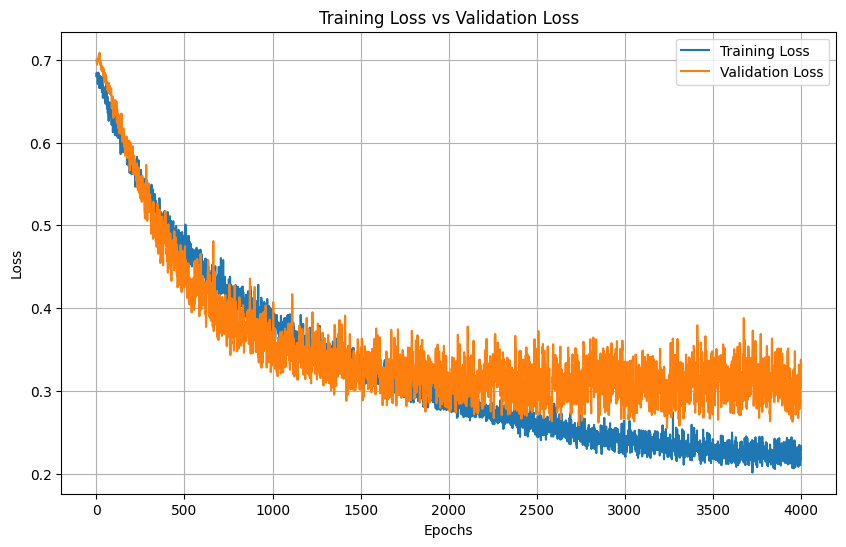

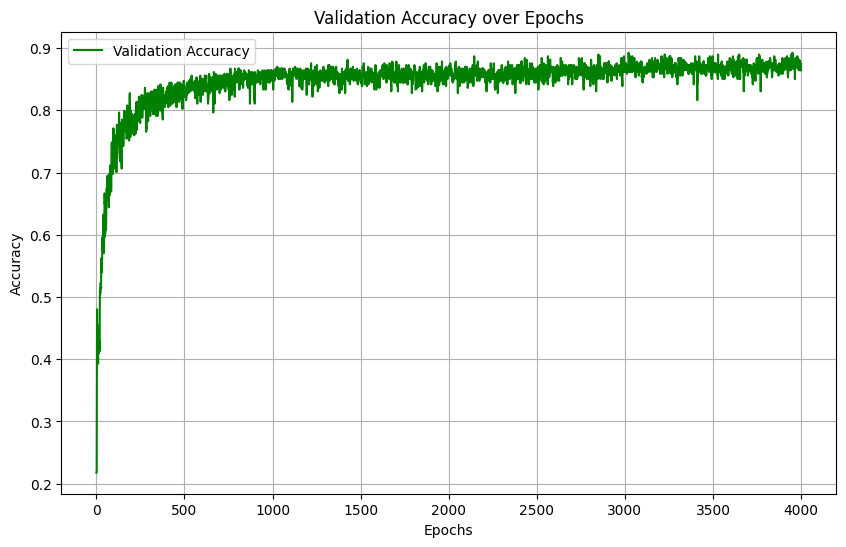

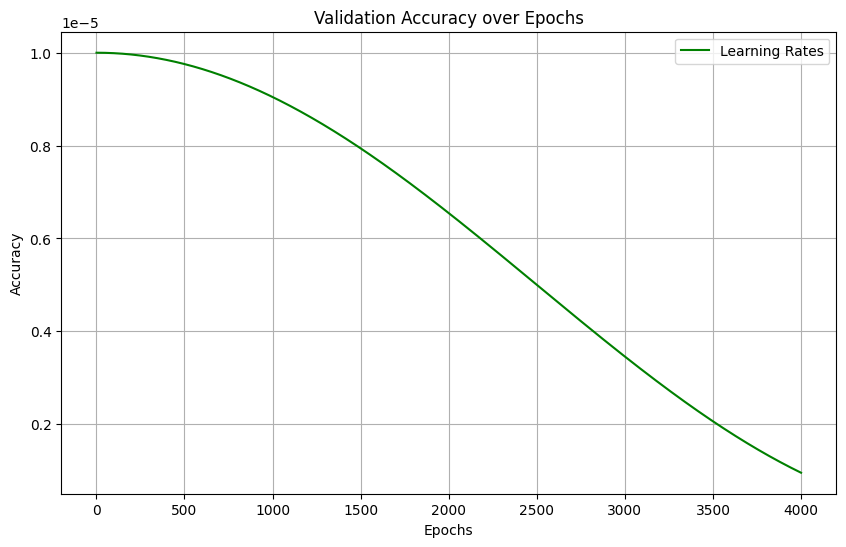

Model for bin 5 saved to GCNModels-5A_exp1/model_bin_5.pth
Training on bin 6/50
Bin 6, Epoch 1/4000, Train Loss: 0.7360, Validation Loss: 0.7223,  Accuracy: 0.2175, LR: 0.000010
Bin 6, Epoch 101/4000, Train Loss: 0.6281, Validation Loss: 0.6623,  Accuracy: 0.7090, LR: 0.000010
Bin 6, Epoch 201/4000, Train Loss: 0.5557, Validation Loss: 0.5835,  Accuracy: 0.7994, LR: 0.000010
Bin 6, Epoch 301/4000, Train Loss: 0.5026, Validation Loss: 0.5162,  Accuracy: 0.8164, LR: 0.000010
Bin 6, Epoch 401/4000, Train Loss: 0.4585, Validation Loss: 0.5112,  Accuracy: 0.7938, LR: 0.000010
Bin 6, Epoch 501/4000, Train Loss: 0.4220, Validation Loss: 0.4558,  Accuracy: 0.8390, LR: 0.000010
Bin 6, Epoch 601/4000, Train Loss: 0.4011, Validation Loss: 0.4319,  Accuracy: 0.8446, LR: 0.000010
Bin 6, Epoch 701/4000, Train Loss: 0.3742, Validation Loss: 0.4532,  Accuracy: 0.8362, LR: 0.000010
Bin 6, Epoch 801/4000, Train Loss: 0.3596, Validation Loss: 0.4272,  Accuracy: 0.8588, LR: 0.000009
Bin 6, Epoch 901/4000,

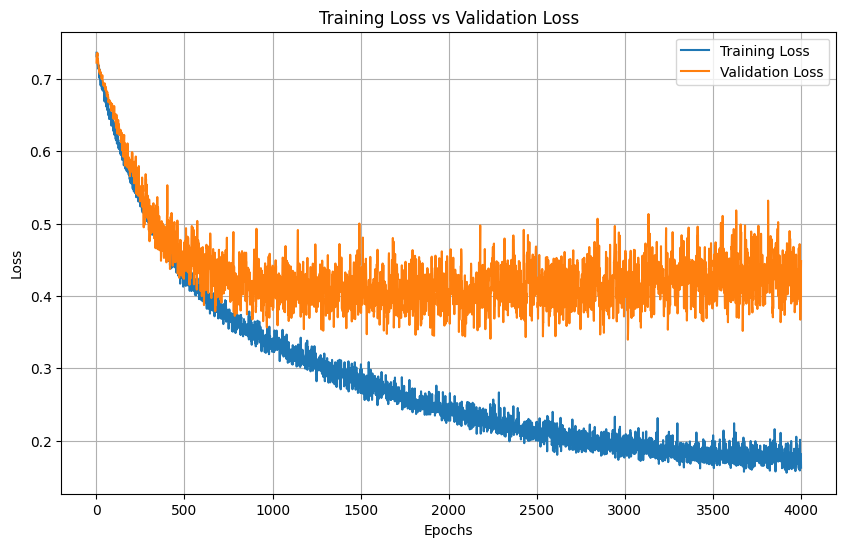

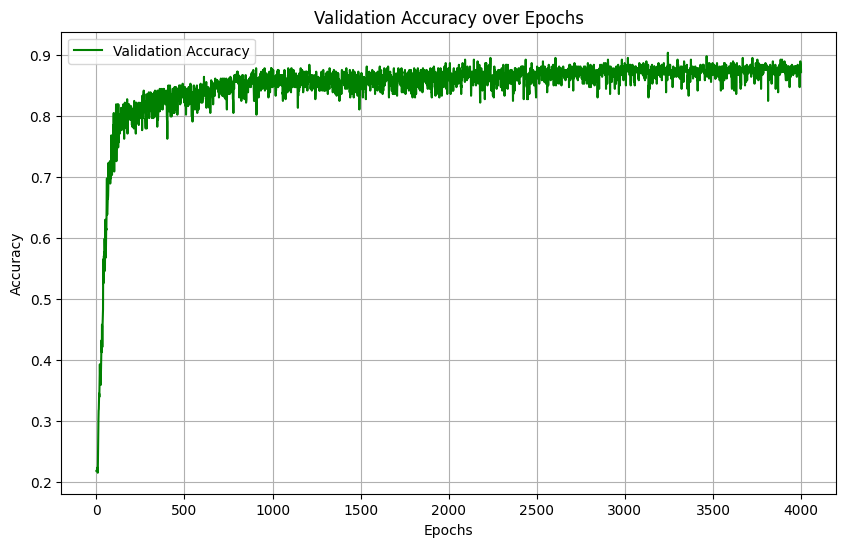

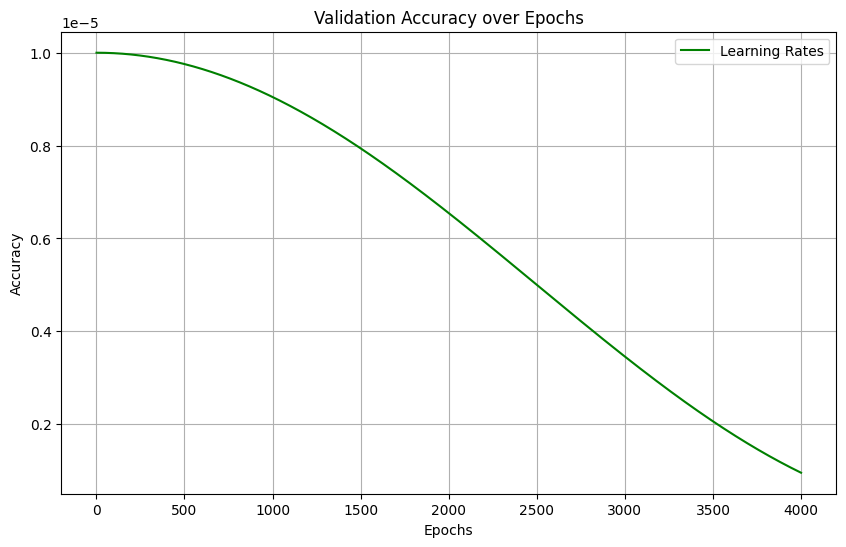

Model for bin 6 saved to GCNModels-5A_exp1/model_bin_6.pth
Training on bin 7/50
Bin 7, Epoch 1/4000, Train Loss: 0.7015, Validation Loss: 0.6967,  Accuracy: 0.2175, LR: 0.000010
Bin 7, Epoch 101/4000, Train Loss: 0.6507, Validation Loss: 0.6668,  Accuracy: 0.6893, LR: 0.000010
Bin 7, Epoch 201/4000, Train Loss: 0.6011, Validation Loss: 0.5859,  Accuracy: 0.7994, LR: 0.000010
Bin 7, Epoch 301/4000, Train Loss: 0.5619, Validation Loss: 0.5361,  Accuracy: 0.8136, LR: 0.000010
Bin 7, Epoch 401/4000, Train Loss: 0.5258, Validation Loss: 0.4979,  Accuracy: 0.8136, LR: 0.000010
Bin 7, Epoch 501/4000, Train Loss: 0.4843, Validation Loss: 0.5121,  Accuracy: 0.7853, LR: 0.000010
Bin 7, Epoch 601/4000, Train Loss: 0.4718, Validation Loss: 0.4148,  Accuracy: 0.8362, LR: 0.000010
Bin 7, Epoch 701/4000, Train Loss: 0.4555, Validation Loss: 0.4289,  Accuracy: 0.8136, LR: 0.000010
Bin 7, Epoch 801/4000, Train Loss: 0.4189, Validation Loss: 0.3914,  Accuracy: 0.8305, LR: 0.000009
Bin 7, Epoch 901/4000,

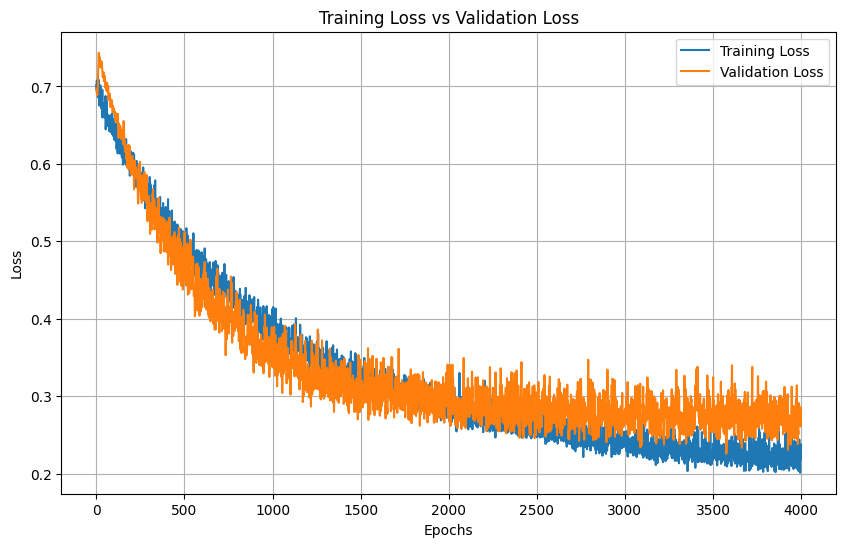

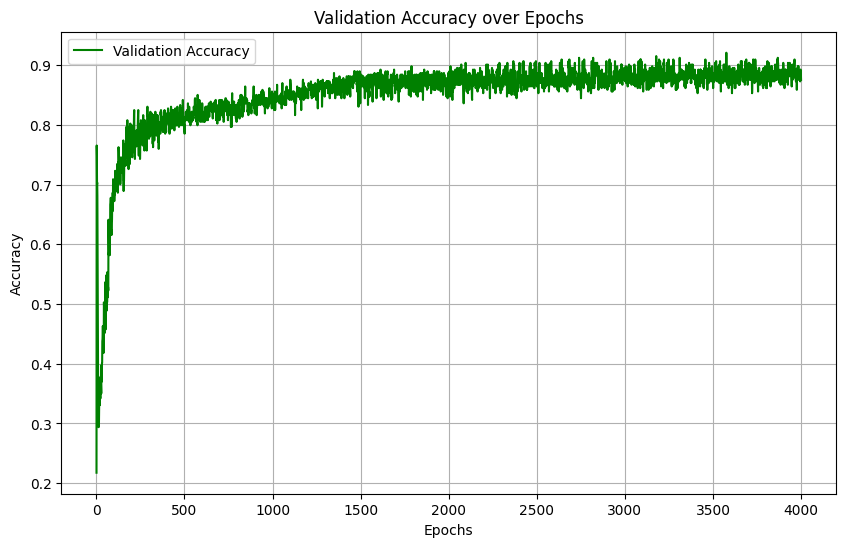

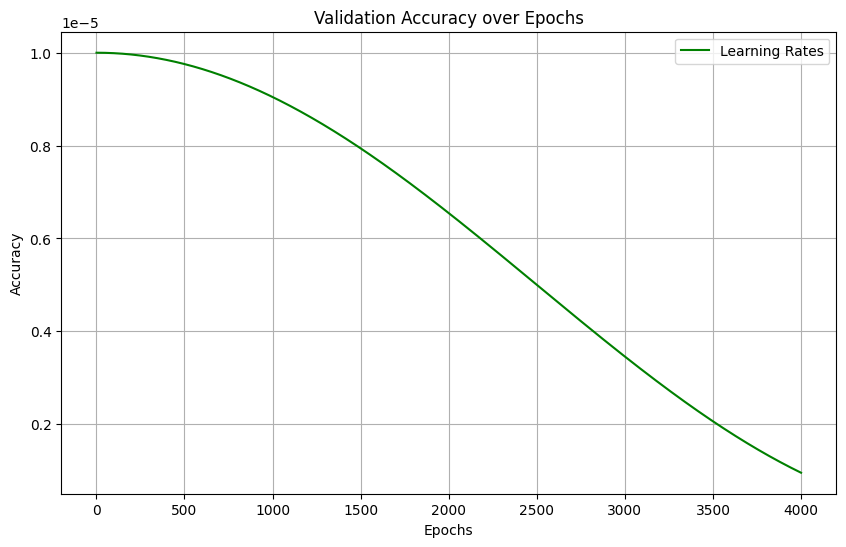

Model for bin 7 saved to GCNModels-5A_exp1/model_bin_7.pth
Training on bin 8/50
Bin 8, Epoch 1/4000, Train Loss: 0.7113, Validation Loss: 0.6897,  Accuracy: 0.7825, LR: 0.000010
Bin 8, Epoch 101/4000, Train Loss: 0.6353, Validation Loss: 0.6653,  Accuracy: 0.7260, LR: 0.000010
Bin 8, Epoch 201/4000, Train Loss: 0.5890, Validation Loss: 0.5984,  Accuracy: 0.8503, LR: 0.000010
Bin 8, Epoch 301/4000, Train Loss: 0.5492, Validation Loss: 0.5327,  Accuracy: 0.8616, LR: 0.000010
Bin 8, Epoch 401/4000, Train Loss: 0.5240, Validation Loss: 0.4750,  Accuracy: 0.8757, LR: 0.000010
Bin 8, Epoch 501/4000, Train Loss: 0.4769, Validation Loss: 0.4392,  Accuracy: 0.8531, LR: 0.000010
Bin 8, Epoch 601/4000, Train Loss: 0.4656, Validation Loss: 0.4055,  Accuracy: 0.8616, LR: 0.000010
Bin 8, Epoch 701/4000, Train Loss: 0.4340, Validation Loss: 0.3775,  Accuracy: 0.8588, LR: 0.000010
Bin 8, Epoch 801/4000, Train Loss: 0.4129, Validation Loss: 0.3804,  Accuracy: 0.8616, LR: 0.000009
Bin 8, Epoch 901/4000,

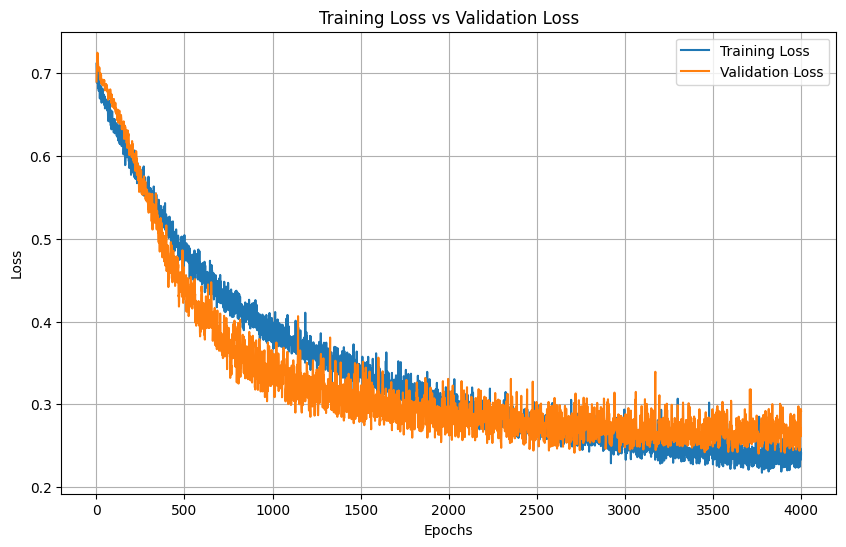

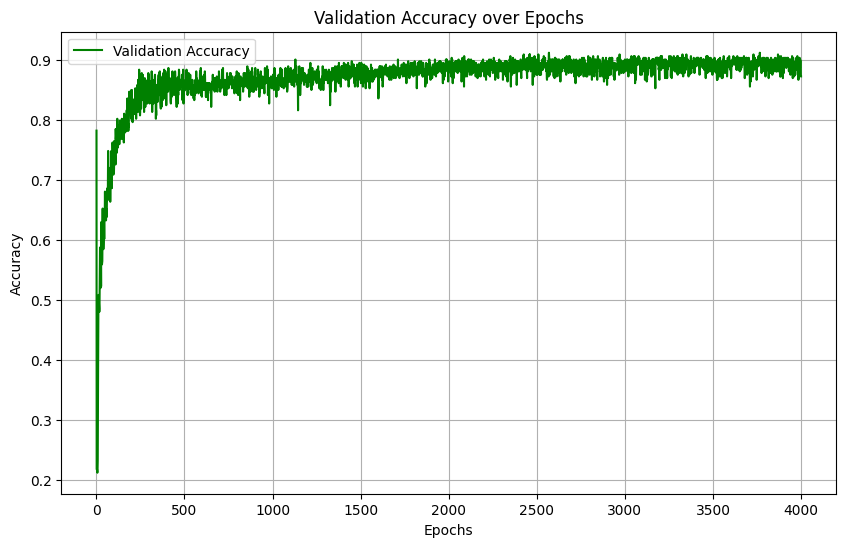

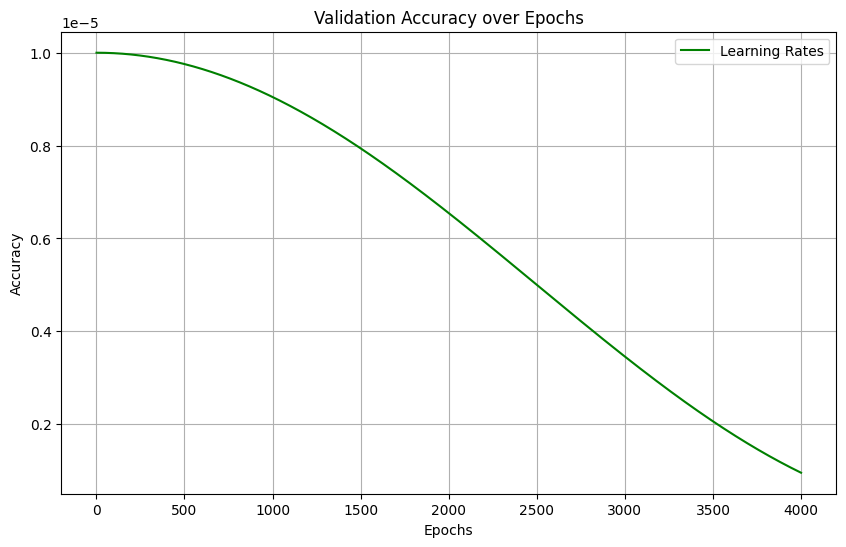

Model for bin 8 saved to GCNModels-5A_exp1/model_bin_8.pth
Training on bin 9/50
Bin 9, Epoch 1/4000, Train Loss: 0.7129, Validation Loss: 0.7333,  Accuracy: 0.2175, LR: 0.000010
Bin 9, Epoch 101/4000, Train Loss: 0.6365, Validation Loss: 0.6846,  Accuracy: 0.6356, LR: 0.000010
Bin 9, Epoch 201/4000, Train Loss: 0.5718, Validation Loss: 0.6325,  Accuracy: 0.7966, LR: 0.000010
Bin 9, Epoch 301/4000, Train Loss: 0.5111, Validation Loss: 0.5671,  Accuracy: 0.8390, LR: 0.000010
Bin 9, Epoch 401/4000, Train Loss: 0.4776, Validation Loss: 0.5224,  Accuracy: 0.8475, LR: 0.000010
Bin 9, Epoch 501/4000, Train Loss: 0.4439, Validation Loss: 0.4713,  Accuracy: 0.8616, LR: 0.000010
Bin 9, Epoch 601/4000, Train Loss: 0.4045, Validation Loss: 0.4682,  Accuracy: 0.8588, LR: 0.000010
Bin 9, Epoch 701/4000, Train Loss: 0.3844, Validation Loss: 0.4144,  Accuracy: 0.8672, LR: 0.000010
Bin 9, Epoch 801/4000, Train Loss: 0.3637, Validation Loss: 0.4159,  Accuracy: 0.8616, LR: 0.000009
Bin 9, Epoch 901/4000,

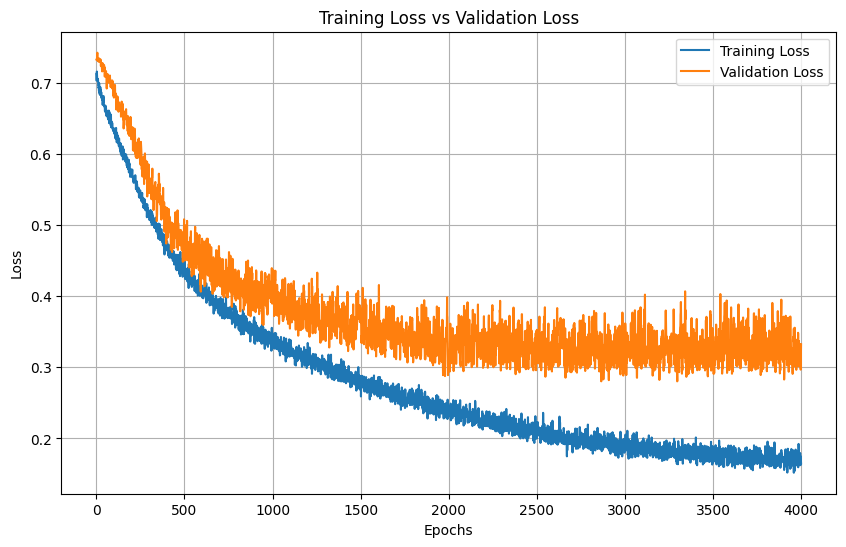

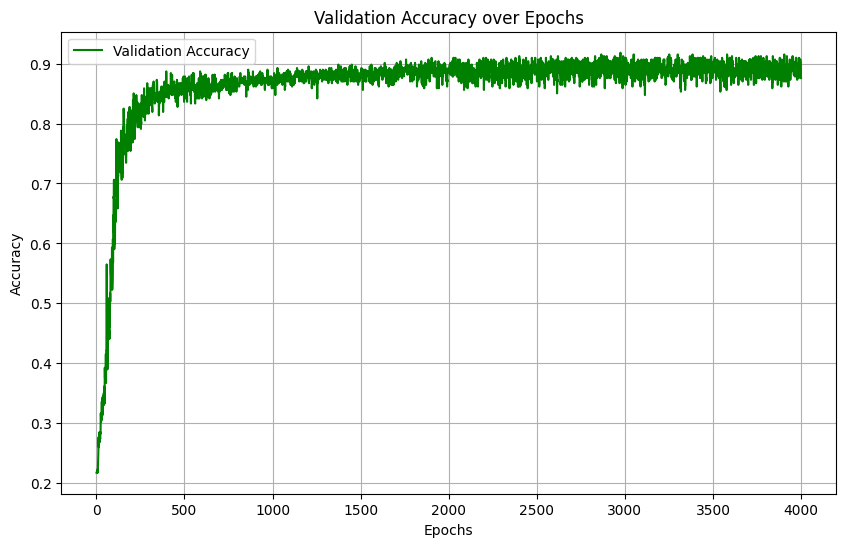

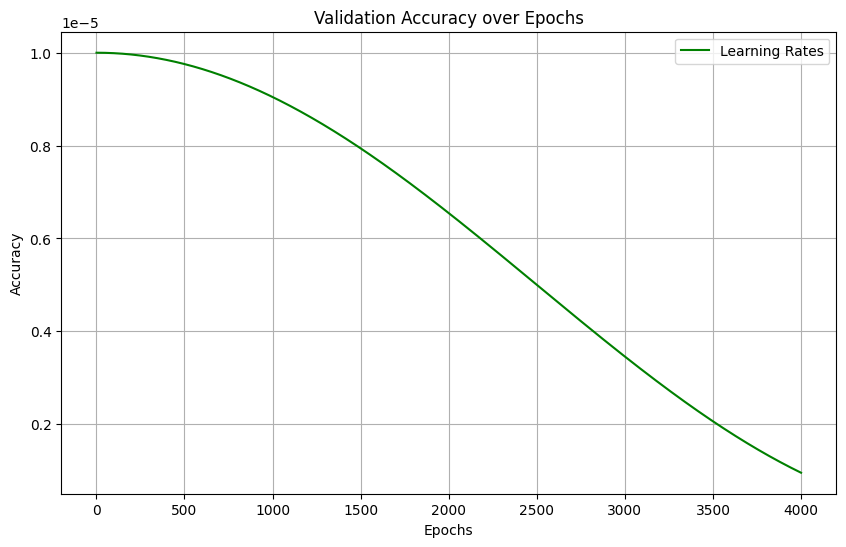

Model for bin 9 saved to GCNModels-5A_exp1/model_bin_9.pth
Training on bin 10/50
Bin 10, Epoch 1/4000, Train Loss: 0.7122, Validation Loss: 0.6725,  Accuracy: 0.7825, LR: 0.000010
Bin 10, Epoch 101/4000, Train Loss: 0.6229, Validation Loss: 0.6049,  Accuracy: 0.7655, LR: 0.000010
Bin 10, Epoch 201/4000, Train Loss: 0.5845, Validation Loss: 0.5573,  Accuracy: 0.7938, LR: 0.000010
Bin 10, Epoch 301/4000, Train Loss: 0.5425, Validation Loss: 0.5144,  Accuracy: 0.7910, LR: 0.000010
Bin 10, Epoch 401/4000, Train Loss: 0.5097, Validation Loss: 0.4460,  Accuracy: 0.8446, LR: 0.000010
Bin 10, Epoch 501/4000, Train Loss: 0.4666, Validation Loss: 0.4596,  Accuracy: 0.8051, LR: 0.000010
Bin 10, Epoch 601/4000, Train Loss: 0.4363, Validation Loss: 0.4159,  Accuracy: 0.8333, LR: 0.000010
Bin 10, Epoch 701/4000, Train Loss: 0.4256, Validation Loss: 0.3990,  Accuracy: 0.8418, LR: 0.000010
Bin 10, Epoch 801/4000, Train Loss: 0.4026, Validation Loss: 0.3705,  Accuracy: 0.8475, LR: 0.000009
Bin 10, Epoc

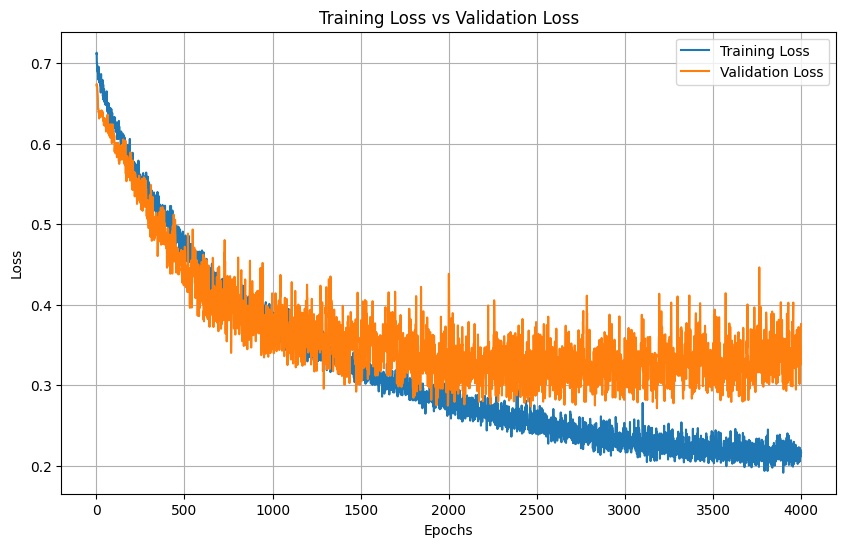

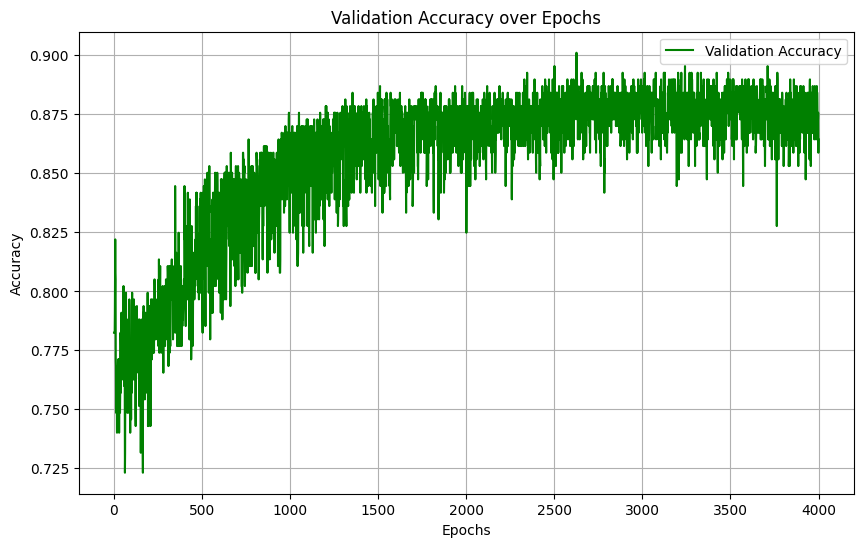

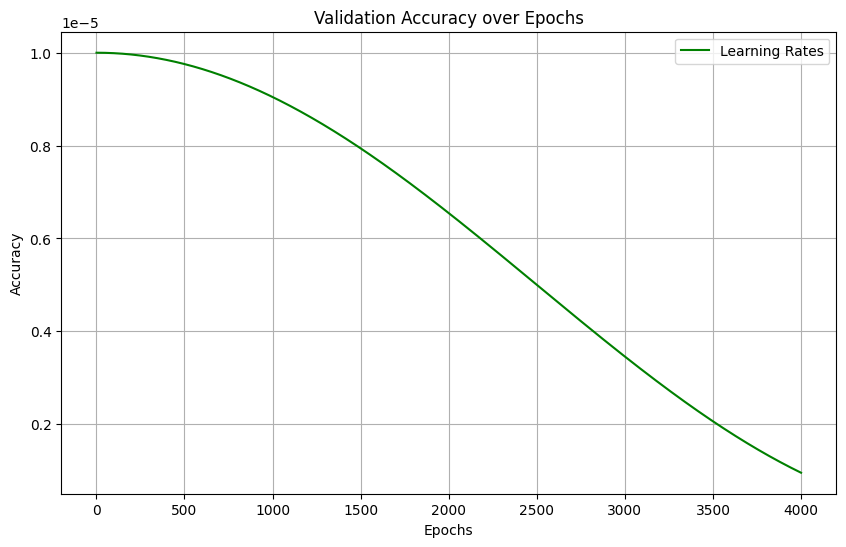

Model for bin 10 saved to GCNModels-5A_exp1/model_bin_10.pth
Training on bin 11/50
Bin 11, Epoch 1/4000, Train Loss: 0.6958, Validation Loss: 0.6886,  Accuracy: 0.7797, LR: 0.000010
Bin 11, Epoch 101/4000, Train Loss: 0.6233, Validation Loss: 0.6678,  Accuracy: 0.7994, LR: 0.000010
Bin 11, Epoch 201/4000, Train Loss: 0.5630, Validation Loss: 0.6047,  Accuracy: 0.8305, LR: 0.000010
Bin 11, Epoch 301/4000, Train Loss: 0.5101, Validation Loss: 0.5560,  Accuracy: 0.8390, LR: 0.000010
Bin 11, Epoch 401/4000, Train Loss: 0.4735, Validation Loss: 0.4971,  Accuracy: 0.8475, LR: 0.000010
Bin 11, Epoch 501/4000, Train Loss: 0.4378, Validation Loss: 0.4751,  Accuracy: 0.8503, LR: 0.000010
Bin 11, Epoch 601/4000, Train Loss: 0.4277, Validation Loss: 0.4290,  Accuracy: 0.8559, LR: 0.000010
Bin 11, Epoch 701/4000, Train Loss: 0.4059, Validation Loss: 0.4549,  Accuracy: 0.8418, LR: 0.000010
Bin 11, Epoch 801/4000, Train Loss: 0.3814, Validation Loss: 0.4390,  Accuracy: 0.8531, LR: 0.000009
Bin 11, Ep

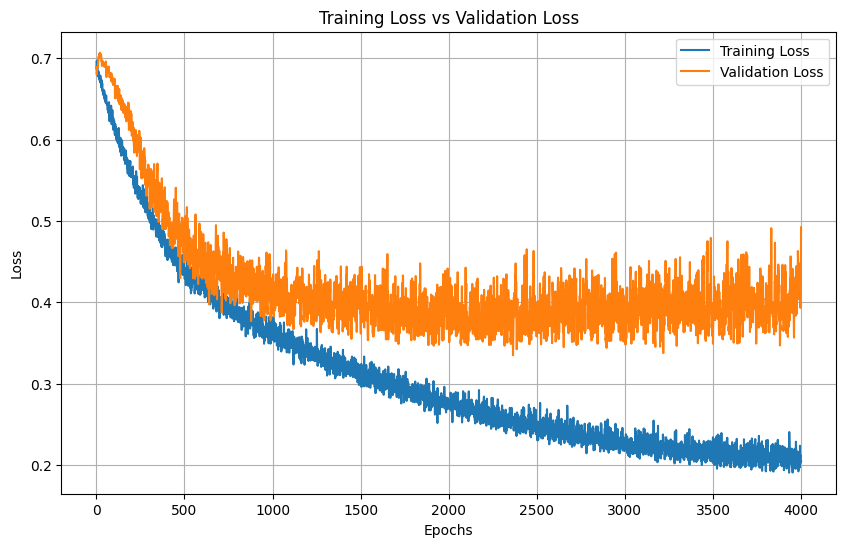

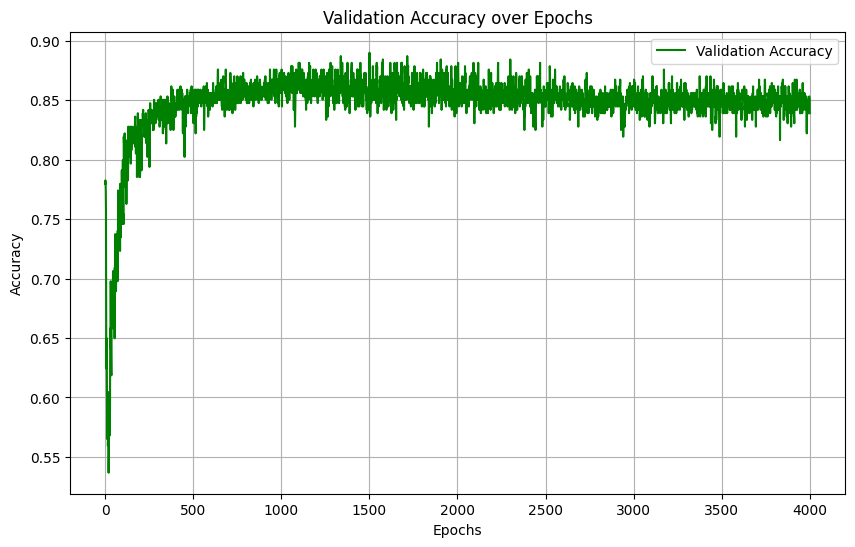

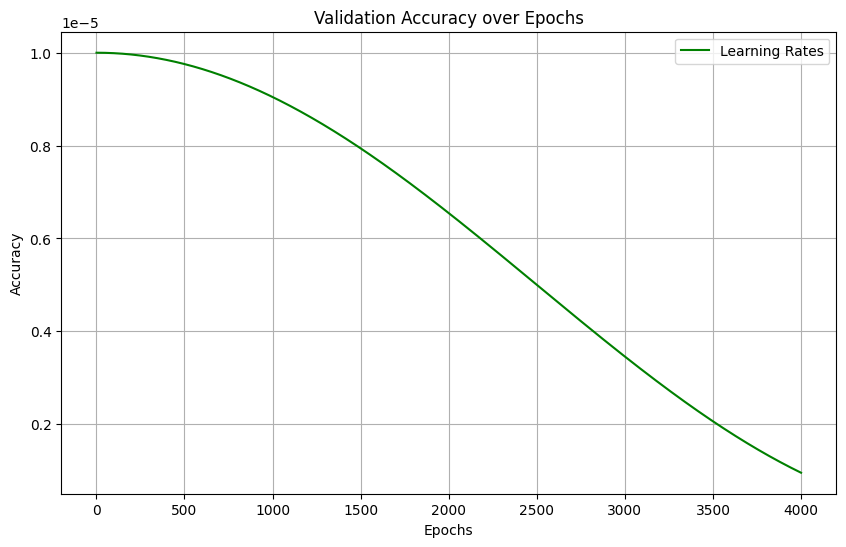

Model for bin 11 saved to GCNModels-5A_exp1/model_bin_11.pth
Training on bin 12/50
Bin 12, Epoch 1/4000, Train Loss: 0.7179, Validation Loss: 0.6701,  Accuracy: 0.7825, LR: 0.000010
Bin 12, Epoch 101/4000, Train Loss: 0.6443, Validation Loss: 0.6415,  Accuracy: 0.7458, LR: 0.000010
Bin 12, Epoch 201/4000, Train Loss: 0.6087, Validation Loss: 0.5947,  Accuracy: 0.7797, LR: 0.000010
Bin 12, Epoch 301/4000, Train Loss: 0.5487, Validation Loss: 0.5249,  Accuracy: 0.8192, LR: 0.000010
Bin 12, Epoch 401/4000, Train Loss: 0.5103, Validation Loss: 0.4714,  Accuracy: 0.8249, LR: 0.000010
Bin 12, Epoch 501/4000, Train Loss: 0.4737, Validation Loss: 0.4496,  Accuracy: 0.8446, LR: 0.000010
Bin 12, Epoch 601/4000, Train Loss: 0.4385, Validation Loss: 0.4121,  Accuracy: 0.8390, LR: 0.000010
Bin 12, Epoch 701/4000, Train Loss: 0.4299, Validation Loss: 0.4425,  Accuracy: 0.8446, LR: 0.000010
Bin 12, Epoch 801/4000, Train Loss: 0.4030, Validation Loss: 0.4107,  Accuracy: 0.8559, LR: 0.000009
Bin 12, Ep

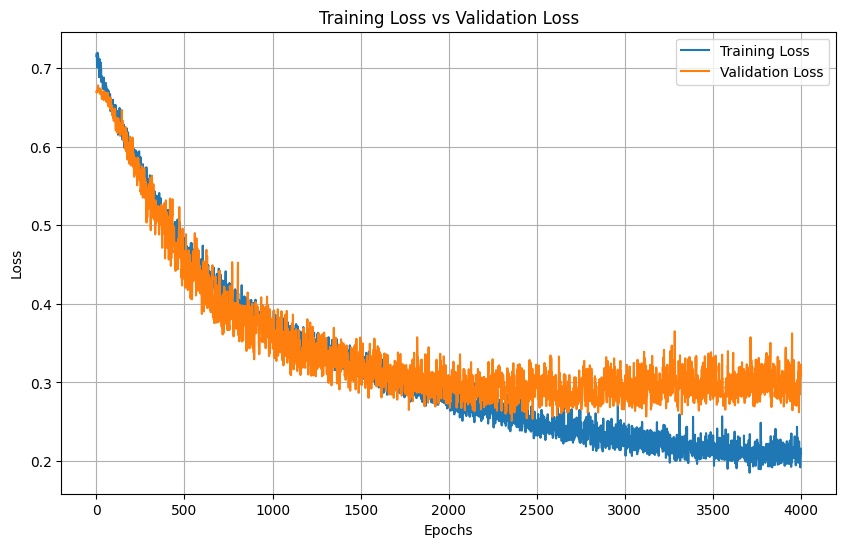

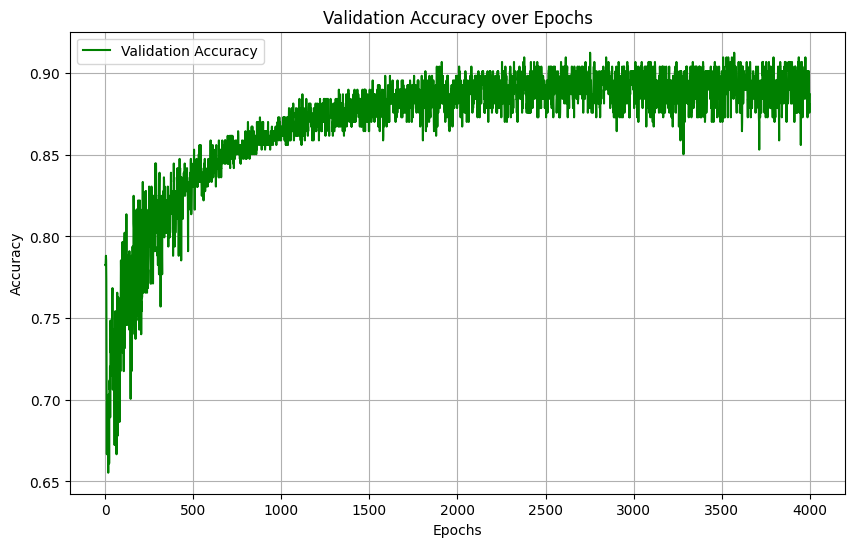

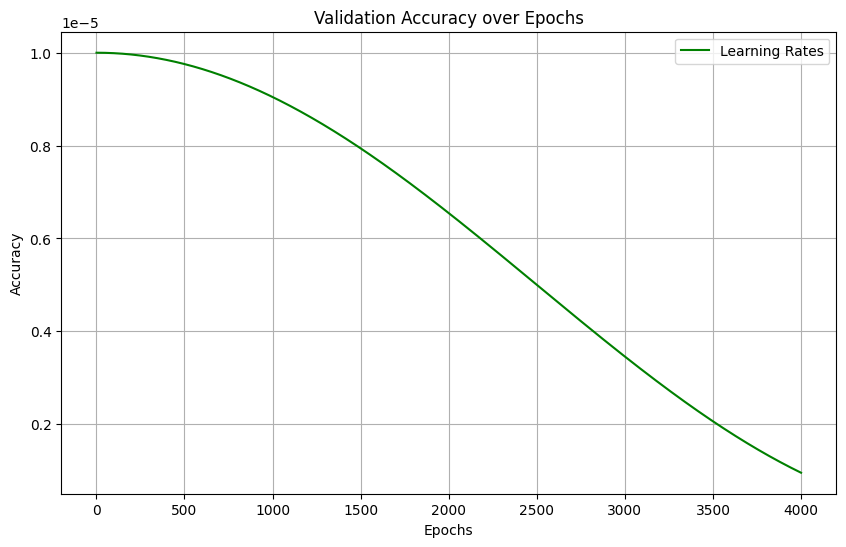

Model for bin 12 saved to GCNModels-5A_exp1/model_bin_12.pth
Training on bin 13/50
Bin 13, Epoch 1/4000, Train Loss: 0.7302, Validation Loss: 0.7205,  Accuracy: 0.2175, LR: 0.000010
Bin 13, Epoch 101/4000, Train Loss: 0.6568, Validation Loss: 0.7020,  Accuracy: 0.4887, LR: 0.000010
Bin 13, Epoch 201/4000, Train Loss: 0.6101, Validation Loss: 0.6266,  Accuracy: 0.7542, LR: 0.000010
Bin 13, Epoch 301/4000, Train Loss: 0.5645, Validation Loss: 0.5670,  Accuracy: 0.7910, LR: 0.000010
Bin 13, Epoch 401/4000, Train Loss: 0.5177, Validation Loss: 0.4971,  Accuracy: 0.8277, LR: 0.000010
Bin 13, Epoch 501/4000, Train Loss: 0.4721, Validation Loss: 0.4420,  Accuracy: 0.8531, LR: 0.000010
Bin 13, Epoch 601/4000, Train Loss: 0.4428, Validation Loss: 0.4367,  Accuracy: 0.8390, LR: 0.000010
Bin 13, Epoch 701/4000, Train Loss: 0.4168, Validation Loss: 0.4075,  Accuracy: 0.8616, LR: 0.000010
Bin 13, Epoch 801/4000, Train Loss: 0.4041, Validation Loss: 0.3987,  Accuracy: 0.8531, LR: 0.000009
Bin 13, Ep

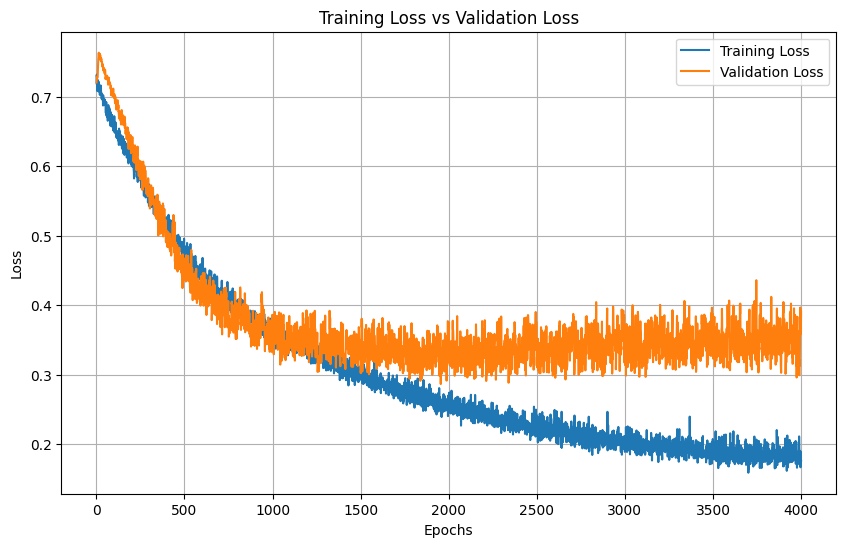

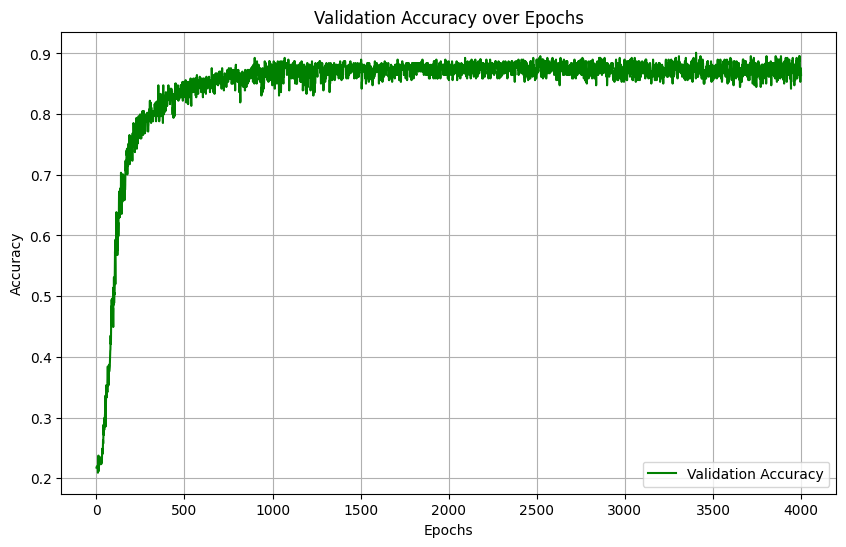

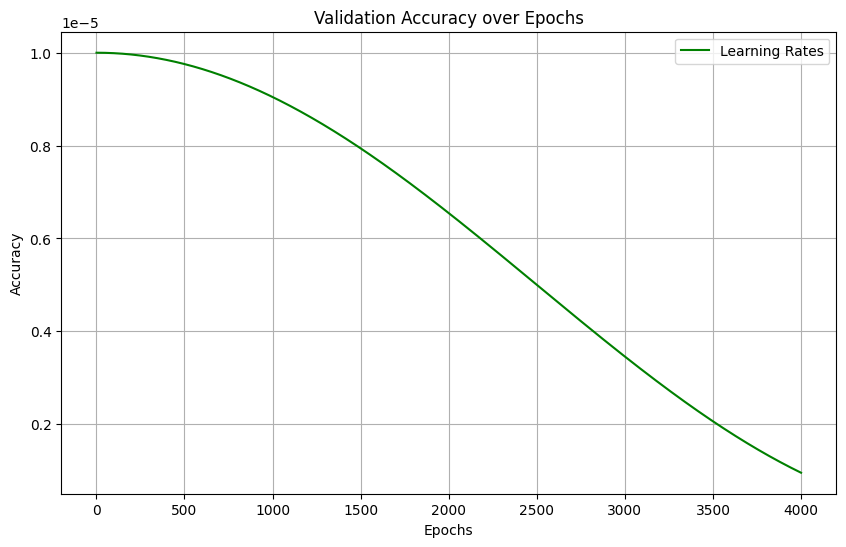

Model for bin 13 saved to GCNModels-5A_exp1/model_bin_13.pth
Training on bin 14/50
Bin 14, Epoch 1/4000, Train Loss: 0.6830, Validation Loss: 0.7054,  Accuracy: 0.2175, LR: 0.000010
Bin 14, Epoch 101/4000, Train Loss: 0.6116, Validation Loss: 0.6396,  Accuracy: 0.7288, LR: 0.000010
Bin 14, Epoch 201/4000, Train Loss: 0.5480, Validation Loss: 0.5626,  Accuracy: 0.7797, LR: 0.000010
Bin 14, Epoch 301/4000, Train Loss: 0.4998, Validation Loss: 0.5202,  Accuracy: 0.7853, LR: 0.000010
Bin 14, Epoch 401/4000, Train Loss: 0.4568, Validation Loss: 0.4046,  Accuracy: 0.8559, LR: 0.000010
Bin 14, Epoch 501/4000, Train Loss: 0.4394, Validation Loss: 0.4287,  Accuracy: 0.8305, LR: 0.000010
Bin 14, Epoch 601/4000, Train Loss: 0.4200, Validation Loss: 0.4182,  Accuracy: 0.8446, LR: 0.000010
Bin 14, Epoch 701/4000, Train Loss: 0.3911, Validation Loss: 0.3462,  Accuracy: 0.8814, LR: 0.000010
Bin 14, Epoch 801/4000, Train Loss: 0.3885, Validation Loss: 0.3827,  Accuracy: 0.8559, LR: 0.000009
Bin 14, Ep

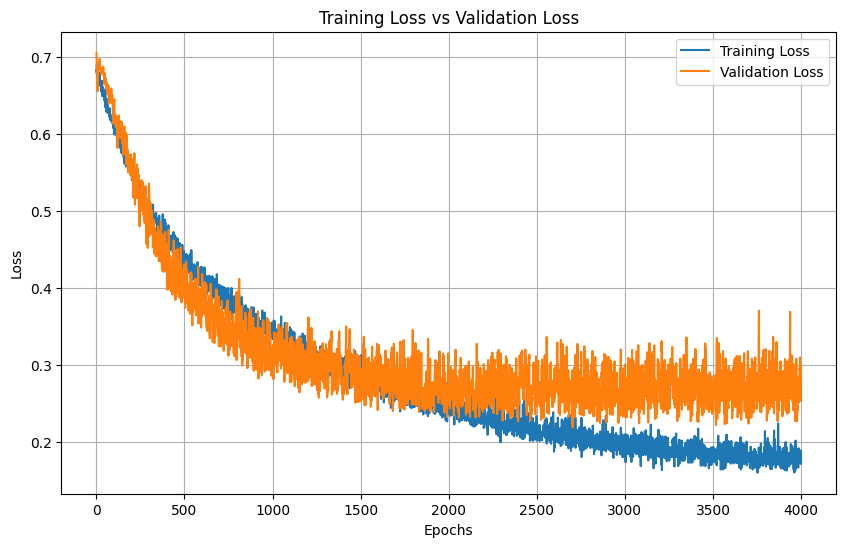

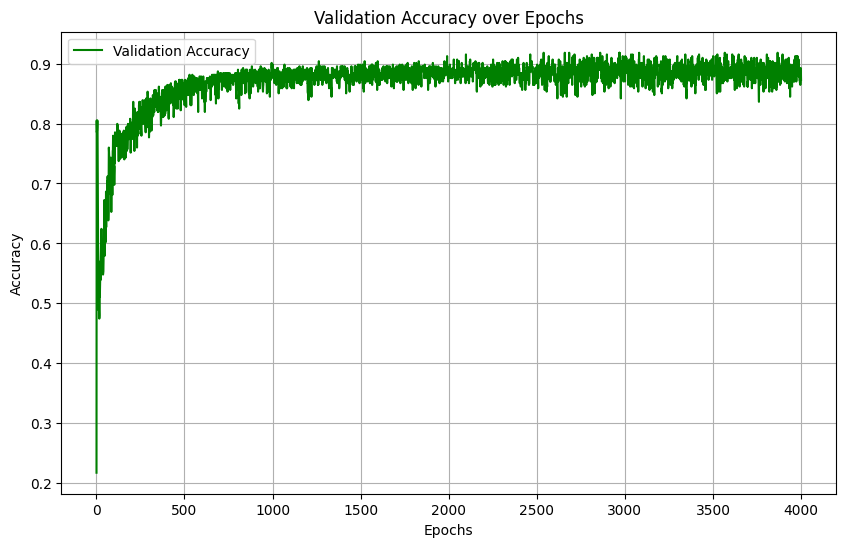

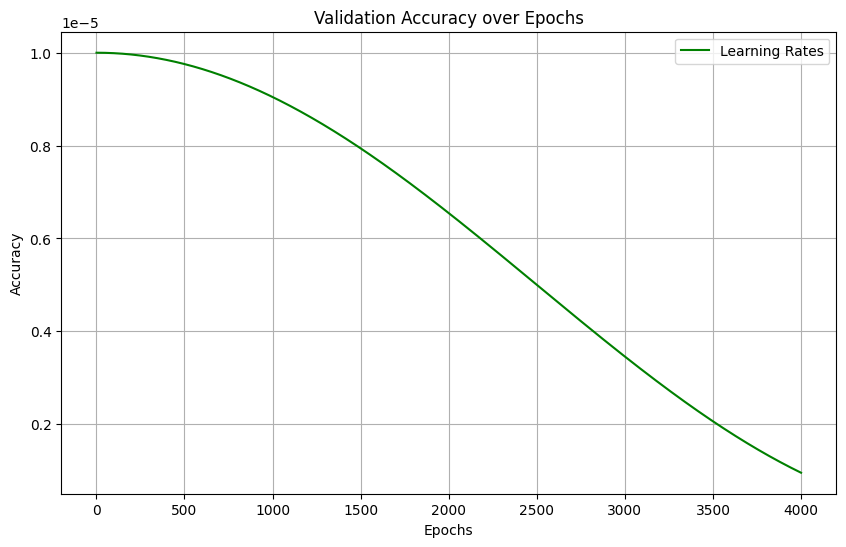

Model for bin 14 saved to GCNModels-5A_exp1/model_bin_14.pth
Training on bin 15/50
Bin 15, Epoch 1/4000, Train Loss: 0.7190, Validation Loss: 0.6746,  Accuracy: 0.7825, LR: 0.000010
Bin 15, Epoch 101/4000, Train Loss: 0.6301, Validation Loss: 0.6446,  Accuracy: 0.7825, LR: 0.000010
Bin 15, Epoch 201/4000, Train Loss: 0.5732, Validation Loss: 0.5917,  Accuracy: 0.8051, LR: 0.000010
Bin 15, Epoch 301/4000, Train Loss: 0.5095, Validation Loss: 0.5214,  Accuracy: 0.8249, LR: 0.000010
Bin 15, Epoch 401/4000, Train Loss: 0.4719, Validation Loss: 0.4748,  Accuracy: 0.8249, LR: 0.000010
Bin 15, Epoch 501/4000, Train Loss: 0.4387, Validation Loss: 0.4572,  Accuracy: 0.8107, LR: 0.000010
Bin 15, Epoch 601/4000, Train Loss: 0.4117, Validation Loss: 0.4259,  Accuracy: 0.8107, LR: 0.000010
Bin 15, Epoch 701/4000, Train Loss: 0.3922, Validation Loss: 0.3769,  Accuracy: 0.8446, LR: 0.000010
Bin 15, Epoch 801/4000, Train Loss: 0.3706, Validation Loss: 0.3771,  Accuracy: 0.8305, LR: 0.000009
Bin 15, Ep

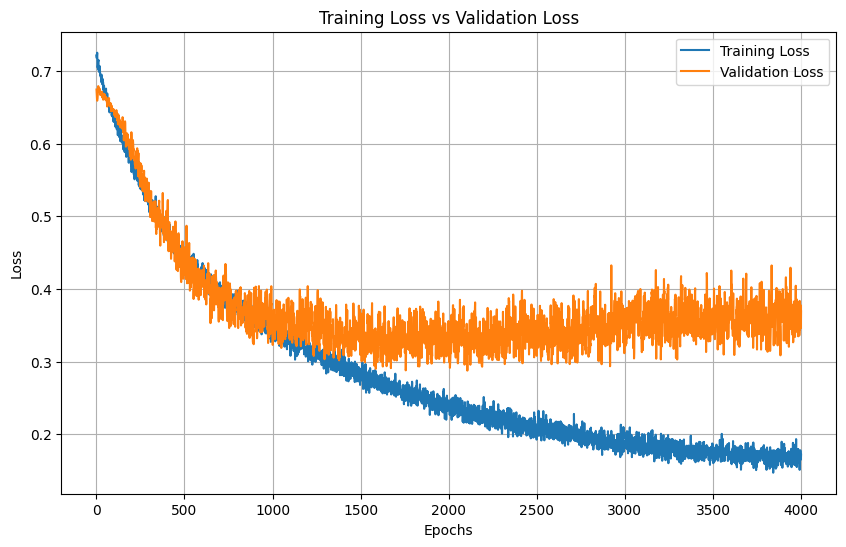

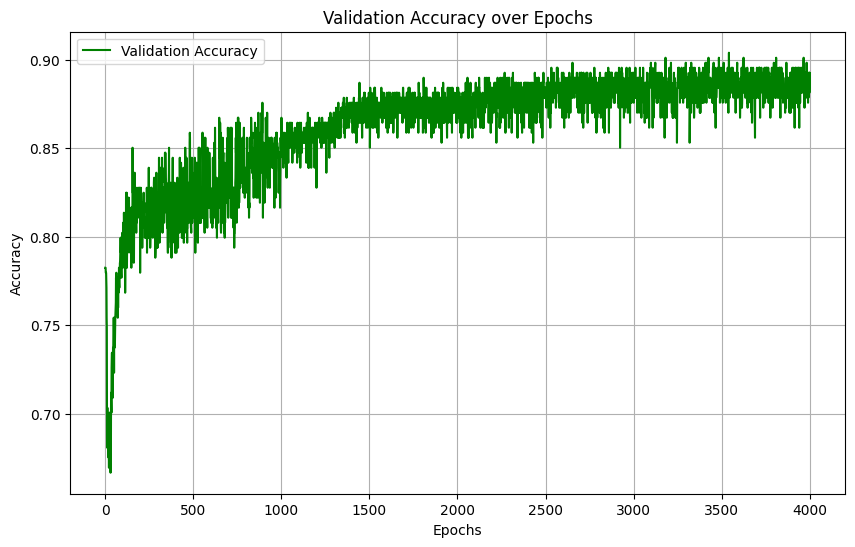

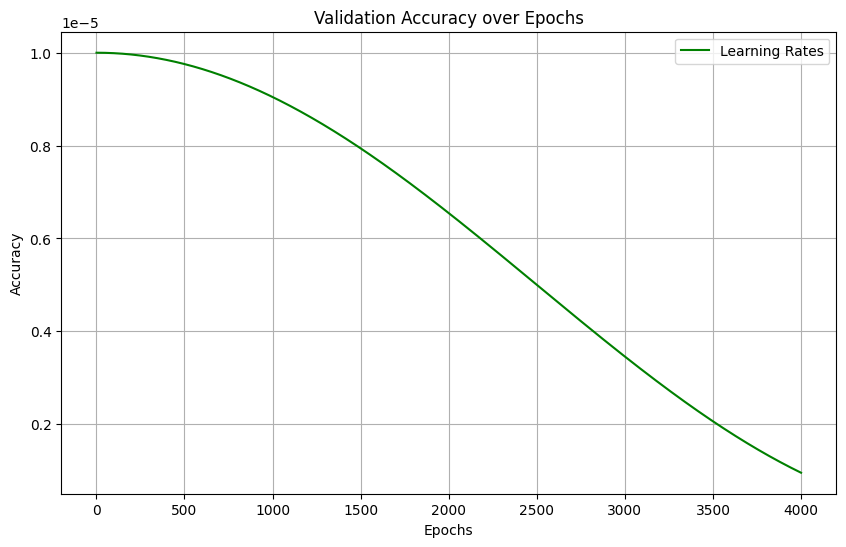

Model for bin 15 saved to GCNModels-5A_exp1/model_bin_15.pth
Training on bin 16/50
Bin 16, Epoch 1/4000, Train Loss: 0.7179, Validation Loss: 0.6888,  Accuracy: 0.7825, LR: 0.000010
Bin 16, Epoch 101/4000, Train Loss: 0.6396, Validation Loss: 0.6490,  Accuracy: 0.7881, LR: 0.000010
Bin 16, Epoch 201/4000, Train Loss: 0.5913, Validation Loss: 0.6014,  Accuracy: 0.7881, LR: 0.000010
Bin 16, Epoch 301/4000, Train Loss: 0.5570, Validation Loss: 0.5275,  Accuracy: 0.8136, LR: 0.000010
Bin 16, Epoch 401/4000, Train Loss: 0.4997, Validation Loss: 0.4778,  Accuracy: 0.8192, LR: 0.000010
Bin 16, Epoch 501/4000, Train Loss: 0.4579, Validation Loss: 0.4434,  Accuracy: 0.8418, LR: 0.000010
Bin 16, Epoch 601/4000, Train Loss: 0.4428, Validation Loss: 0.4049,  Accuracy: 0.8559, LR: 0.000010
Bin 16, Epoch 701/4000, Train Loss: 0.4143, Validation Loss: 0.4163,  Accuracy: 0.8503, LR: 0.000010
Bin 16, Epoch 801/4000, Train Loss: 0.3858, Validation Loss: 0.3942,  Accuracy: 0.8418, LR: 0.000009
Bin 16, Ep

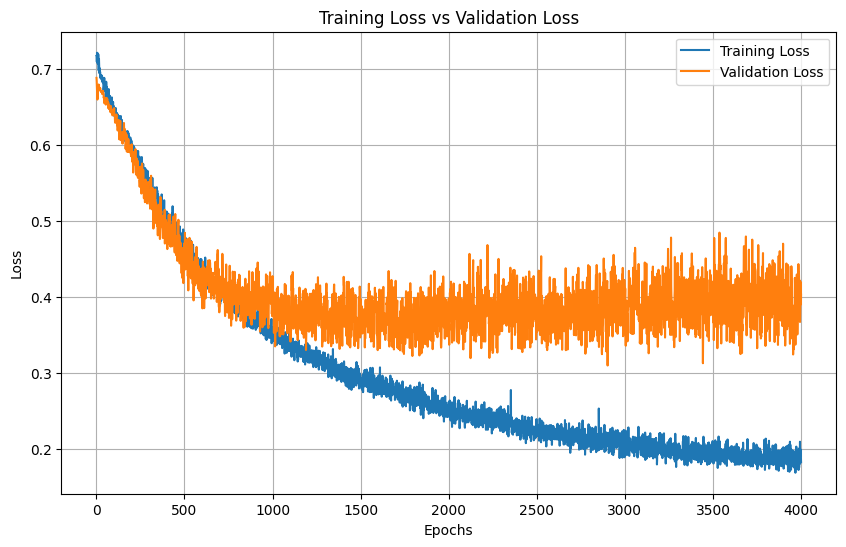

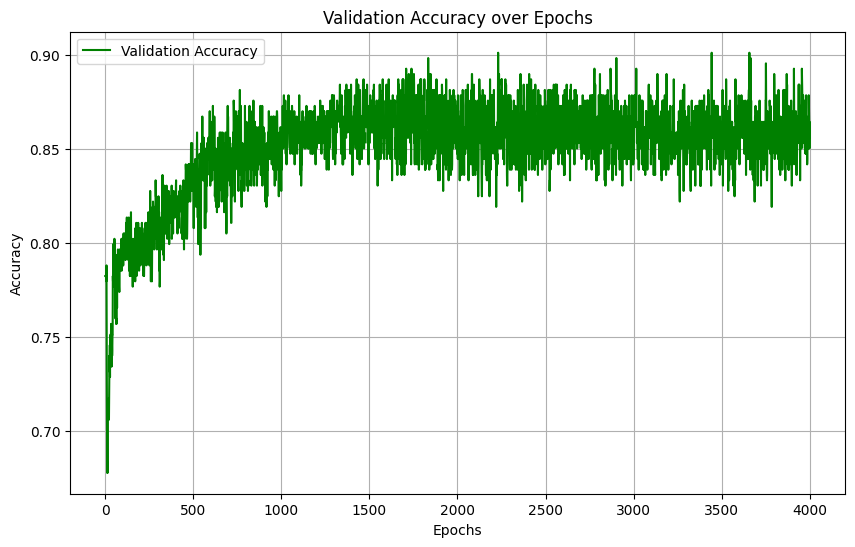

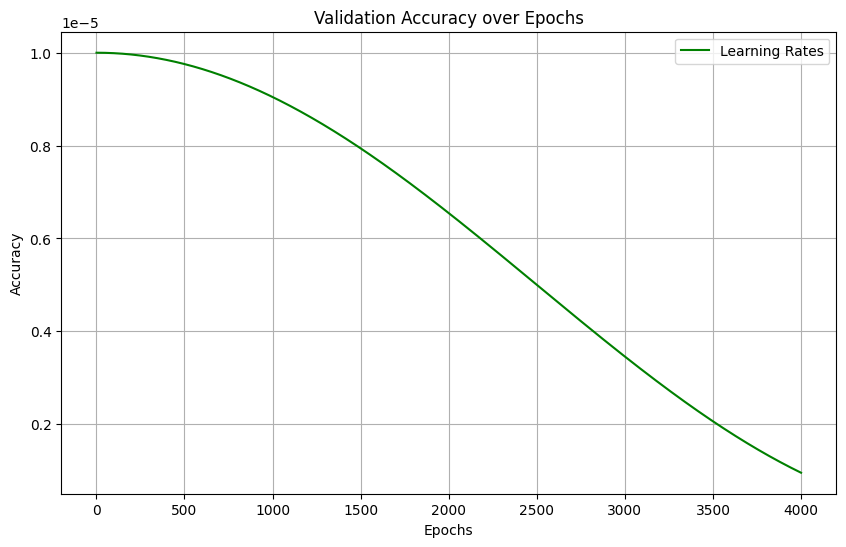

Model for bin 16 saved to GCNModels-5A_exp1/model_bin_16.pth
Training on bin 17/50
Bin 17, Epoch 1/4000, Train Loss: 0.7553, Validation Loss: 0.6693,  Accuracy: 0.7825, LR: 0.000010
Bin 17, Epoch 101/4000, Train Loss: 0.6366, Validation Loss: 0.6390,  Accuracy: 0.8051, LR: 0.000010
Bin 17, Epoch 201/4000, Train Loss: 0.5705, Validation Loss: 0.5723,  Accuracy: 0.8503, LR: 0.000010
Bin 17, Epoch 301/4000, Train Loss: 0.5293, Validation Loss: 0.5458,  Accuracy: 0.8277, LR: 0.000010
Bin 17, Epoch 401/4000, Train Loss: 0.4785, Validation Loss: 0.4696,  Accuracy: 0.8531, LR: 0.000010
Bin 17, Epoch 501/4000, Train Loss: 0.4475, Validation Loss: 0.4751,  Accuracy: 0.8475, LR: 0.000010
Bin 17, Epoch 601/4000, Train Loss: 0.4247, Validation Loss: 0.3818,  Accuracy: 0.8672, LR: 0.000010
Bin 17, Epoch 701/4000, Train Loss: 0.4085, Validation Loss: 0.3529,  Accuracy: 0.8785, LR: 0.000010
Bin 17, Epoch 801/4000, Train Loss: 0.4013, Validation Loss: 0.3907,  Accuracy: 0.8785, LR: 0.000009
Bin 17, Ep

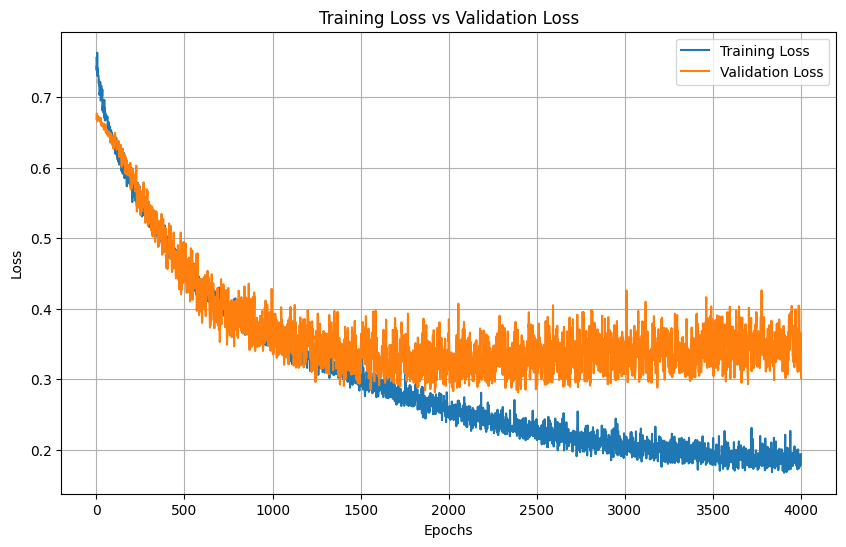

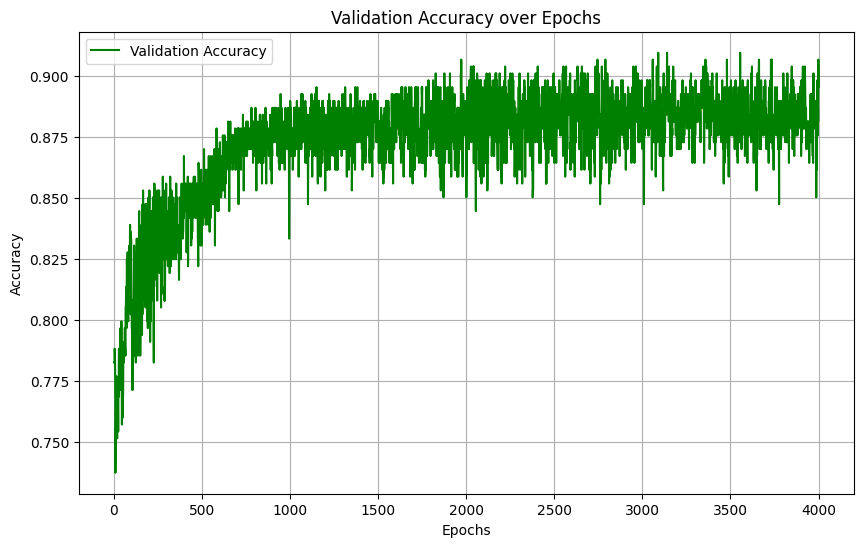

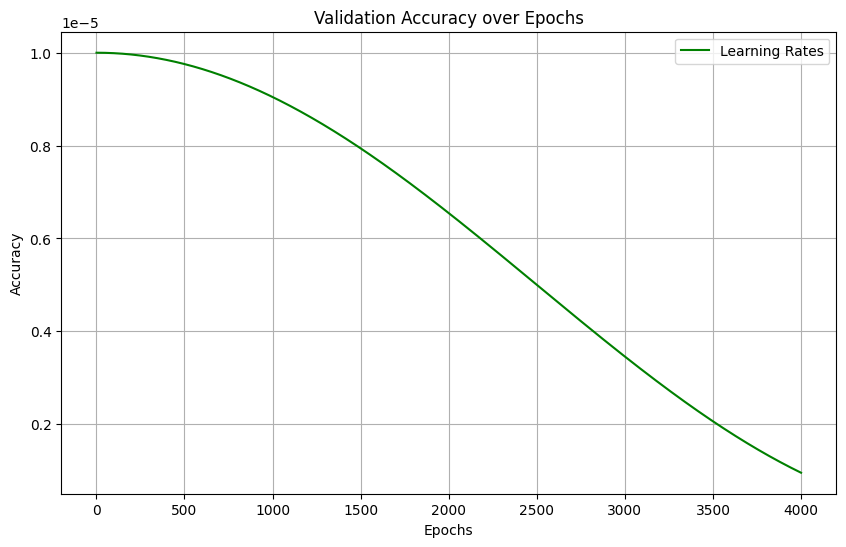

Model for bin 17 saved to GCNModels-5A_exp1/model_bin_17.pth
Training on bin 18/50
Bin 18, Epoch 1/4000, Train Loss: 0.7039, Validation Loss: 0.7159,  Accuracy: 0.2175, LR: 0.000010
Bin 18, Epoch 101/4000, Train Loss: 0.6172, Validation Loss: 0.6472,  Accuracy: 0.6893, LR: 0.000010
Bin 18, Epoch 201/4000, Train Loss: 0.5798, Validation Loss: 0.5926,  Accuracy: 0.7627, LR: 0.000010
Bin 18, Epoch 301/4000, Train Loss: 0.5339, Validation Loss: 0.5265,  Accuracy: 0.7853, LR: 0.000010
Bin 18, Epoch 401/4000, Train Loss: 0.5301, Validation Loss: 0.5297,  Accuracy: 0.7514, LR: 0.000010
Bin 18, Epoch 501/4000, Train Loss: 0.4732, Validation Loss: 0.4336,  Accuracy: 0.8333, LR: 0.000010
Bin 18, Epoch 601/4000, Train Loss: 0.4741, Validation Loss: 0.4417,  Accuracy: 0.8136, LR: 0.000010
Bin 18, Epoch 701/4000, Train Loss: 0.4291, Validation Loss: 0.4529,  Accuracy: 0.7966, LR: 0.000010
Bin 18, Epoch 801/4000, Train Loss: 0.4192, Validation Loss: 0.3928,  Accuracy: 0.8277, LR: 0.000009
Bin 18, Ep

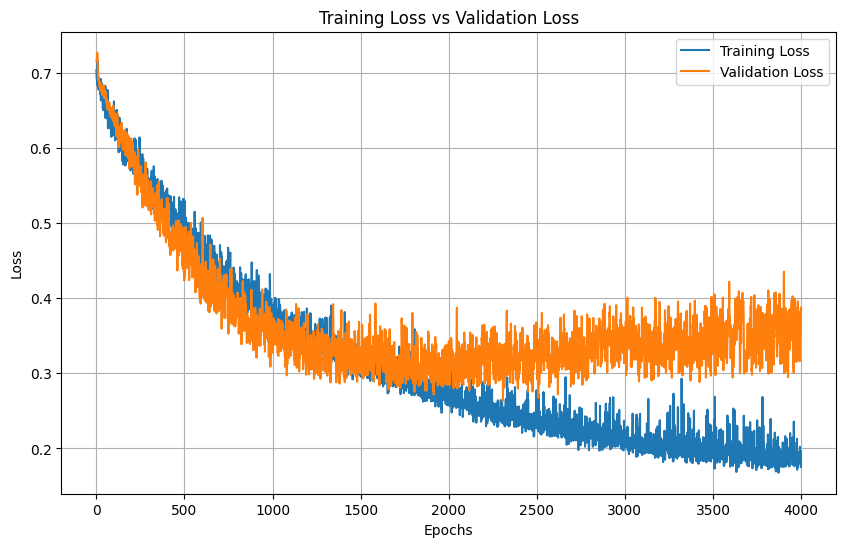

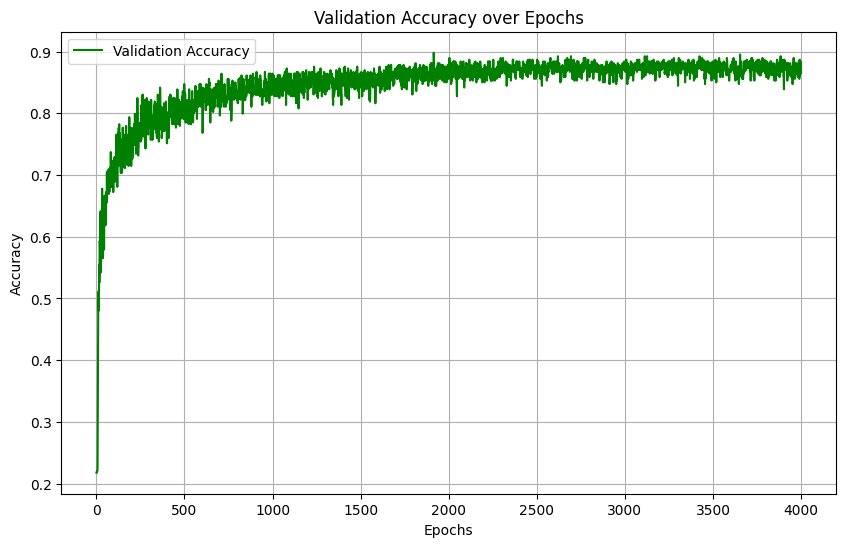

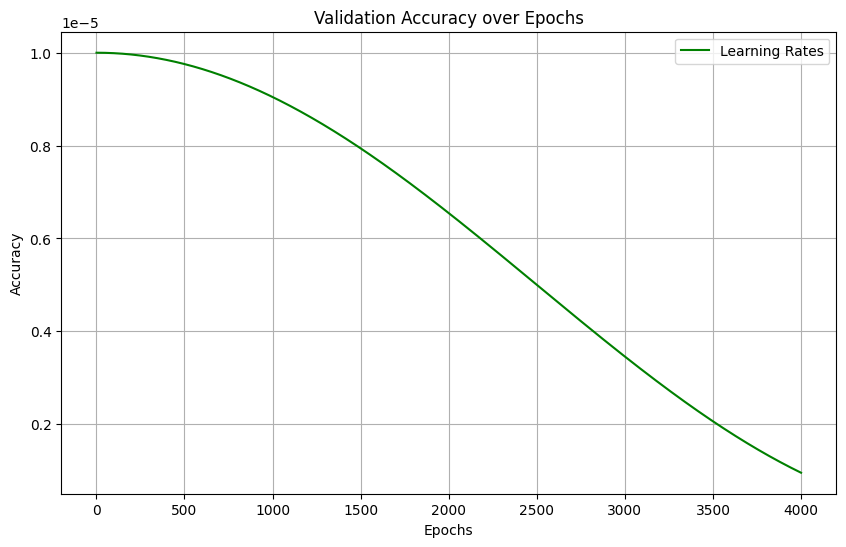

Model for bin 18 saved to GCNModels-5A_exp1/model_bin_18.pth
Training on bin 19/50
Bin 19, Epoch 1/4000, Train Loss: 0.7069, Validation Loss: 0.7166,  Accuracy: 0.2175, LR: 0.000010
Bin 19, Epoch 101/4000, Train Loss: 0.6217, Validation Loss: 0.7047,  Accuracy: 0.5678, LR: 0.000010
Bin 19, Epoch 201/4000, Train Loss: 0.5596, Validation Loss: 0.6392,  Accuracy: 0.8051, LR: 0.000010
Bin 19, Epoch 301/4000, Train Loss: 0.5182, Validation Loss: 0.5846,  Accuracy: 0.8220, LR: 0.000010
Bin 19, Epoch 401/4000, Train Loss: 0.4886, Validation Loss: 0.5028,  Accuracy: 0.8616, LR: 0.000010
Bin 19, Epoch 501/4000, Train Loss: 0.4515, Validation Loss: 0.4890,  Accuracy: 0.8475, LR: 0.000010
Bin 19, Epoch 601/4000, Train Loss: 0.4364, Validation Loss: 0.4478,  Accuracy: 0.8503, LR: 0.000010
Bin 19, Epoch 701/4000, Train Loss: 0.4152, Validation Loss: 0.4201,  Accuracy: 0.8559, LR: 0.000010
Bin 19, Epoch 801/4000, Train Loss: 0.3910, Validation Loss: 0.4331,  Accuracy: 0.8333, LR: 0.000009
Bin 19, Ep

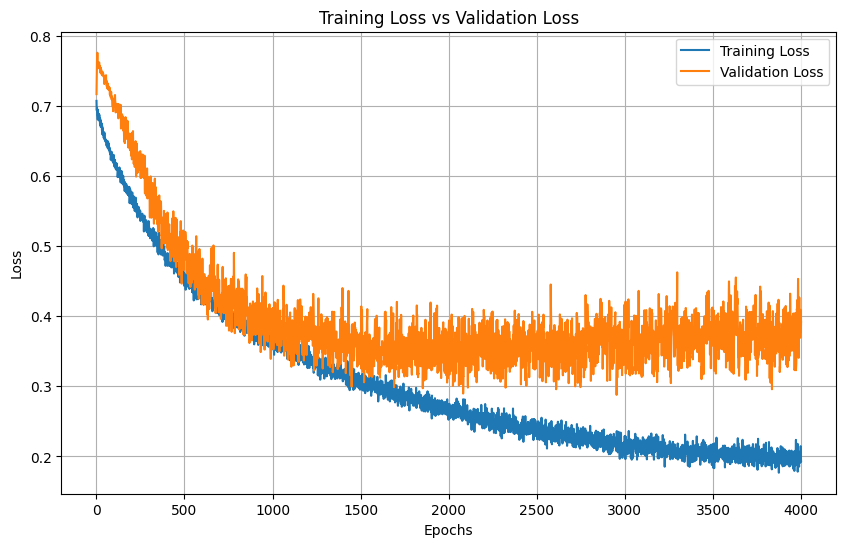

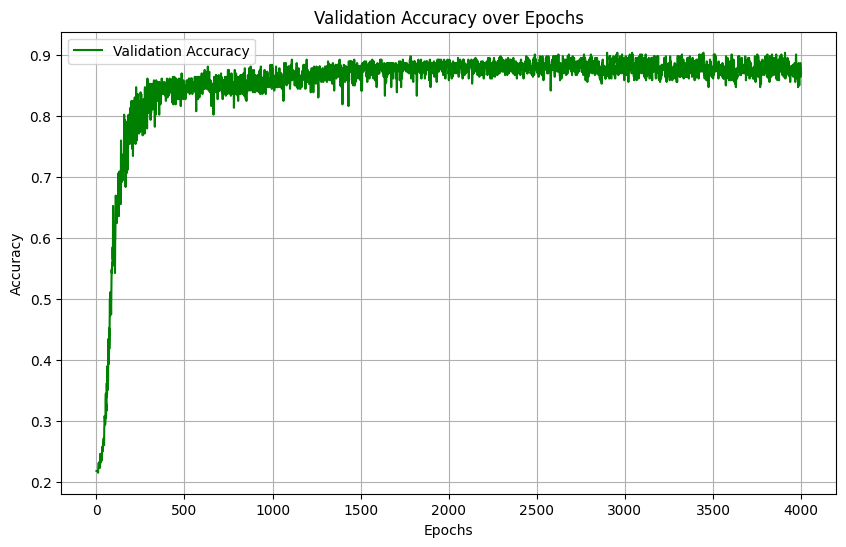

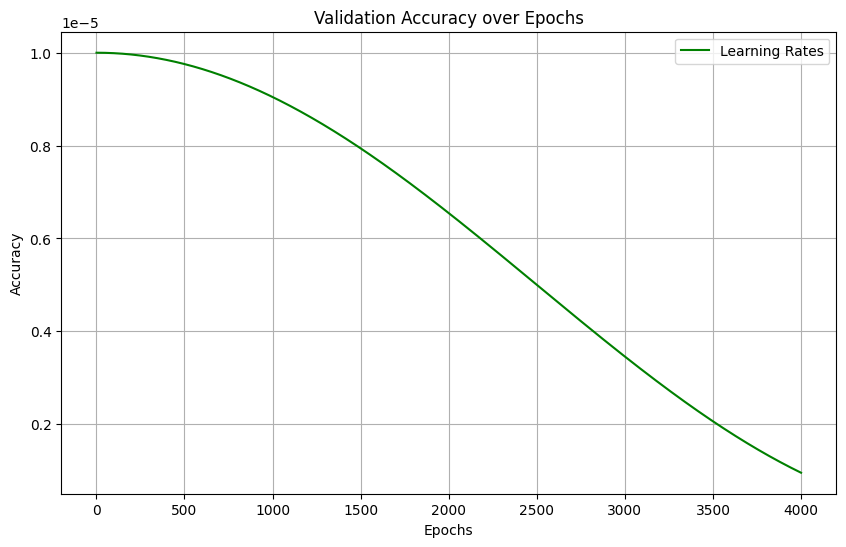

Model for bin 19 saved to GCNModels-5A_exp1/model_bin_19.pth
Training on bin 20/50
Bin 20, Epoch 1/4000, Train Loss: 0.7062, Validation Loss: 0.6922,  Accuracy: 0.7288, LR: 0.000010
Bin 20, Epoch 101/4000, Train Loss: 0.6274, Validation Loss: 0.6414,  Accuracy: 0.7571, LR: 0.000010
Bin 20, Epoch 201/4000, Train Loss: 0.5630, Validation Loss: 0.5746,  Accuracy: 0.8305, LR: 0.000010
Bin 20, Epoch 301/4000, Train Loss: 0.5038, Validation Loss: 0.5041,  Accuracy: 0.8418, LR: 0.000010
Bin 20, Epoch 401/4000, Train Loss: 0.4802, Validation Loss: 0.4966,  Accuracy: 0.8136, LR: 0.000010
Bin 20, Epoch 501/4000, Train Loss: 0.4381, Validation Loss: 0.4410,  Accuracy: 0.8333, LR: 0.000010
Bin 20, Epoch 601/4000, Train Loss: 0.4124, Validation Loss: 0.3958,  Accuracy: 0.8588, LR: 0.000010
Bin 20, Epoch 701/4000, Train Loss: 0.4035, Validation Loss: 0.4009,  Accuracy: 0.8531, LR: 0.000010
Bin 20, Epoch 801/4000, Train Loss: 0.3890, Validation Loss: 0.3783,  Accuracy: 0.8531, LR: 0.000009
Bin 20, Ep

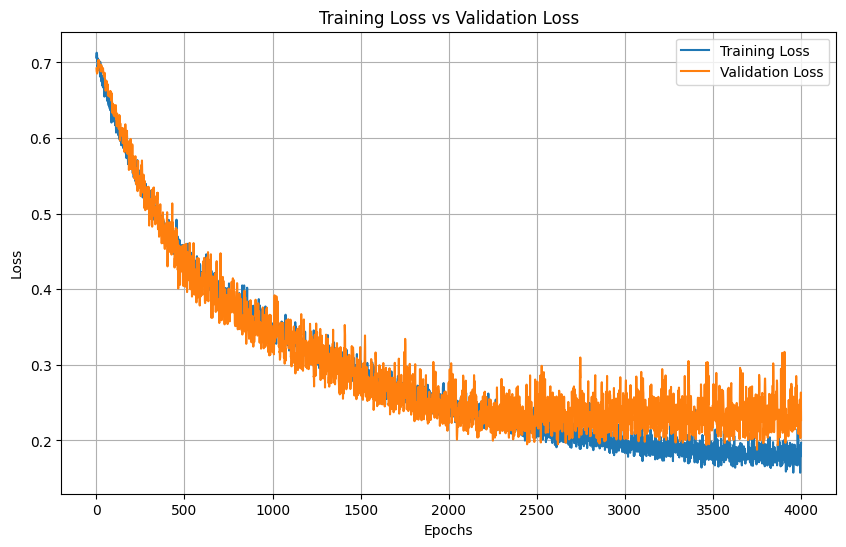

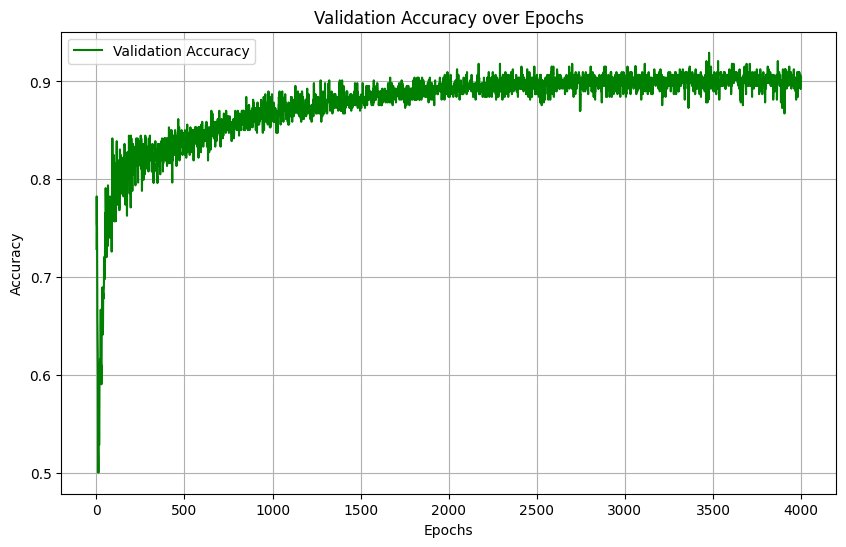

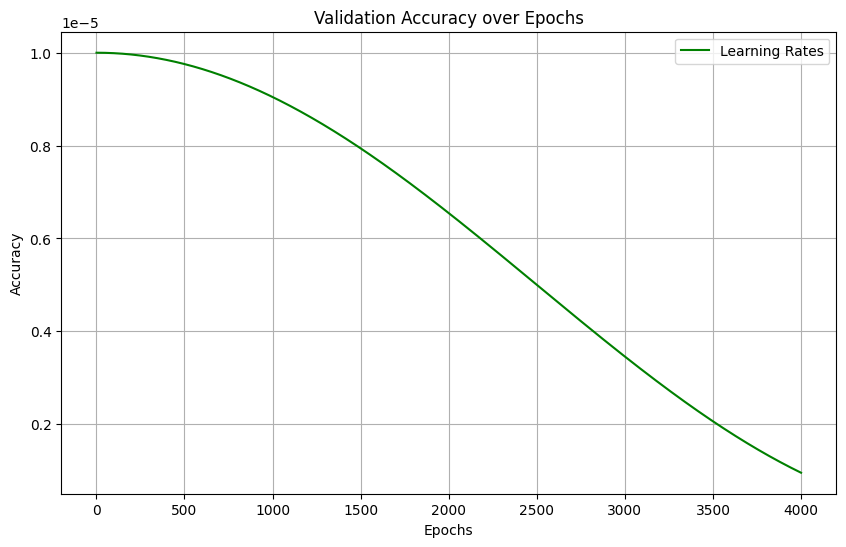

Model for bin 20 saved to GCNModels-5A_exp1/model_bin_20.pth
Training on bin 21/50
Bin 21, Epoch 1/4000, Train Loss: 0.7121, Validation Loss: 0.7150,  Accuracy: 0.2175, LR: 0.000010
Bin 21, Epoch 101/4000, Train Loss: 0.6485, Validation Loss: 0.6577,  Accuracy: 0.7260, LR: 0.000010
Bin 21, Epoch 201/4000, Train Loss: 0.5791, Validation Loss: 0.5792,  Accuracy: 0.8192, LR: 0.000010
Bin 21, Epoch 301/4000, Train Loss: 0.5494, Validation Loss: 0.5398,  Accuracy: 0.7910, LR: 0.000010
Bin 21, Epoch 401/4000, Train Loss: 0.4936, Validation Loss: 0.4930,  Accuracy: 0.7994, LR: 0.000010
Bin 21, Epoch 501/4000, Train Loss: 0.4659, Validation Loss: 0.4625,  Accuracy: 0.8277, LR: 0.000010
Bin 21, Epoch 601/4000, Train Loss: 0.4276, Validation Loss: 0.4244,  Accuracy: 0.8418, LR: 0.000010
Bin 21, Epoch 701/4000, Train Loss: 0.4186, Validation Loss: 0.4209,  Accuracy: 0.8390, LR: 0.000010
Bin 21, Epoch 801/4000, Train Loss: 0.3915, Validation Loss: 0.3871,  Accuracy: 0.8644, LR: 0.000009
Bin 21, Ep

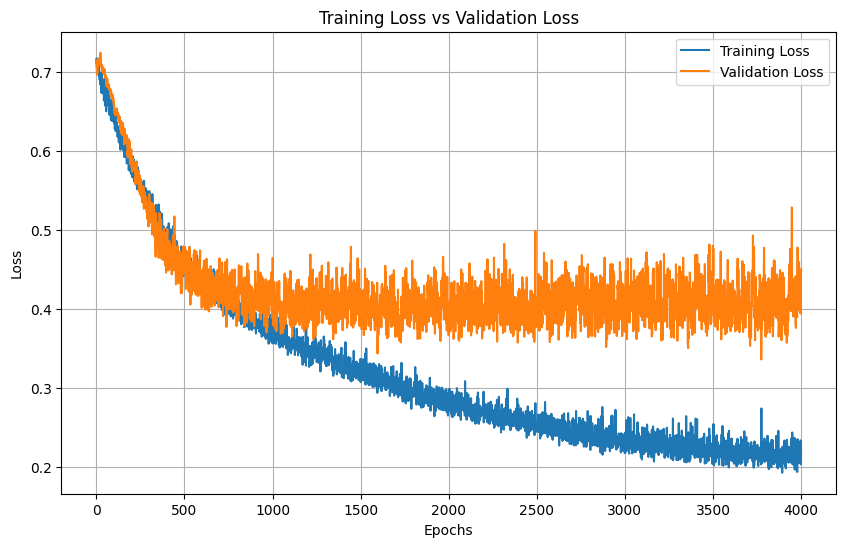

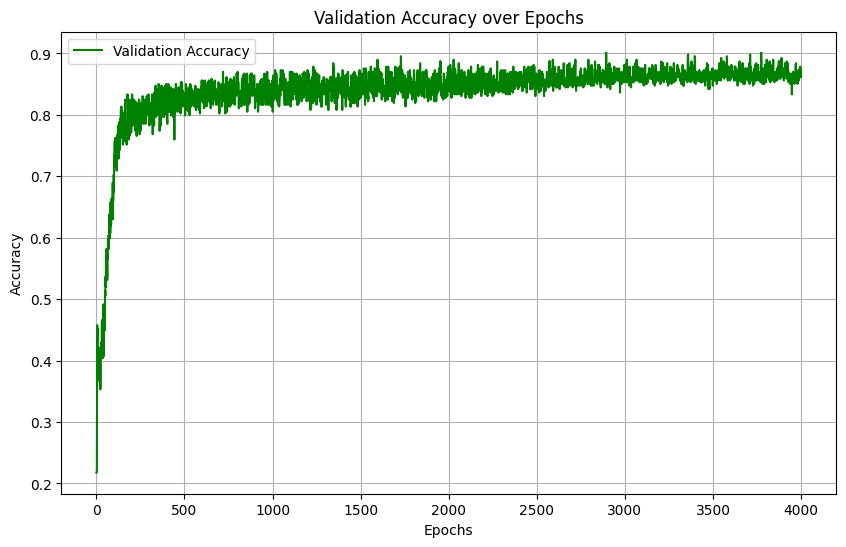

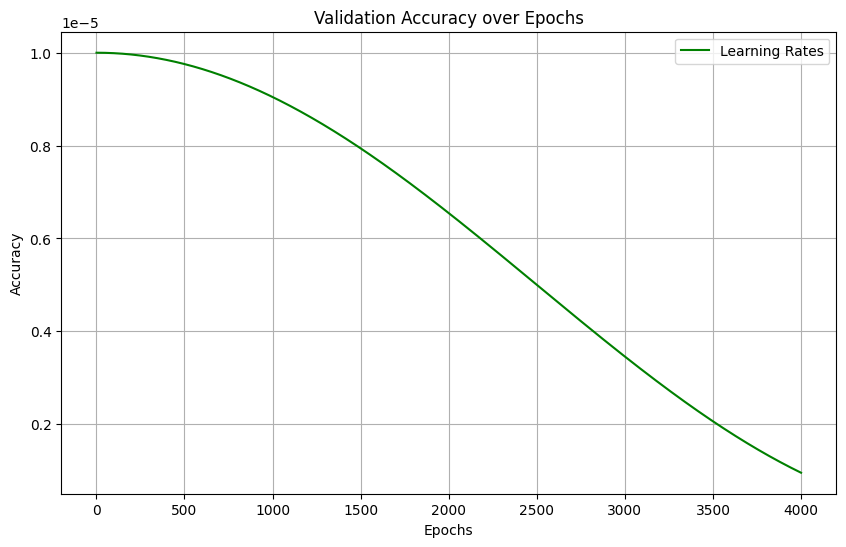

Model for bin 21 saved to GCNModels-5A_exp1/model_bin_21.pth
Training on bin 22/50
Bin 22, Epoch 1/4000, Train Loss: 0.7058, Validation Loss: 0.7188,  Accuracy: 0.2175, LR: 0.000010
Bin 22, Epoch 101/4000, Train Loss: 0.6322, Validation Loss: 0.6689,  Accuracy: 0.5819, LR: 0.000010
Bin 22, Epoch 201/4000, Train Loss: 0.5753, Validation Loss: 0.5895,  Accuracy: 0.7768, LR: 0.000010
Bin 22, Epoch 301/4000, Train Loss: 0.5162, Validation Loss: 0.5485,  Accuracy: 0.7994, LR: 0.000010
Bin 22, Epoch 401/4000, Train Loss: 0.4918, Validation Loss: 0.5195,  Accuracy: 0.7994, LR: 0.000010
Bin 22, Epoch 501/4000, Train Loss: 0.4561, Validation Loss: 0.4715,  Accuracy: 0.8277, LR: 0.000010
Bin 22, Epoch 601/4000, Train Loss: 0.4265, Validation Loss: 0.4488,  Accuracy: 0.8418, LR: 0.000010
Bin 22, Epoch 701/4000, Train Loss: 0.4155, Validation Loss: 0.4134,  Accuracy: 0.8531, LR: 0.000010
Bin 22, Epoch 801/4000, Train Loss: 0.3916, Validation Loss: 0.3811,  Accuracy: 0.8729, LR: 0.000009
Bin 22, Ep

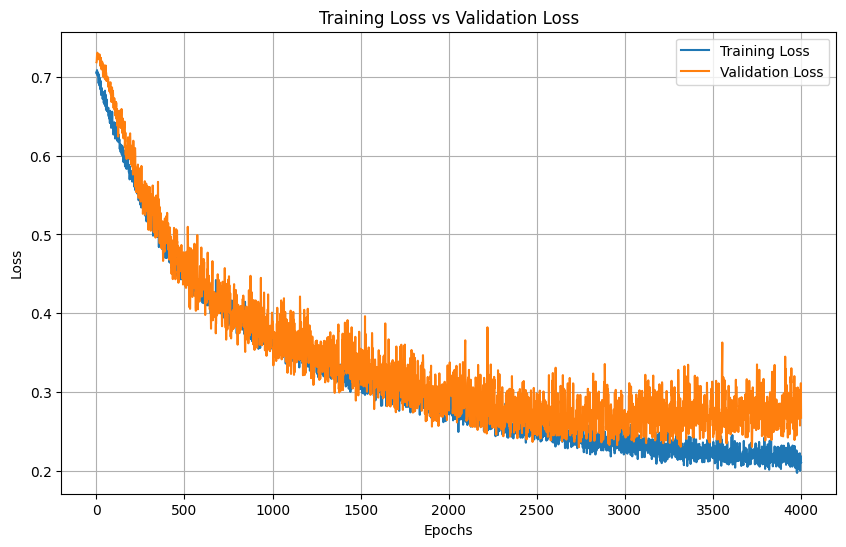

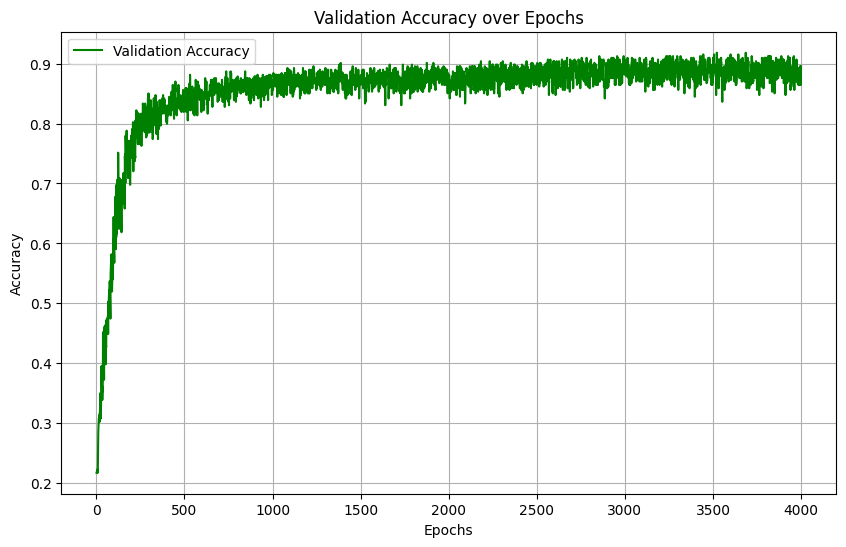

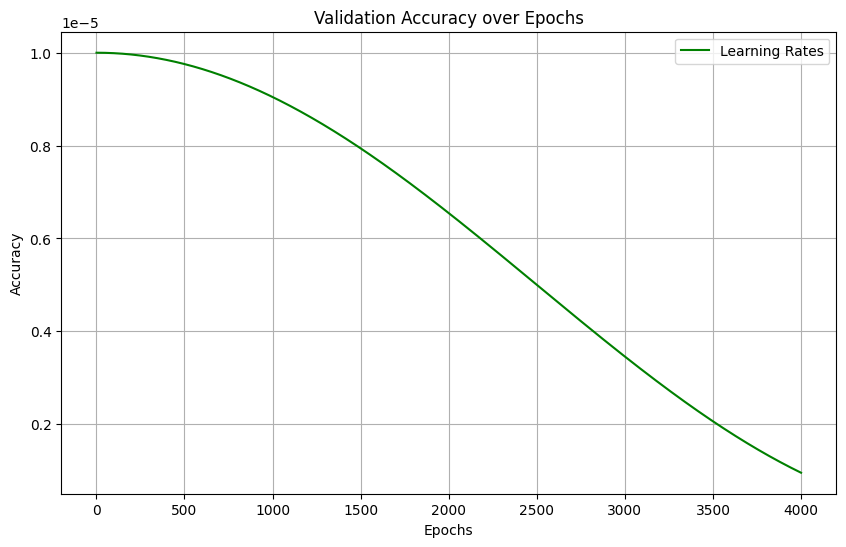

Model for bin 22 saved to GCNModels-5A_exp1/model_bin_22.pth
Training on bin 23/50
Bin 23, Epoch 1/4000, Train Loss: 0.6884, Validation Loss: 0.7171,  Accuracy: 0.2175, LR: 0.000010
Bin 23, Epoch 101/4000, Train Loss: 0.6148, Validation Loss: 0.6475,  Accuracy: 0.7203, LR: 0.000010
Bin 23, Epoch 201/4000, Train Loss: 0.5595, Validation Loss: 0.5703,  Accuracy: 0.7938, LR: 0.000010
Bin 23, Epoch 301/4000, Train Loss: 0.5105, Validation Loss: 0.4952,  Accuracy: 0.8277, LR: 0.000010
Bin 23, Epoch 401/4000, Train Loss: 0.4619, Validation Loss: 0.4222,  Accuracy: 0.8559, LR: 0.000010
Bin 23, Epoch 501/4000, Train Loss: 0.4326, Validation Loss: 0.4413,  Accuracy: 0.8333, LR: 0.000010
Bin 23, Epoch 601/4000, Train Loss: 0.3922, Validation Loss: 0.4312,  Accuracy: 0.8333, LR: 0.000010
Bin 23, Epoch 701/4000, Train Loss: 0.3816, Validation Loss: 0.4285,  Accuracy: 0.8220, LR: 0.000010
Bin 23, Epoch 801/4000, Train Loss: 0.3699, Validation Loss: 0.3868,  Accuracy: 0.8418, LR: 0.000009
Bin 23, Ep

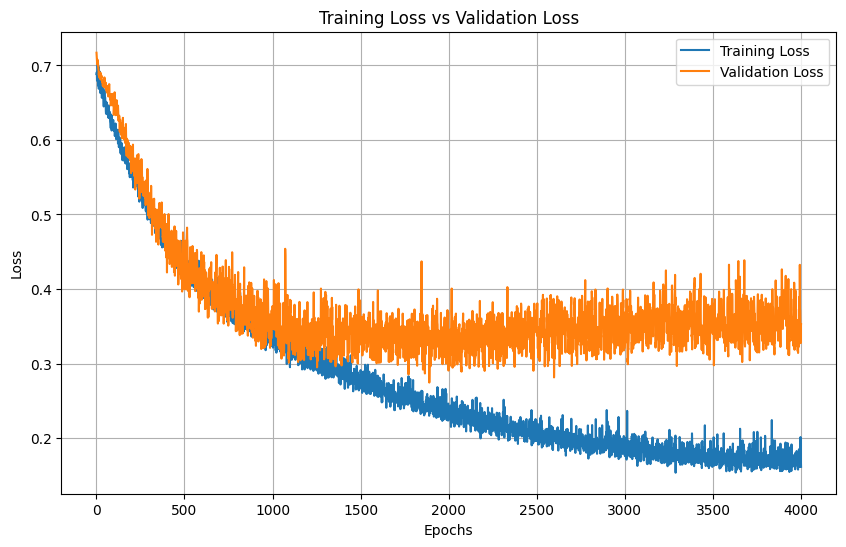

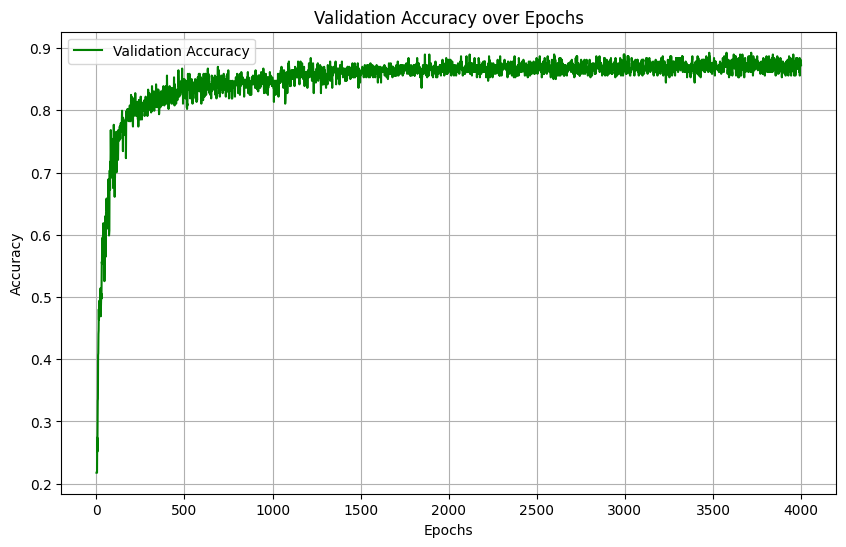

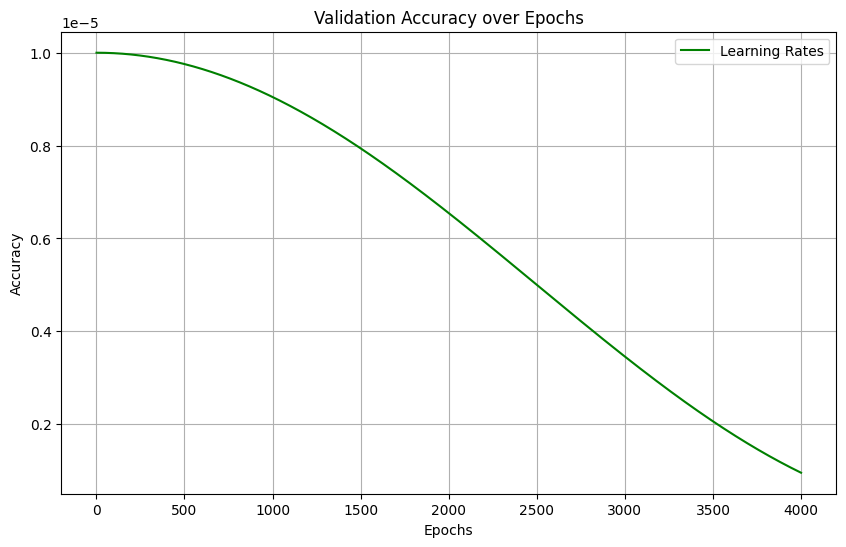

Model for bin 23 saved to GCNModels-5A_exp1/model_bin_23.pth
Training on bin 24/50
Bin 24, Epoch 1/4000, Train Loss: 0.6995, Validation Loss: 0.6618,  Accuracy: 0.7825, LR: 0.000010
Bin 24, Epoch 101/4000, Train Loss: 0.6457, Validation Loss: 0.6405,  Accuracy: 0.7797, LR: 0.000010
Bin 24, Epoch 201/4000, Train Loss: 0.6010, Validation Loss: 0.6064,  Accuracy: 0.7994, LR: 0.000010
Bin 24, Epoch 301/4000, Train Loss: 0.5357, Validation Loss: 0.5531,  Accuracy: 0.8220, LR: 0.000010
Bin 24, Epoch 401/4000, Train Loss: 0.5186, Validation Loss: 0.5361,  Accuracy: 0.8277, LR: 0.000010
Bin 24, Epoch 501/4000, Train Loss: 0.4721, Validation Loss: 0.4717,  Accuracy: 0.8362, LR: 0.000010
Bin 24, Epoch 601/4000, Train Loss: 0.4282, Validation Loss: 0.4620,  Accuracy: 0.8277, LR: 0.000010
Bin 24, Epoch 701/4000, Train Loss: 0.4006, Validation Loss: 0.4227,  Accuracy: 0.8418, LR: 0.000010
Bin 24, Epoch 801/4000, Train Loss: 0.3853, Validation Loss: 0.3929,  Accuracy: 0.8531, LR: 0.000009
Bin 24, Ep

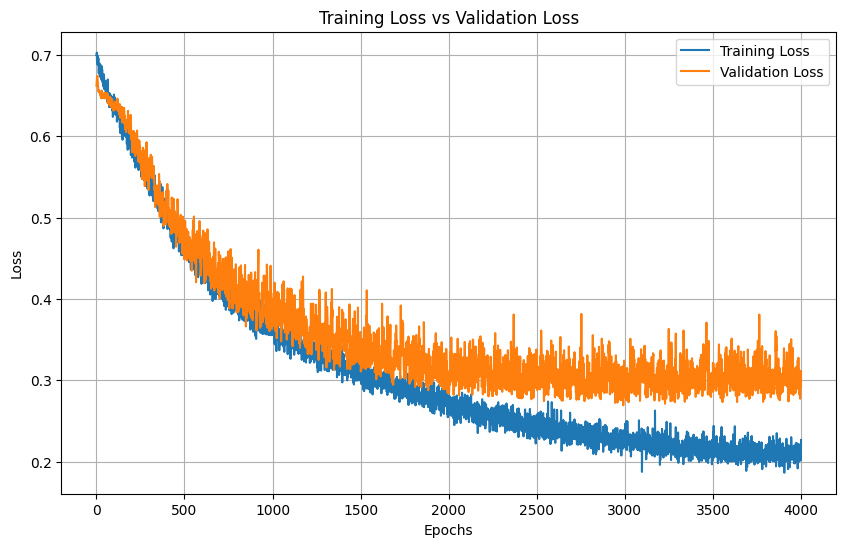

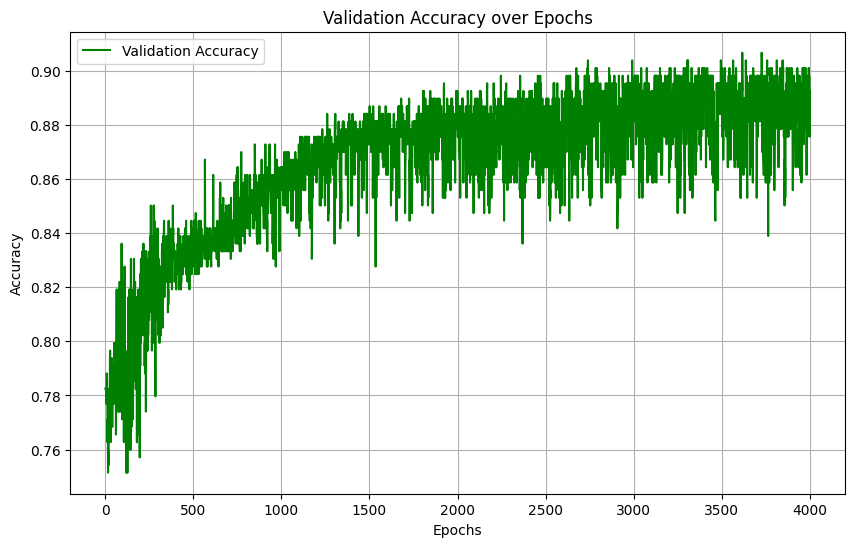

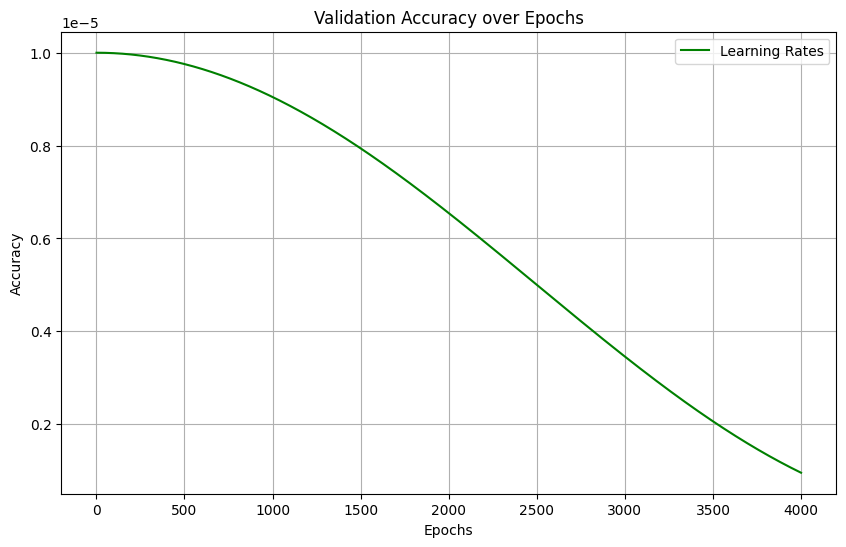

Model for bin 24 saved to GCNModels-5A_exp1/model_bin_24.pth
Training on bin 25/50
Bin 25, Epoch 1/4000, Train Loss: 0.6963, Validation Loss: 0.6720,  Accuracy: 0.7825, LR: 0.000010
Bin 25, Epoch 101/4000, Train Loss: 0.6241, Validation Loss: 0.6434,  Accuracy: 0.7684, LR: 0.000010
Bin 25, Epoch 201/4000, Train Loss: 0.5633, Validation Loss: 0.5966,  Accuracy: 0.7881, LR: 0.000010
Bin 25, Epoch 301/4000, Train Loss: 0.5160, Validation Loss: 0.5438,  Accuracy: 0.8107, LR: 0.000010
Bin 25, Epoch 401/4000, Train Loss: 0.4828, Validation Loss: 0.5048,  Accuracy: 0.8220, LR: 0.000010
Bin 25, Epoch 501/4000, Train Loss: 0.4479, Validation Loss: 0.4180,  Accuracy: 0.8362, LR: 0.000010
Bin 25, Epoch 601/4000, Train Loss: 0.4173, Validation Loss: 0.4014,  Accuracy: 0.8390, LR: 0.000010
Bin 25, Epoch 701/4000, Train Loss: 0.3974, Validation Loss: 0.4323,  Accuracy: 0.8418, LR: 0.000010
Bin 25, Epoch 801/4000, Train Loss: 0.3719, Validation Loss: 0.3650,  Accuracy: 0.8588, LR: 0.000009
Bin 25, Ep

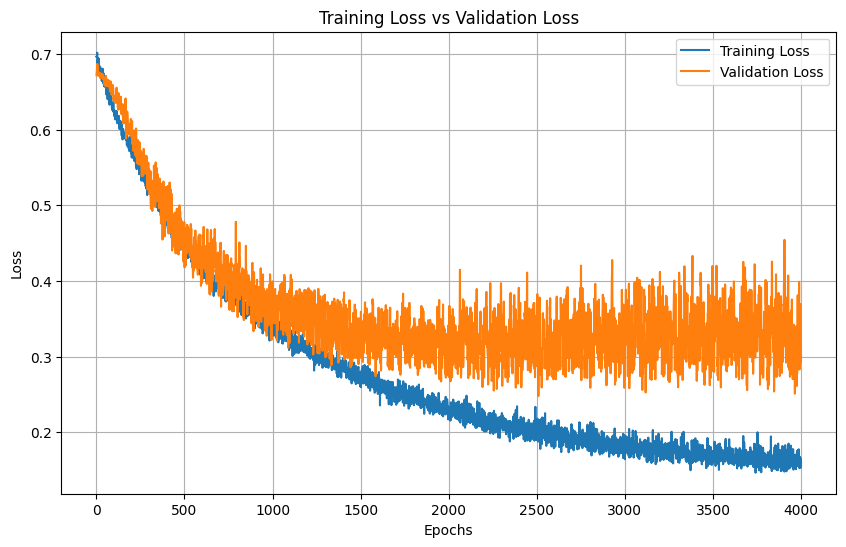

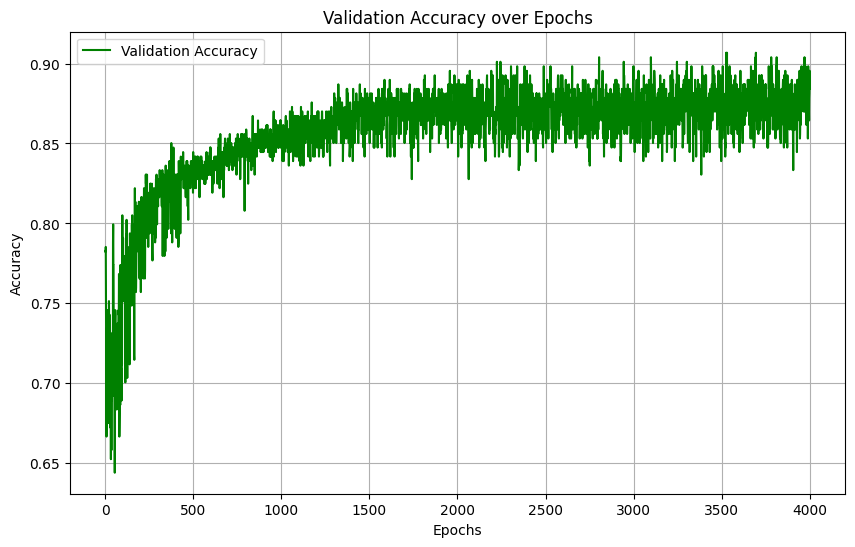

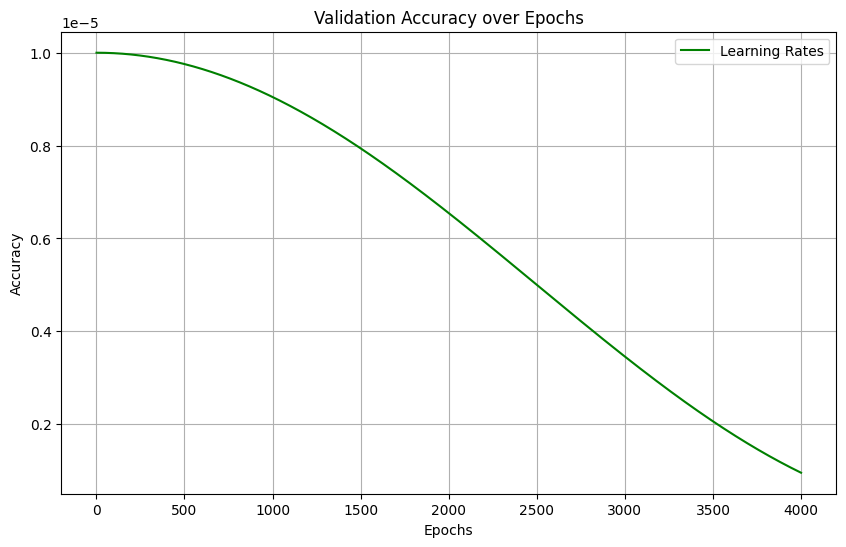

Model for bin 25 saved to GCNModels-5A_exp1/model_bin_25.pth
Training on bin 26/50
Bin 26, Epoch 1/4000, Train Loss: 0.7393, Validation Loss: 0.6791,  Accuracy: 0.7825, LR: 0.000010
Bin 26, Epoch 101/4000, Train Loss: 0.6338, Validation Loss: 0.6423,  Accuracy: 0.7571, LR: 0.000010
Bin 26, Epoch 201/4000, Train Loss: 0.5785, Validation Loss: 0.5784,  Accuracy: 0.8136, LR: 0.000010
Bin 26, Epoch 301/4000, Train Loss: 0.5132, Validation Loss: 0.5577,  Accuracy: 0.8051, LR: 0.000010
Bin 26, Epoch 401/4000, Train Loss: 0.4816, Validation Loss: 0.5211,  Accuracy: 0.8051, LR: 0.000010
Bin 26, Epoch 501/4000, Train Loss: 0.4591, Validation Loss: 0.4398,  Accuracy: 0.8588, LR: 0.000010
Bin 26, Epoch 601/4000, Train Loss: 0.4196, Validation Loss: 0.4400,  Accuracy: 0.8362, LR: 0.000010
Bin 26, Epoch 701/4000, Train Loss: 0.3911, Validation Loss: 0.4515,  Accuracy: 0.8136, LR: 0.000010
Bin 26, Epoch 801/4000, Train Loss: 0.3750, Validation Loss: 0.4220,  Accuracy: 0.8305, LR: 0.000009
Bin 26, Ep

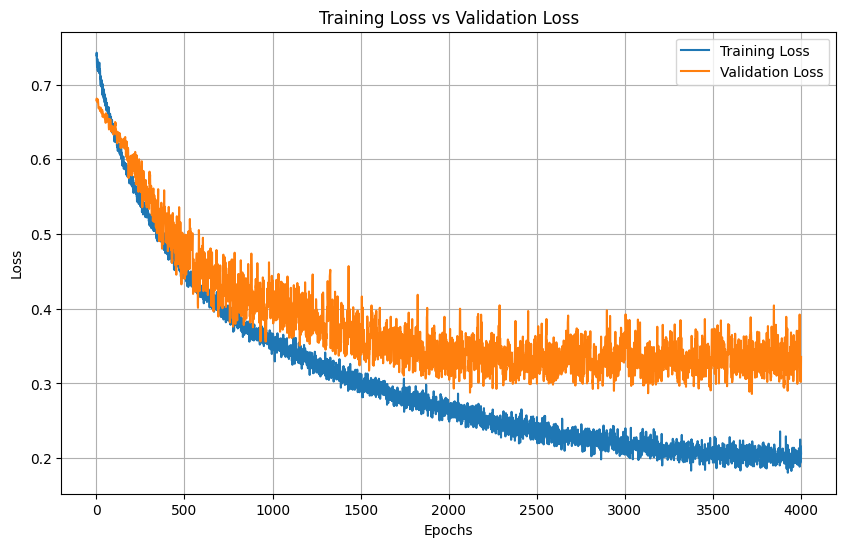

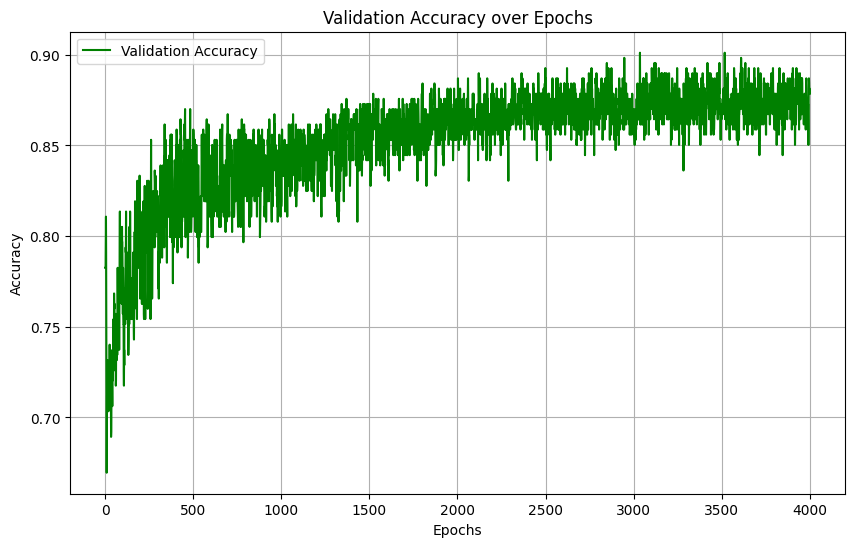

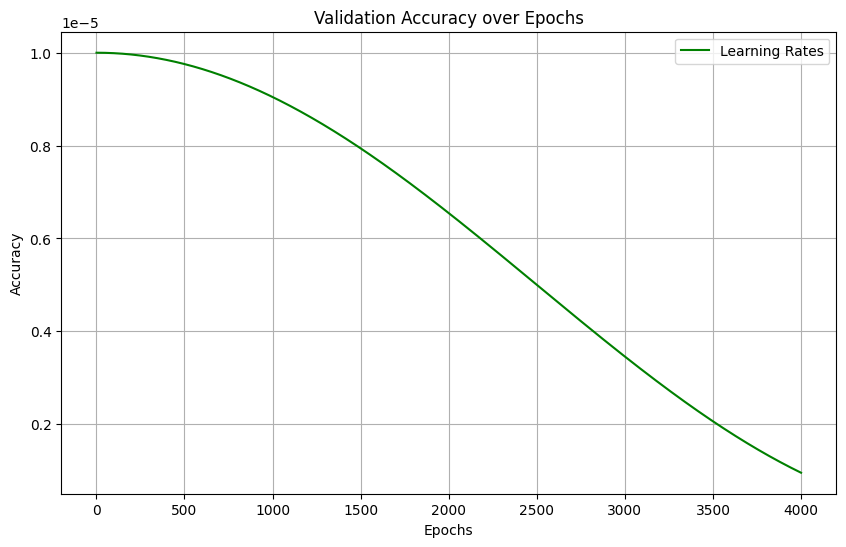

Model for bin 26 saved to GCNModels-5A_exp1/model_bin_26.pth
Training on bin 27/50
Bin 27, Epoch 1/4000, Train Loss: 0.6998, Validation Loss: 0.6613,  Accuracy: 0.7825, LR: 0.000010
Bin 27, Epoch 101/4000, Train Loss: 0.5992, Validation Loss: 0.5918,  Accuracy: 0.8107, LR: 0.000010
Bin 27, Epoch 201/4000, Train Loss: 0.5542, Validation Loss: 0.5658,  Accuracy: 0.7825, LR: 0.000010
Bin 27, Epoch 301/4000, Train Loss: 0.5049, Validation Loss: 0.4862,  Accuracy: 0.8164, LR: 0.000010
Bin 27, Epoch 401/4000, Train Loss: 0.4641, Validation Loss: 0.4712,  Accuracy: 0.8249, LR: 0.000010
Bin 27, Epoch 501/4000, Train Loss: 0.4258, Validation Loss: 0.4630,  Accuracy: 0.8107, LR: 0.000010
Bin 27, Epoch 601/4000, Train Loss: 0.4001, Validation Loss: 0.4332,  Accuracy: 0.8079, LR: 0.000010
Bin 27, Epoch 701/4000, Train Loss: 0.3766, Validation Loss: 0.3586,  Accuracy: 0.8616, LR: 0.000010
Bin 27, Epoch 801/4000, Train Loss: 0.3355, Validation Loss: 0.3822,  Accuracy: 0.8362, LR: 0.000009
Bin 27, Ep

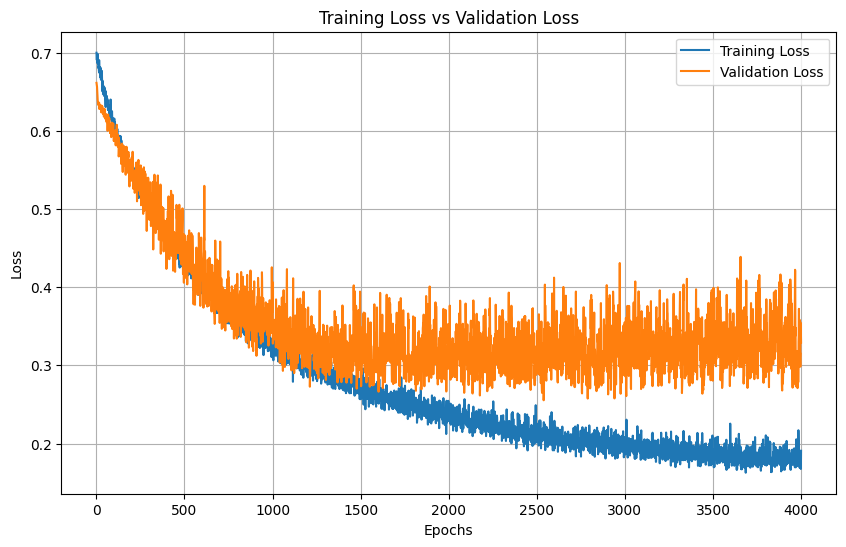

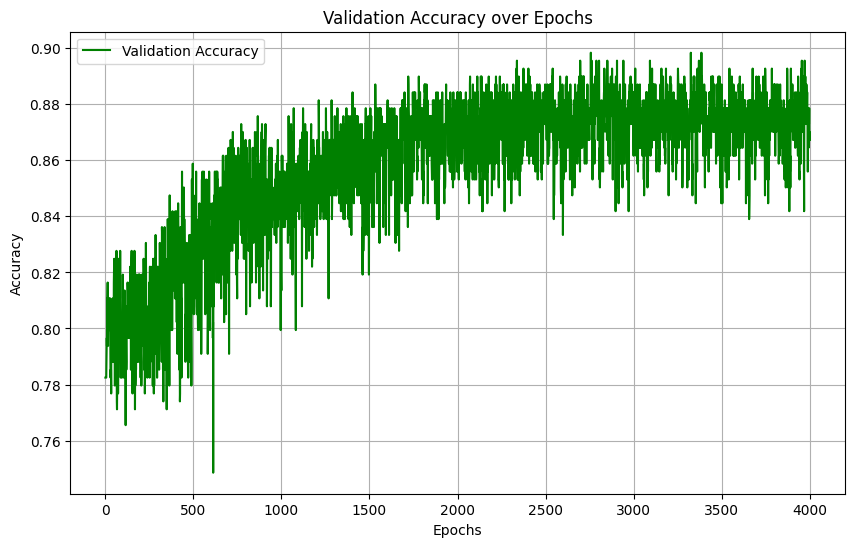

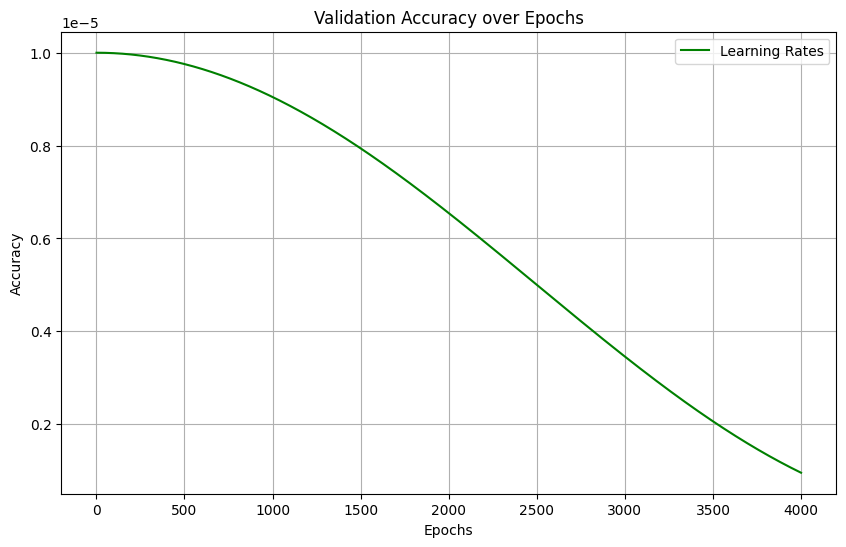

Model for bin 27 saved to GCNModels-5A_exp1/model_bin_27.pth
Training on bin 28/50
Bin 28, Epoch 1/4000, Train Loss: 0.7249, Validation Loss: 0.7223,  Accuracy: 0.2175, LR: 0.000010
Bin 28, Epoch 101/4000, Train Loss: 0.6550, Validation Loss: 0.6760,  Accuracy: 0.7034, LR: 0.000010
Bin 28, Epoch 201/4000, Train Loss: 0.6047, Validation Loss: 0.6238,  Accuracy: 0.7712, LR: 0.000010
Bin 28, Epoch 301/4000, Train Loss: 0.5564, Validation Loss: 0.5561,  Accuracy: 0.8023, LR: 0.000010
Bin 28, Epoch 401/4000, Train Loss: 0.5295, Validation Loss: 0.4854,  Accuracy: 0.8333, LR: 0.000010
Bin 28, Epoch 501/4000, Train Loss: 0.4666, Validation Loss: 0.4532,  Accuracy: 0.8277, LR: 0.000010
Bin 28, Epoch 601/4000, Train Loss: 0.4230, Validation Loss: 0.4427,  Accuracy: 0.8192, LR: 0.000010
Bin 28, Epoch 701/4000, Train Loss: 0.4111, Validation Loss: 0.3735,  Accuracy: 0.8418, LR: 0.000010
Bin 28, Epoch 801/4000, Train Loss: 0.3859, Validation Loss: 0.3599,  Accuracy: 0.8390, LR: 0.000009
Bin 28, Ep

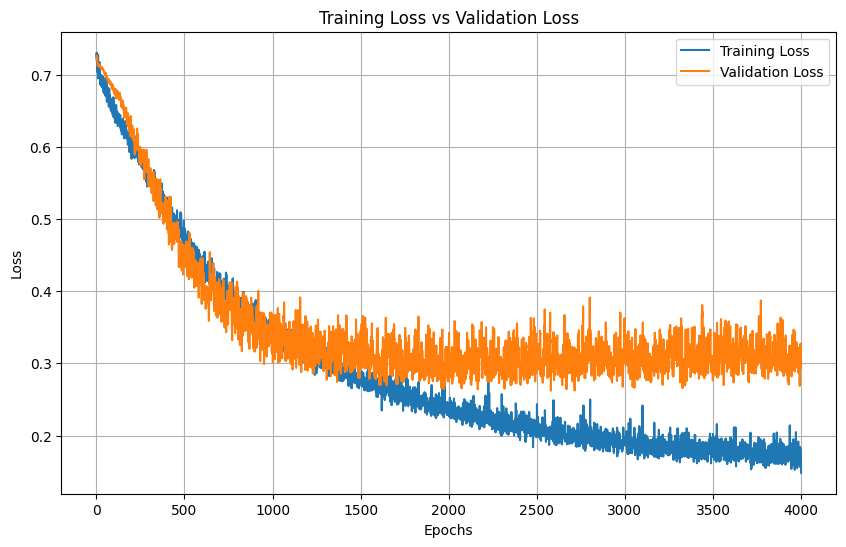

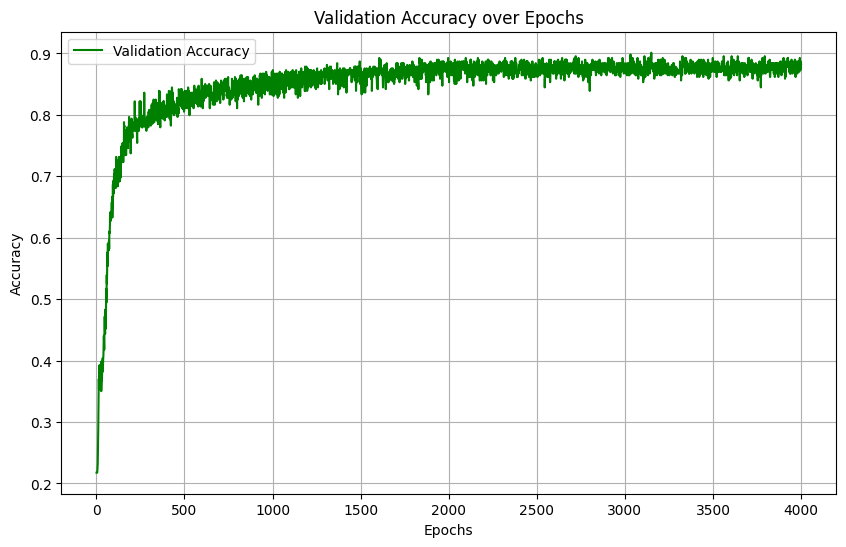

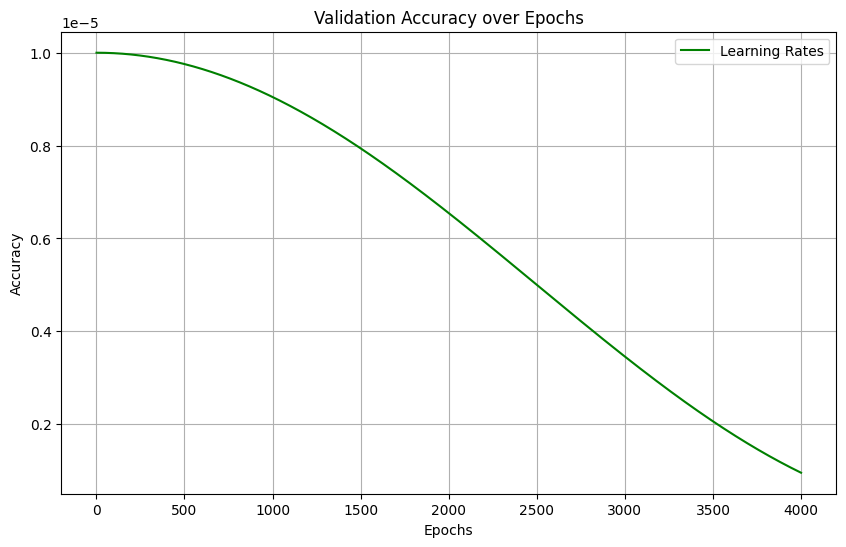

Model for bin 28 saved to GCNModels-5A_exp1/model_bin_28.pth
Training on bin 29/50
Bin 29, Epoch 1/4000, Train Loss: 0.7040, Validation Loss: 0.6845,  Accuracy: 0.7825, LR: 0.000010
Bin 29, Epoch 101/4000, Train Loss: 0.6360, Validation Loss: 0.6144,  Accuracy: 0.7881, LR: 0.000010
Bin 29, Epoch 201/4000, Train Loss: 0.5900, Validation Loss: 0.5725,  Accuracy: 0.7938, LR: 0.000010
Bin 29, Epoch 301/4000, Train Loss: 0.5550, Validation Loss: 0.5178,  Accuracy: 0.8192, LR: 0.000010
Bin 29, Epoch 401/4000, Train Loss: 0.5138, Validation Loss: 0.5017,  Accuracy: 0.8277, LR: 0.000010
Bin 29, Epoch 501/4000, Train Loss: 0.4687, Validation Loss: 0.4426,  Accuracy: 0.8616, LR: 0.000010
Bin 29, Epoch 601/4000, Train Loss: 0.4274, Validation Loss: 0.4597,  Accuracy: 0.8503, LR: 0.000010
Bin 29, Epoch 701/4000, Train Loss: 0.4259, Validation Loss: 0.4264,  Accuracy: 0.8559, LR: 0.000010
Bin 29, Epoch 801/4000, Train Loss: 0.3827, Validation Loss: 0.4278,  Accuracy: 0.8588, LR: 0.000009
Bin 29, Ep

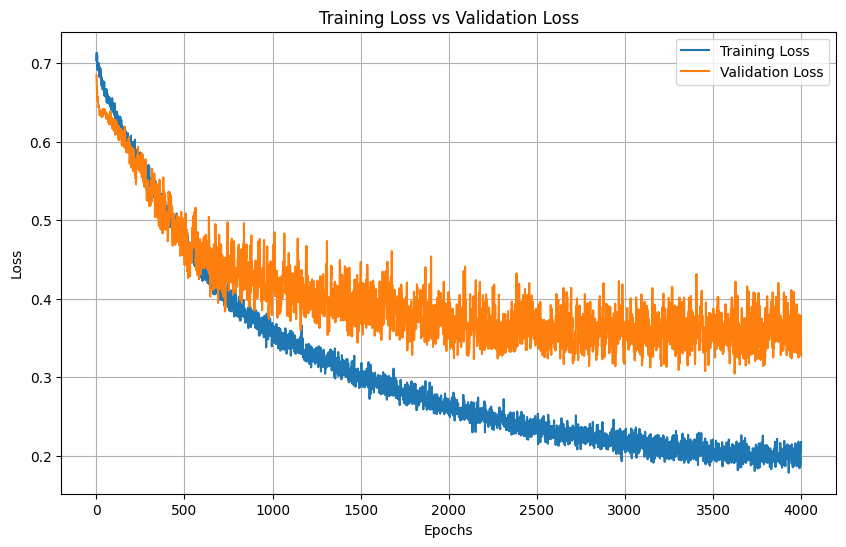

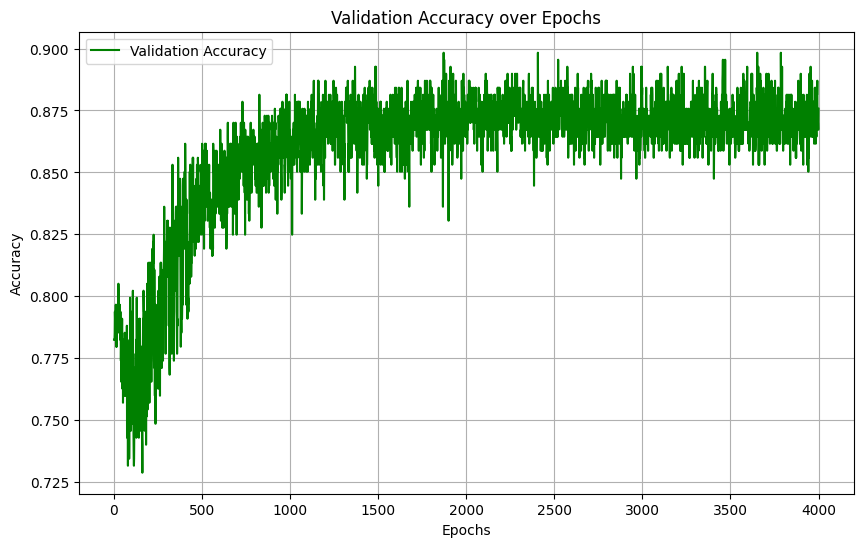

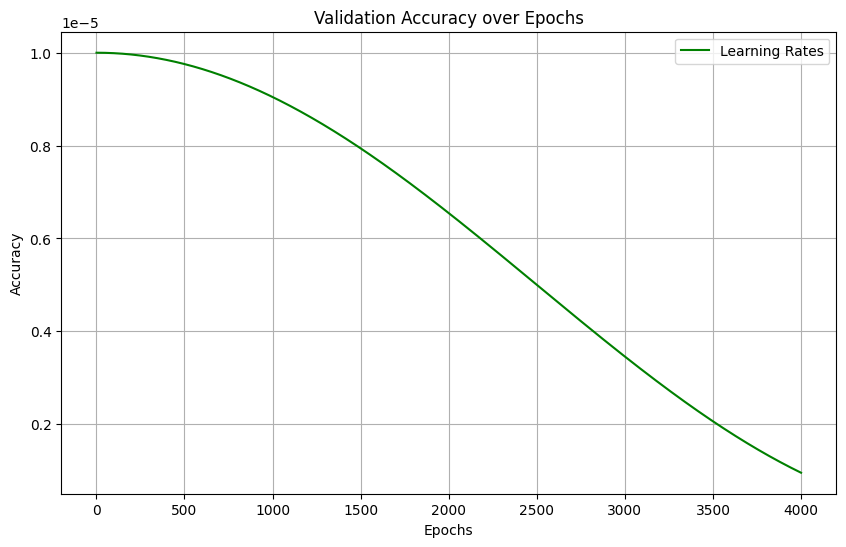

Model for bin 29 saved to GCNModels-5A_exp1/model_bin_29.pth
Training on bin 30/50
Bin 30, Epoch 1/4000, Train Loss: 0.7484, Validation Loss: 0.6691,  Accuracy: 0.7825, LR: 0.000010
Bin 30, Epoch 101/4000, Train Loss: 0.6165, Validation Loss: 0.6103,  Accuracy: 0.7994, LR: 0.000010
Bin 30, Epoch 201/4000, Train Loss: 0.5398, Validation Loss: 0.5340,  Accuracy: 0.8277, LR: 0.000010
Bin 30, Epoch 301/4000, Train Loss: 0.4887, Validation Loss: 0.4610,  Accuracy: 0.8333, LR: 0.000010
Bin 30, Epoch 401/4000, Train Loss: 0.4450, Validation Loss: 0.4573,  Accuracy: 0.8333, LR: 0.000010
Bin 30, Epoch 501/4000, Train Loss: 0.4403, Validation Loss: 0.4142,  Accuracy: 0.8362, LR: 0.000010
Bin 30, Epoch 601/4000, Train Loss: 0.4103, Validation Loss: 0.3778,  Accuracy: 0.8559, LR: 0.000010
Bin 30, Epoch 701/4000, Train Loss: 0.3760, Validation Loss: 0.3906,  Accuracy: 0.8475, LR: 0.000010
Bin 30, Epoch 801/4000, Train Loss: 0.3687, Validation Loss: 0.3947,  Accuracy: 0.8503, LR: 0.000009
Bin 30, Ep

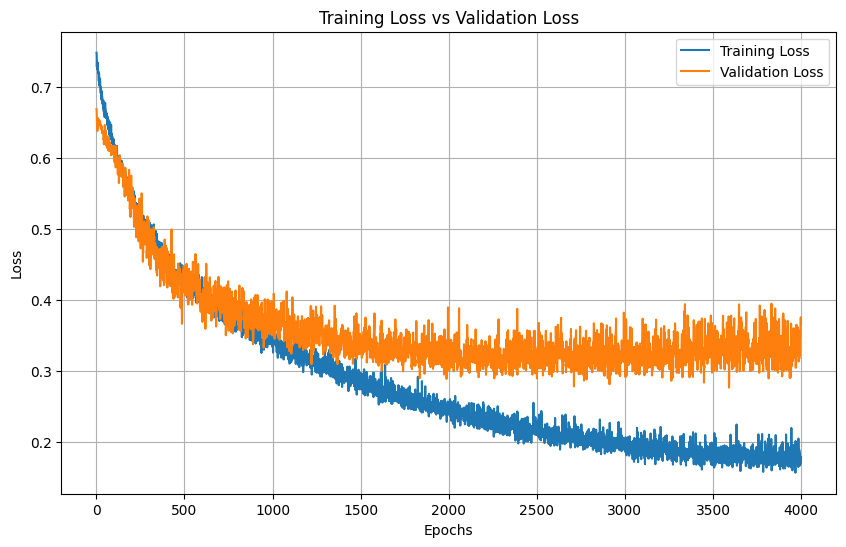

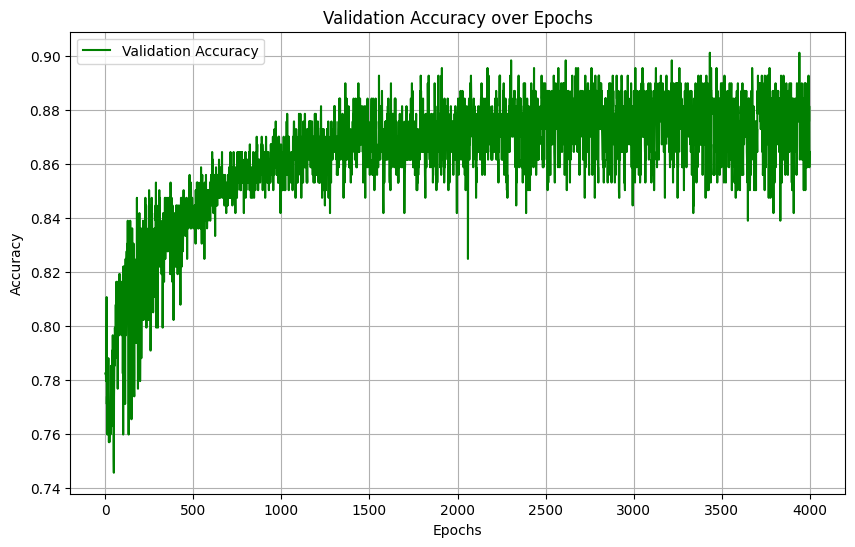

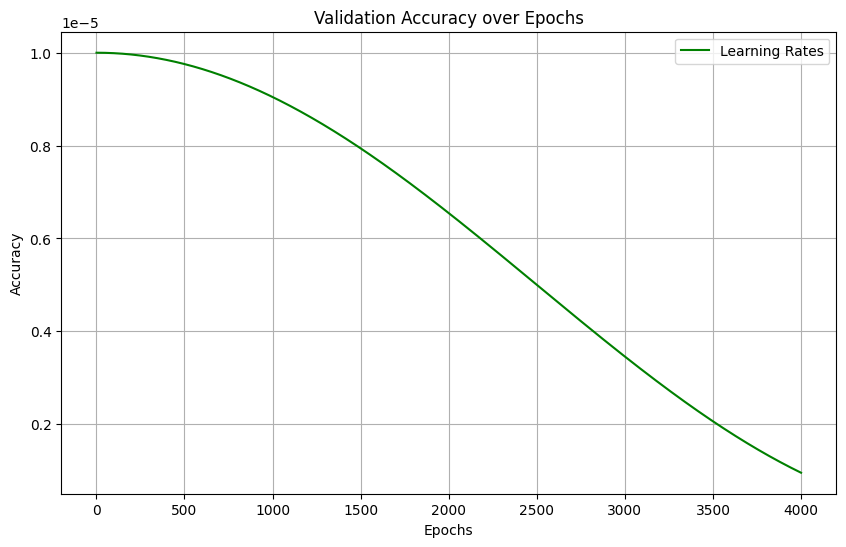

Model for bin 30 saved to GCNModels-5A_exp1/model_bin_30.pth
Training on bin 31/50
Bin 31, Epoch 1/4000, Train Loss: 0.6898, Validation Loss: 0.6749,  Accuracy: 0.7825, LR: 0.000010
Bin 31, Epoch 101/4000, Train Loss: 0.6322, Validation Loss: 0.6208,  Accuracy: 0.8588, LR: 0.000010
Bin 31, Epoch 201/4000, Train Loss: 0.5733, Validation Loss: 0.5941,  Accuracy: 0.8164, LR: 0.000010
Bin 31, Epoch 301/4000, Train Loss: 0.5310, Validation Loss: 0.5409,  Accuracy: 0.8390, LR: 0.000010
Bin 31, Epoch 401/4000, Train Loss: 0.4965, Validation Loss: 0.5041,  Accuracy: 0.8446, LR: 0.000010
Bin 31, Epoch 501/4000, Train Loss: 0.4663, Validation Loss: 0.4258,  Accuracy: 0.8644, LR: 0.000010
Bin 31, Epoch 601/4000, Train Loss: 0.4260, Validation Loss: 0.4140,  Accuracy: 0.8616, LR: 0.000010
Bin 31, Epoch 701/4000, Train Loss: 0.4014, Validation Loss: 0.4262,  Accuracy: 0.8588, LR: 0.000010
Bin 31, Epoch 801/4000, Train Loss: 0.3950, Validation Loss: 0.3839,  Accuracy: 0.8644, LR: 0.000009
Bin 31, Ep

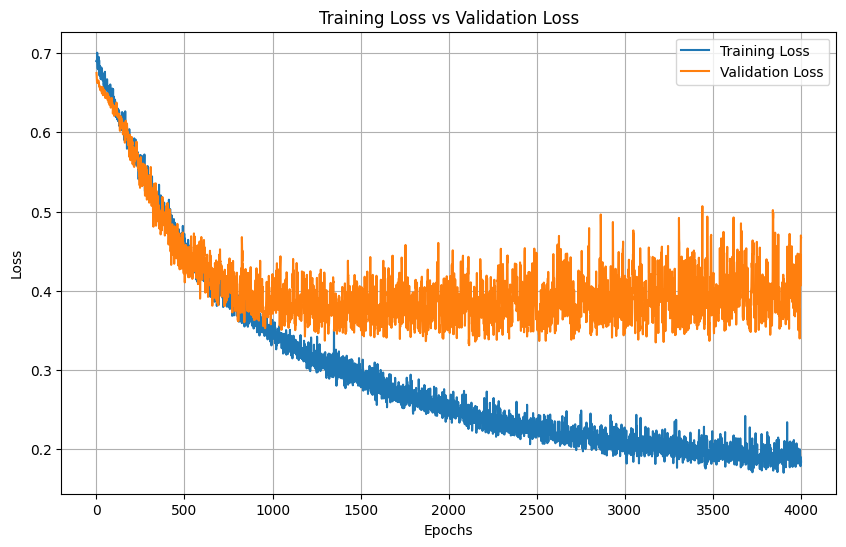

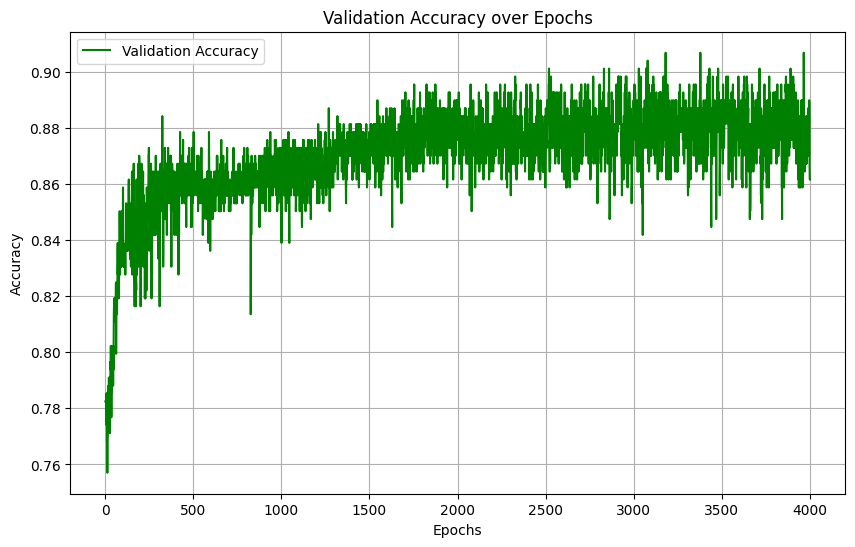

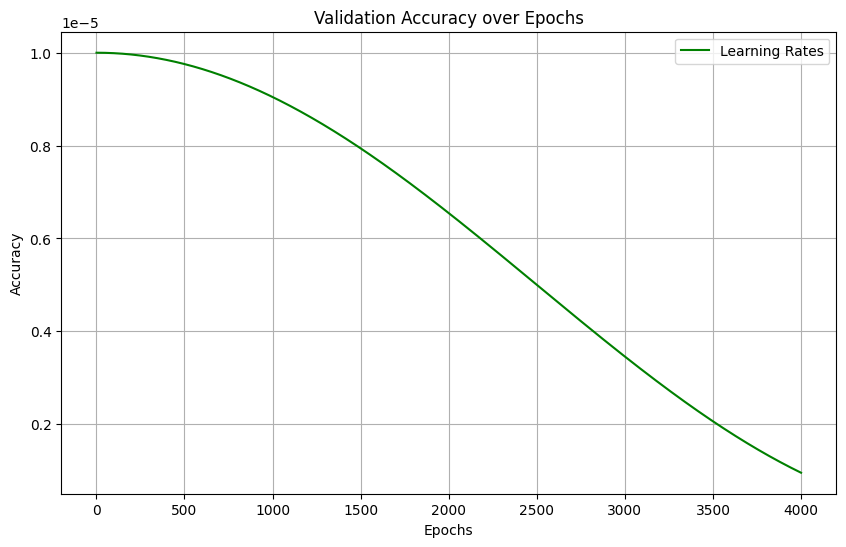

Model for bin 31 saved to GCNModels-5A_exp1/model_bin_31.pth
Training on bin 32/50
Bin 32, Epoch 1/4000, Train Loss: 0.7296, Validation Loss: 0.7210,  Accuracy: 0.2175, LR: 0.000010
Bin 32, Epoch 101/4000, Train Loss: 0.6282, Validation Loss: 0.6636,  Accuracy: 0.6582, LR: 0.000010
Bin 32, Epoch 201/4000, Train Loss: 0.5668, Validation Loss: 0.6255,  Accuracy: 0.7316, LR: 0.000010
Bin 32, Epoch 301/4000, Train Loss: 0.5131, Validation Loss: 0.5736,  Accuracy: 0.7797, LR: 0.000010
Bin 32, Epoch 401/4000, Train Loss: 0.4790, Validation Loss: 0.4921,  Accuracy: 0.8192, LR: 0.000010
Bin 32, Epoch 501/4000, Train Loss: 0.4337, Validation Loss: 0.4655,  Accuracy: 0.8192, LR: 0.000010
Bin 32, Epoch 601/4000, Train Loss: 0.4170, Validation Loss: 0.4747,  Accuracy: 0.8192, LR: 0.000010
Bin 32, Epoch 701/4000, Train Loss: 0.4060, Validation Loss: 0.4060,  Accuracy: 0.8446, LR: 0.000010
Bin 32, Epoch 801/4000, Train Loss: 0.3845, Validation Loss: 0.4130,  Accuracy: 0.8390, LR: 0.000009
Bin 32, Ep

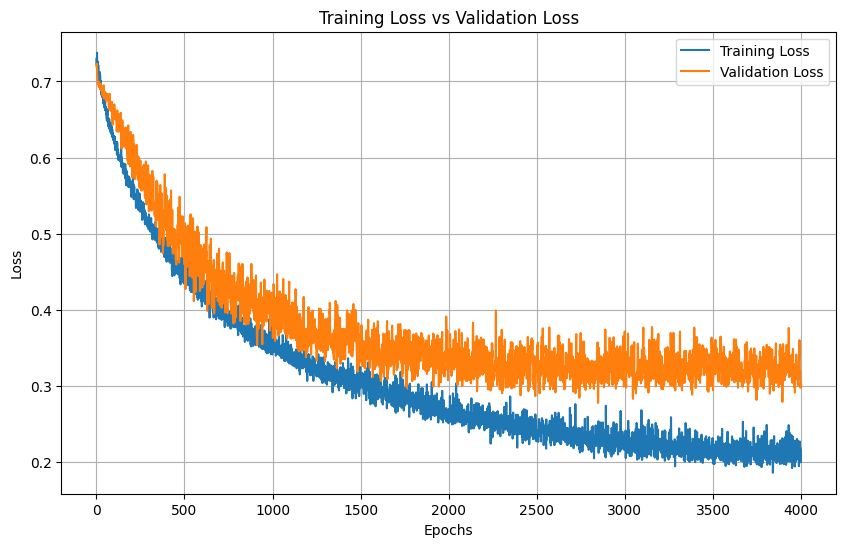

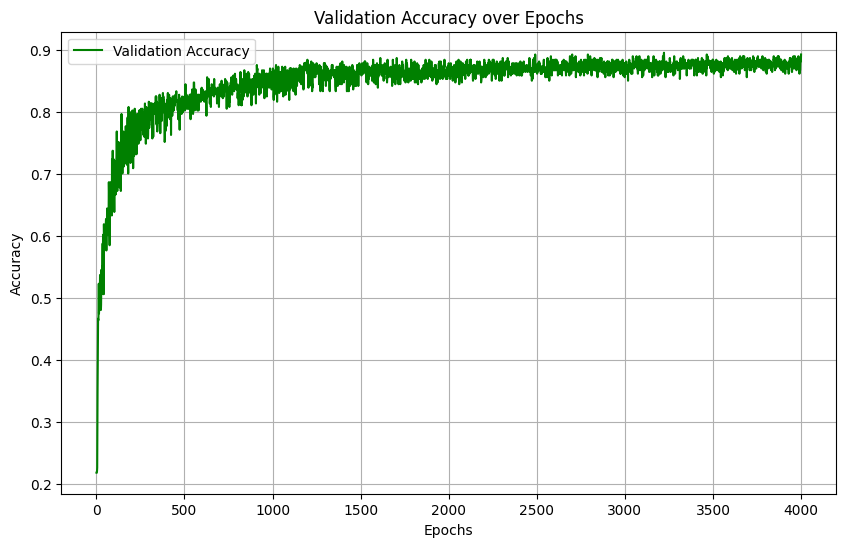

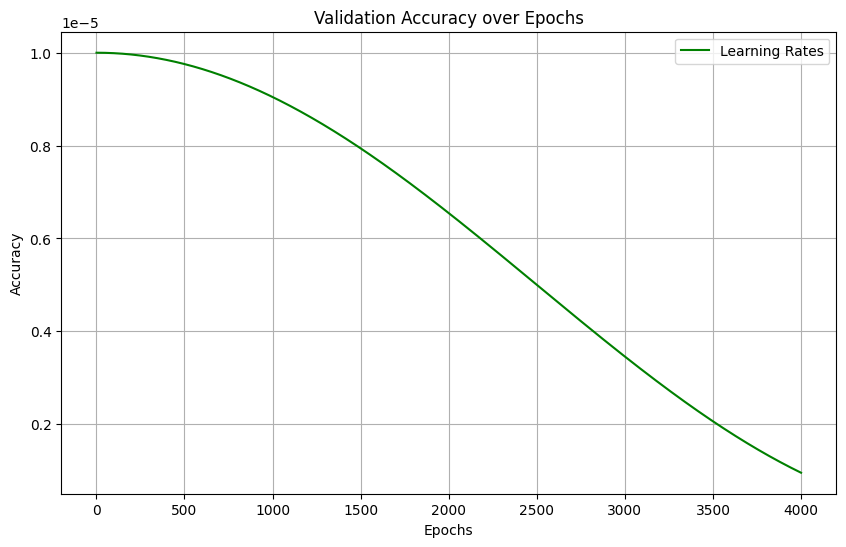

Model for bin 32 saved to GCNModels-5A_exp1/model_bin_32.pth
Training on bin 33/50
Bin 33, Epoch 1/4000, Train Loss: 0.6962, Validation Loss: 0.6709,  Accuracy: 0.7825, LR: 0.000010
Bin 33, Epoch 101/4000, Train Loss: 0.6132, Validation Loss: 0.6421,  Accuracy: 0.7712, LR: 0.000010
Bin 33, Epoch 201/4000, Train Loss: 0.5620, Validation Loss: 0.5885,  Accuracy: 0.7853, LR: 0.000010
Bin 33, Epoch 301/4000, Train Loss: 0.4905, Validation Loss: 0.5286,  Accuracy: 0.8079, LR: 0.000010
Bin 33, Epoch 401/4000, Train Loss: 0.4586, Validation Loss: 0.5089,  Accuracy: 0.8249, LR: 0.000010
Bin 33, Epoch 501/4000, Train Loss: 0.4228, Validation Loss: 0.4441,  Accuracy: 0.8503, LR: 0.000010
Bin 33, Epoch 601/4000, Train Loss: 0.4030, Validation Loss: 0.4352,  Accuracy: 0.8503, LR: 0.000010
Bin 33, Epoch 701/4000, Train Loss: 0.3860, Validation Loss: 0.4178,  Accuracy: 0.8531, LR: 0.000010
Bin 33, Epoch 801/4000, Train Loss: 0.3562, Validation Loss: 0.4234,  Accuracy: 0.8446, LR: 0.000009
Bin 33, Ep

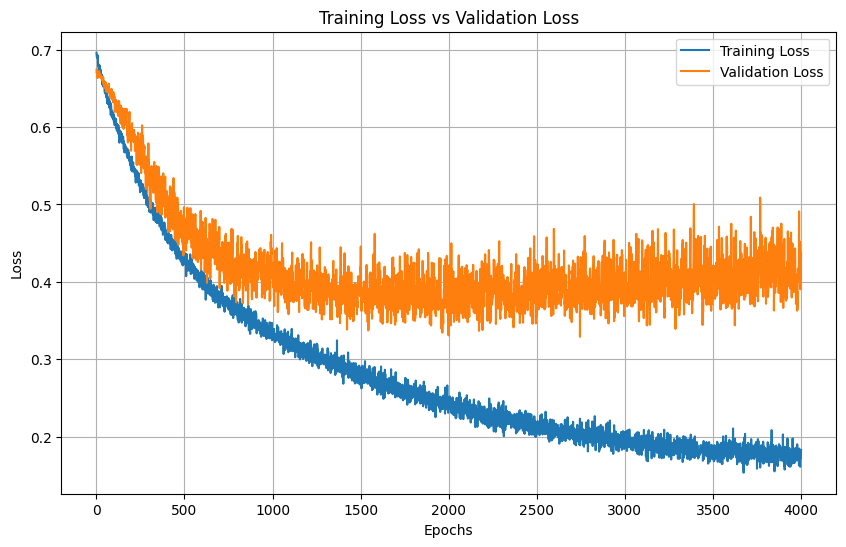

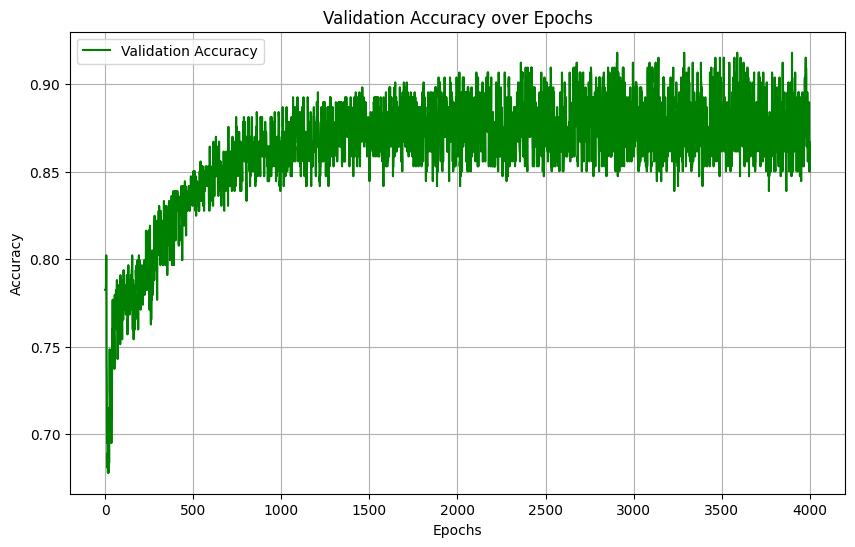

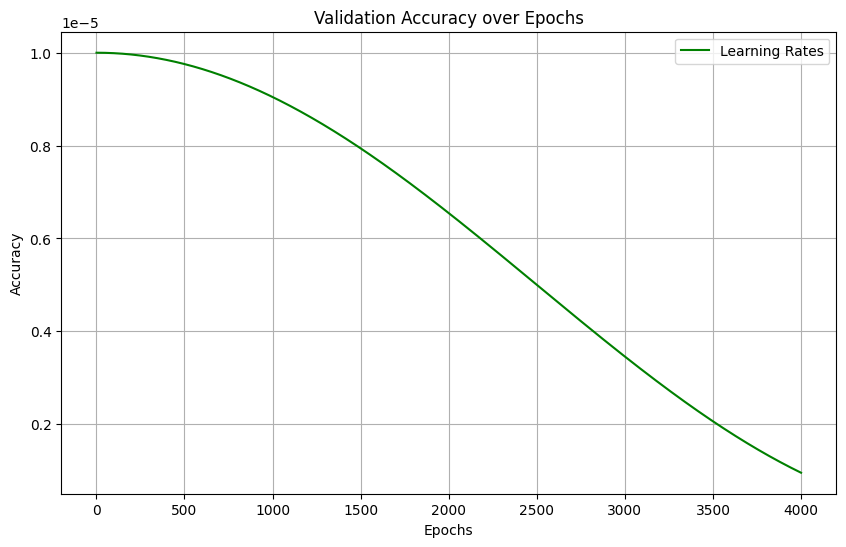

Model for bin 33 saved to GCNModels-5A_exp1/model_bin_33.pth
Training on bin 34/50
Bin 34, Epoch 1/4000, Train Loss: 0.7222, Validation Loss: 0.6873,  Accuracy: 0.7825, LR: 0.000010
Bin 34, Epoch 101/4000, Train Loss: 0.6335, Validation Loss: 0.6308,  Accuracy: 0.7966, LR: 0.000010
Bin 34, Epoch 201/4000, Train Loss: 0.5916, Validation Loss: 0.5846,  Accuracy: 0.7853, LR: 0.000010
Bin 34, Epoch 301/4000, Train Loss: 0.5320, Validation Loss: 0.5105,  Accuracy: 0.8220, LR: 0.000010
Bin 34, Epoch 401/4000, Train Loss: 0.4760, Validation Loss: 0.4692,  Accuracy: 0.8305, LR: 0.000010
Bin 34, Epoch 501/4000, Train Loss: 0.4637, Validation Loss: 0.4365,  Accuracy: 0.8446, LR: 0.000010
Bin 34, Epoch 601/4000, Train Loss: 0.4361, Validation Loss: 0.4091,  Accuracy: 0.8475, LR: 0.000010
Bin 34, Epoch 701/4000, Train Loss: 0.4312, Validation Loss: 0.3844,  Accuracy: 0.8588, LR: 0.000010
Bin 34, Epoch 801/4000, Train Loss: 0.4209, Validation Loss: 0.3473,  Accuracy: 0.8701, LR: 0.000009
Bin 34, Ep

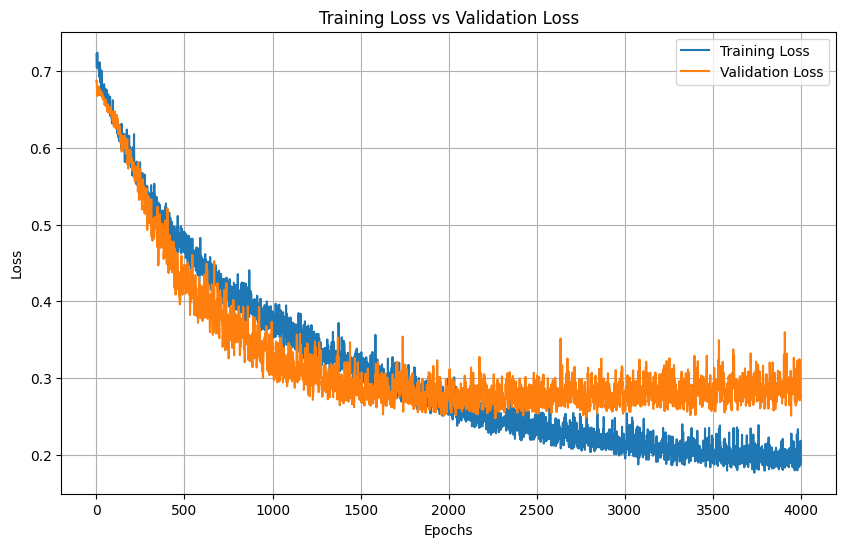

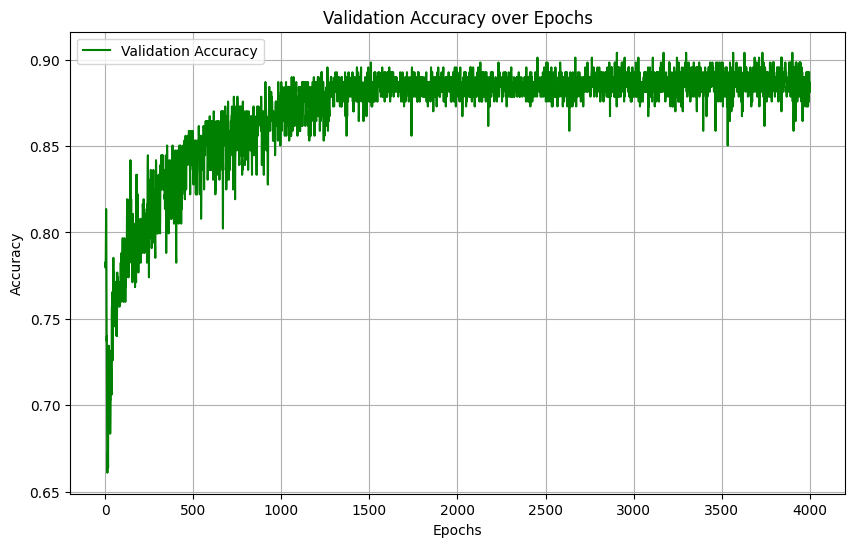

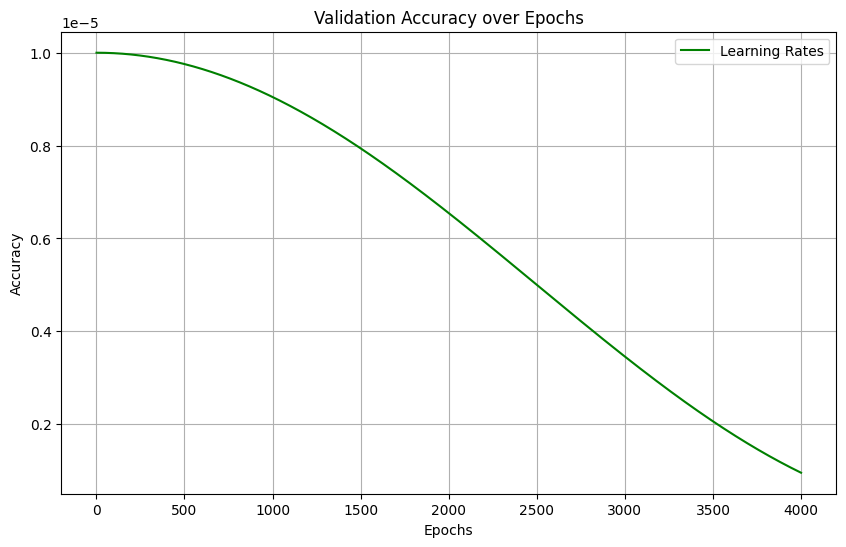

Model for bin 34 saved to GCNModels-5A_exp1/model_bin_34.pth
Training on bin 35/50
Bin 35, Epoch 1/4000, Train Loss: 0.7409, Validation Loss: 0.7168,  Accuracy: 0.2175, LR: 0.000010
Bin 35, Epoch 101/4000, Train Loss: 0.6324, Validation Loss: 0.6422,  Accuracy: 0.7881, LR: 0.000010
Bin 35, Epoch 201/4000, Train Loss: 0.5743, Validation Loss: 0.5697,  Accuracy: 0.8192, LR: 0.000010
Bin 35, Epoch 301/4000, Train Loss: 0.5116, Validation Loss: 0.5177,  Accuracy: 0.8277, LR: 0.000010
Bin 35, Epoch 401/4000, Train Loss: 0.4822, Validation Loss: 0.4658,  Accuracy: 0.8390, LR: 0.000010
Bin 35, Epoch 501/4000, Train Loss: 0.4555, Validation Loss: 0.4586,  Accuracy: 0.8305, LR: 0.000010
Bin 35, Epoch 601/4000, Train Loss: 0.4244, Validation Loss: 0.4311,  Accuracy: 0.8390, LR: 0.000010
Bin 35, Epoch 701/4000, Train Loss: 0.4157, Validation Loss: 0.4227,  Accuracy: 0.8446, LR: 0.000010
Bin 35, Epoch 801/4000, Train Loss: 0.3922, Validation Loss: 0.3851,  Accuracy: 0.8588, LR: 0.000009
Bin 35, Ep

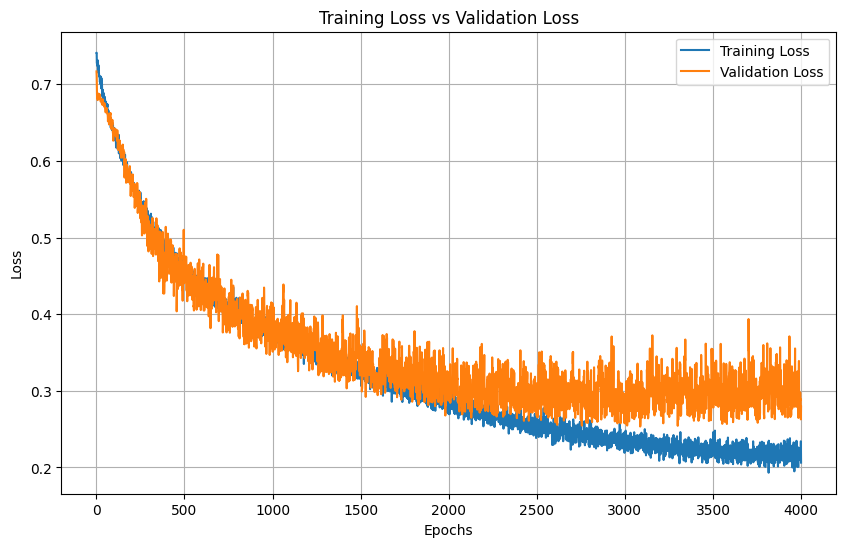

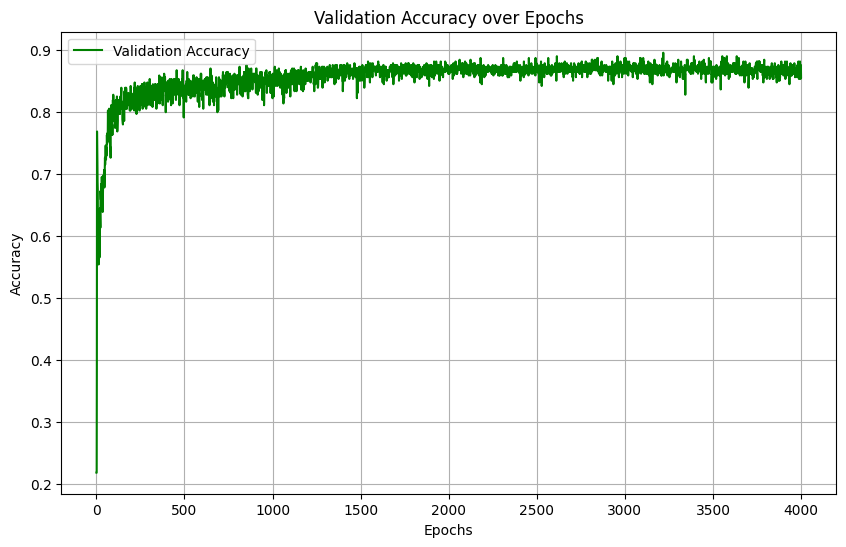

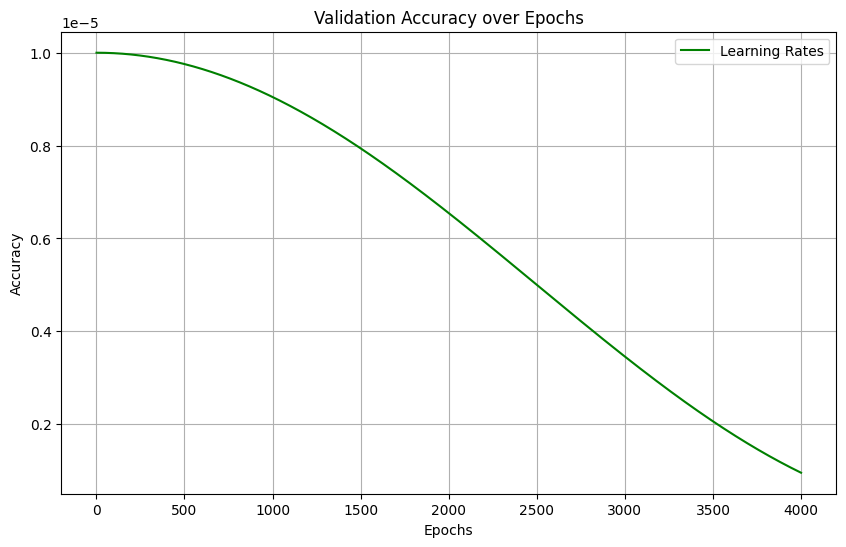

Model for bin 35 saved to GCNModels-5A_exp1/model_bin_35.pth
Training on bin 36/50
Bin 36, Epoch 1/4000, Train Loss: 0.7583, Validation Loss: 0.6899,  Accuracy: 0.7825, LR: 0.000010
Bin 36, Epoch 101/4000, Train Loss: 0.6476, Validation Loss: 0.6116,  Accuracy: 0.7938, LR: 0.000010
Bin 36, Epoch 201/4000, Train Loss: 0.5830, Validation Loss: 0.5552,  Accuracy: 0.8079, LR: 0.000010
Bin 36, Epoch 301/4000, Train Loss: 0.5050, Validation Loss: 0.5231,  Accuracy: 0.8220, LR: 0.000010
Bin 36, Epoch 401/4000, Train Loss: 0.4842, Validation Loss: 0.4442,  Accuracy: 0.8418, LR: 0.000010
Bin 36, Epoch 501/4000, Train Loss: 0.4326, Validation Loss: 0.4266,  Accuracy: 0.8588, LR: 0.000010
Bin 36, Epoch 601/4000, Train Loss: 0.4010, Validation Loss: 0.4322,  Accuracy: 0.8588, LR: 0.000010
Bin 36, Epoch 701/4000, Train Loss: 0.3812, Validation Loss: 0.3916,  Accuracy: 0.8588, LR: 0.000010
Bin 36, Epoch 801/4000, Train Loss: 0.3548, Validation Loss: 0.3670,  Accuracy: 0.8729, LR: 0.000009
Bin 36, Ep

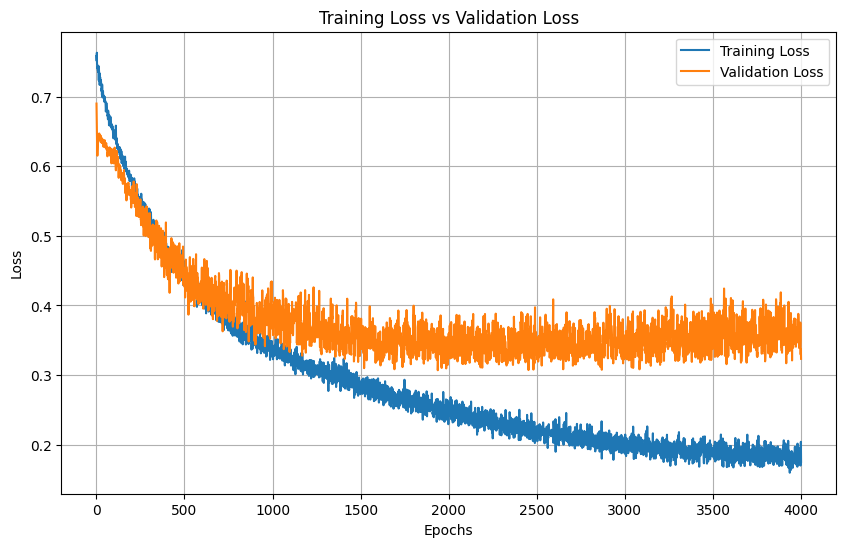

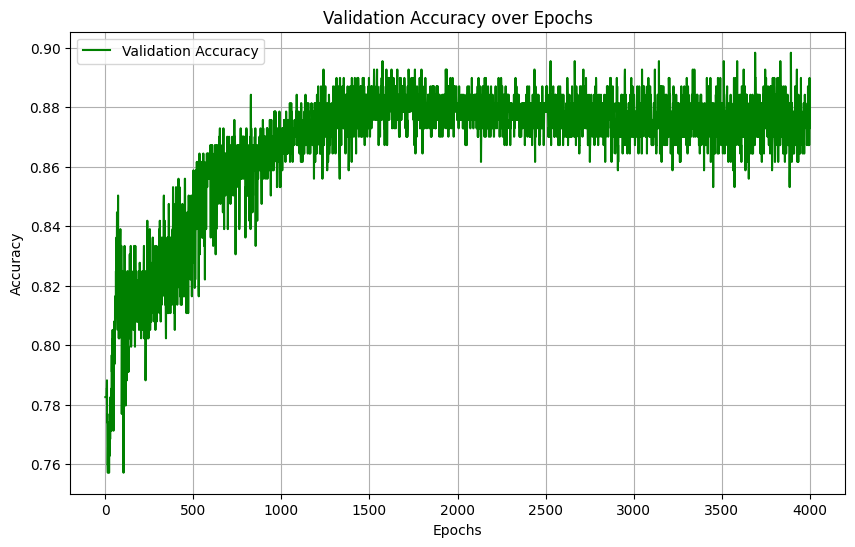

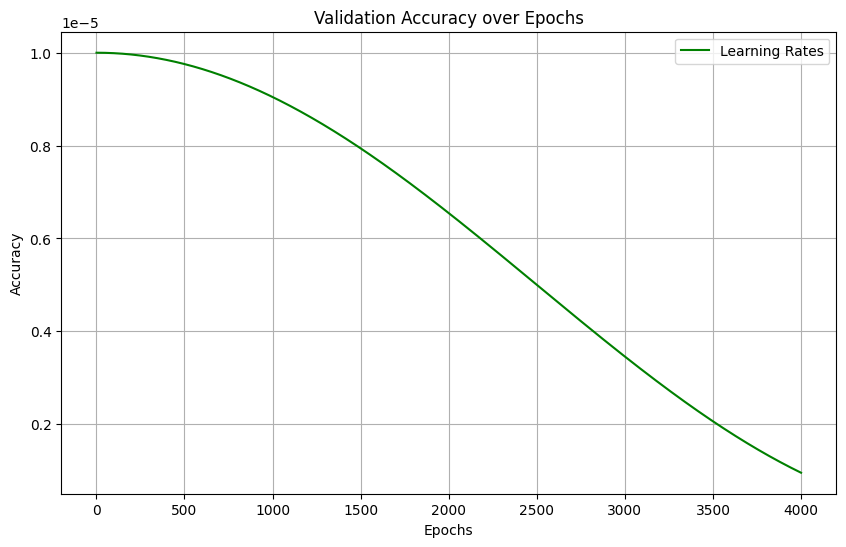

Model for bin 36 saved to GCNModels-5A_exp1/model_bin_36.pth
Training on bin 37/50
Bin 37, Epoch 1/4000, Train Loss: 0.7222, Validation Loss: 0.7179,  Accuracy: 0.2175, LR: 0.000010
Bin 37, Epoch 101/4000, Train Loss: 0.6472, Validation Loss: 0.6839,  Accuracy: 0.5678, LR: 0.000010
Bin 37, Epoch 201/4000, Train Loss: 0.5781, Validation Loss: 0.6255,  Accuracy: 0.7514, LR: 0.000010
Bin 37, Epoch 301/4000, Train Loss: 0.5297, Validation Loss: 0.5931,  Accuracy: 0.7768, LR: 0.000010
Bin 37, Epoch 401/4000, Train Loss: 0.4882, Validation Loss: 0.5258,  Accuracy: 0.8192, LR: 0.000010
Bin 37, Epoch 501/4000, Train Loss: 0.4565, Validation Loss: 0.4972,  Accuracy: 0.8333, LR: 0.000010
Bin 37, Epoch 601/4000, Train Loss: 0.4313, Validation Loss: 0.4225,  Accuracy: 0.8503, LR: 0.000010
Bin 37, Epoch 701/4000, Train Loss: 0.4090, Validation Loss: 0.4757,  Accuracy: 0.8333, LR: 0.000010
Bin 37, Epoch 801/4000, Train Loss: 0.3939, Validation Loss: 0.4036,  Accuracy: 0.8644, LR: 0.000009
Bin 37, Ep

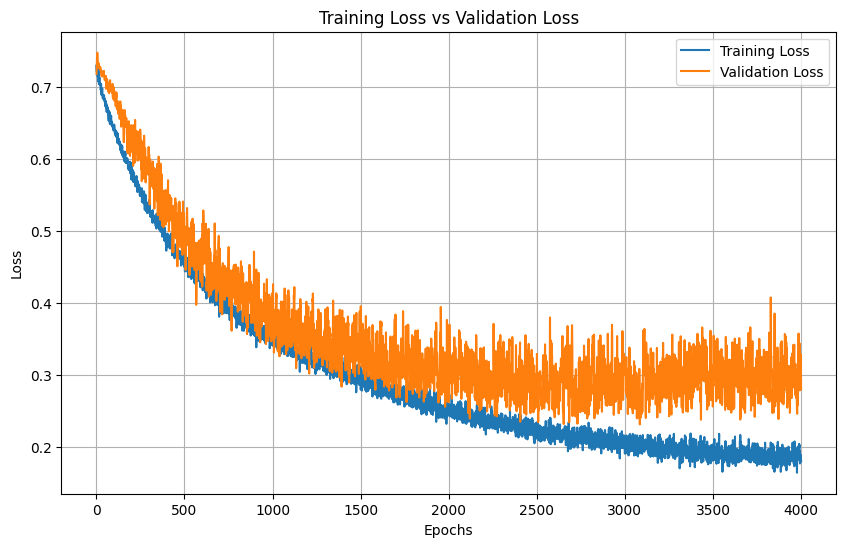

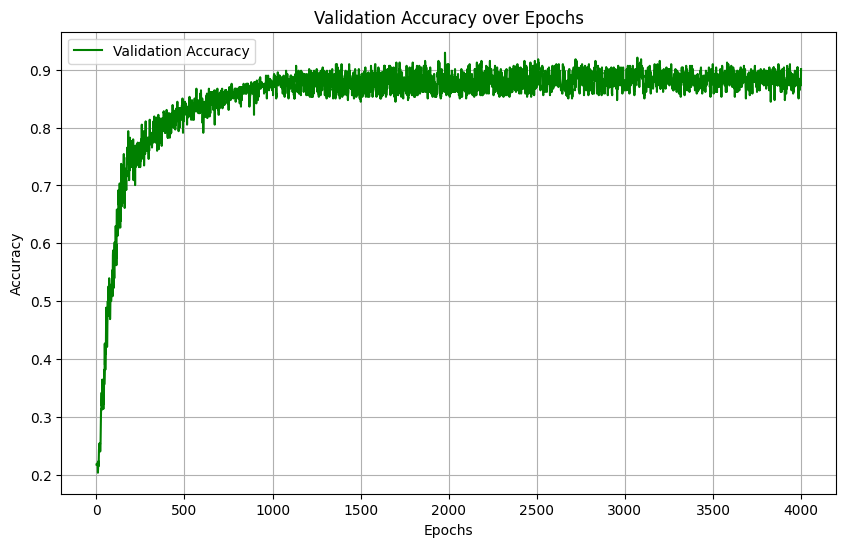

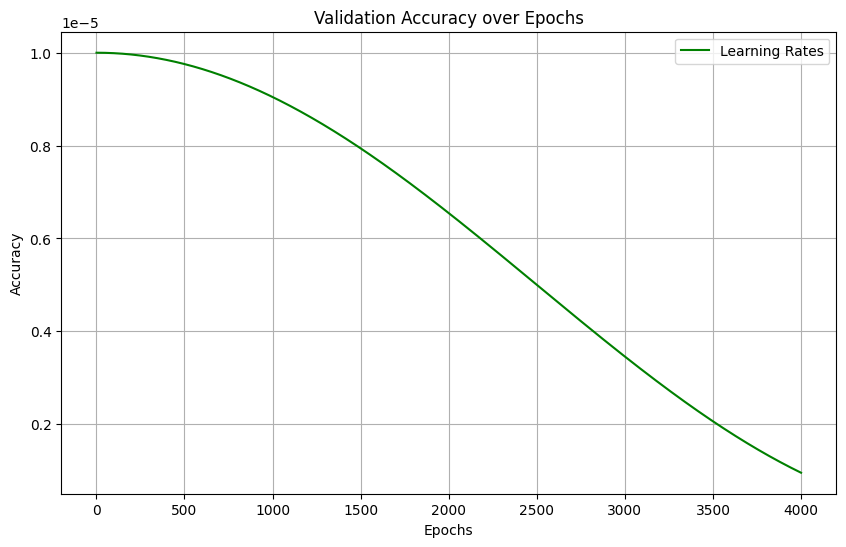

Model for bin 37 saved to GCNModels-5A_exp1/model_bin_37.pth
Training on bin 38/50
Bin 38, Epoch 1/4000, Train Loss: 0.6948, Validation Loss: 0.7273,  Accuracy: 0.2175, LR: 0.000010
Bin 38, Epoch 101/4000, Train Loss: 0.6270, Validation Loss: 0.7017,  Accuracy: 0.5424, LR: 0.000010
Bin 38, Epoch 201/4000, Train Loss: 0.5918, Validation Loss: 0.6222,  Accuracy: 0.7655, LR: 0.000010
Bin 38, Epoch 301/4000, Train Loss: 0.5724, Validation Loss: 0.5532,  Accuracy: 0.8362, LR: 0.000010
Bin 38, Epoch 401/4000, Train Loss: 0.4991, Validation Loss: 0.5340,  Accuracy: 0.8249, LR: 0.000010
Bin 38, Epoch 501/4000, Train Loss: 0.4735, Validation Loss: 0.4603,  Accuracy: 0.8475, LR: 0.000010
Bin 38, Epoch 601/4000, Train Loss: 0.4481, Validation Loss: 0.3976,  Accuracy: 0.8672, LR: 0.000010
Bin 38, Epoch 701/4000, Train Loss: 0.4282, Validation Loss: 0.3794,  Accuracy: 0.8701, LR: 0.000010
Bin 38, Epoch 801/4000, Train Loss: 0.3863, Validation Loss: 0.3435,  Accuracy: 0.8729, LR: 0.000009
Bin 38, Ep

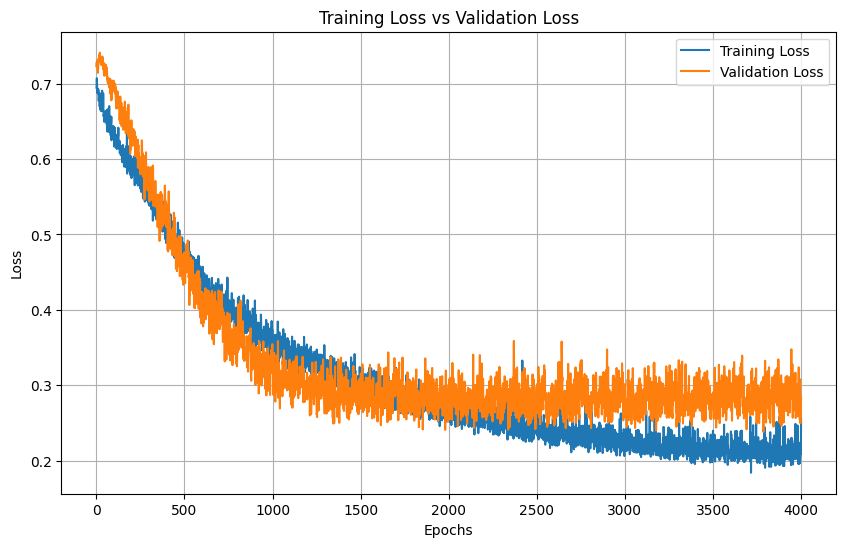

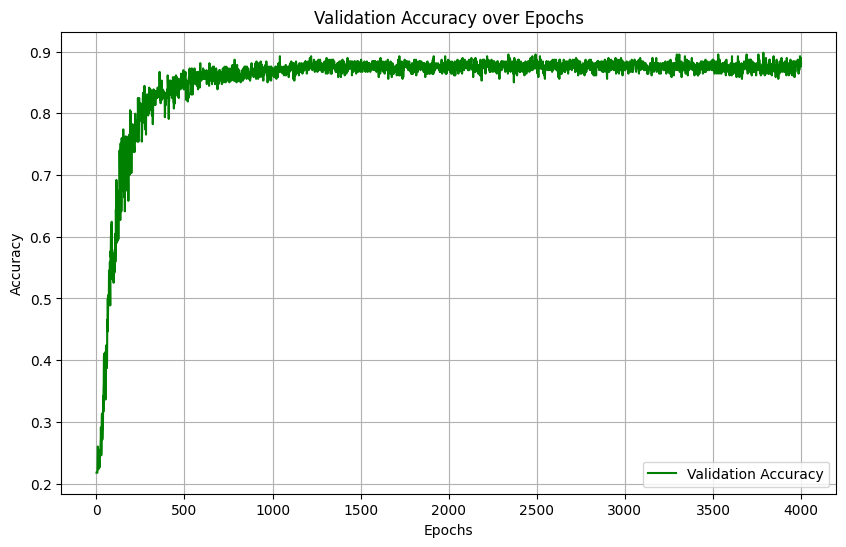

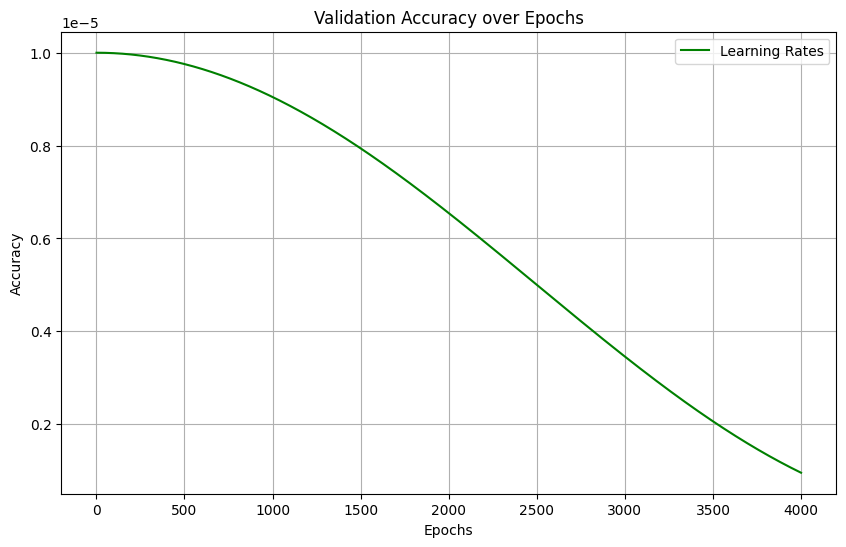

Model for bin 38 saved to GCNModels-5A_exp1/model_bin_38.pth
Training on bin 39/50
Bin 39, Epoch 1/4000, Train Loss: 0.6898, Validation Loss: 0.6880,  Accuracy: 0.7825, LR: 0.000010
Bin 39, Epoch 101/4000, Train Loss: 0.6148, Validation Loss: 0.6218,  Accuracy: 0.8079, LR: 0.000010
Bin 39, Epoch 201/4000, Train Loss: 0.5715, Validation Loss: 0.5645,  Accuracy: 0.8164, LR: 0.000010
Bin 39, Epoch 301/4000, Train Loss: 0.5357, Validation Loss: 0.5116,  Accuracy: 0.8277, LR: 0.000010
Bin 39, Epoch 401/4000, Train Loss: 0.4861, Validation Loss: 0.4404,  Accuracy: 0.8503, LR: 0.000010
Bin 39, Epoch 501/4000, Train Loss: 0.4540, Validation Loss: 0.4181,  Accuracy: 0.8333, LR: 0.000010
Bin 39, Epoch 601/4000, Train Loss: 0.4609, Validation Loss: 0.3854,  Accuracy: 0.8531, LR: 0.000010
Bin 39, Epoch 701/4000, Train Loss: 0.4319, Validation Loss: 0.3426,  Accuracy: 0.8870, LR: 0.000010
Bin 39, Epoch 801/4000, Train Loss: 0.4048, Validation Loss: 0.3282,  Accuracy: 0.8814, LR: 0.000009
Bin 39, Ep

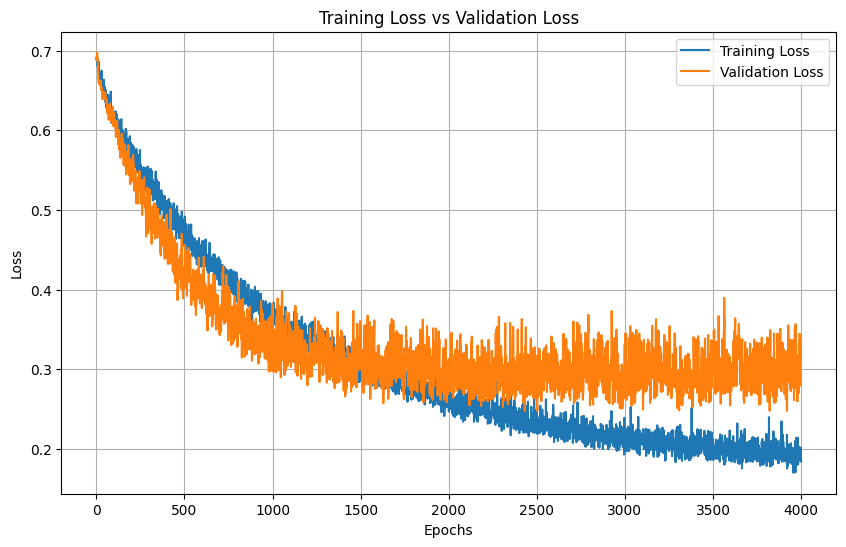

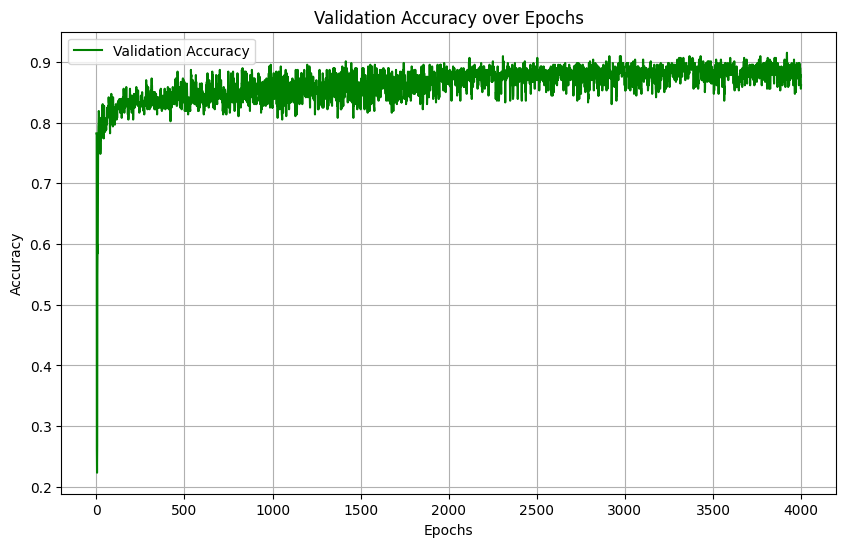

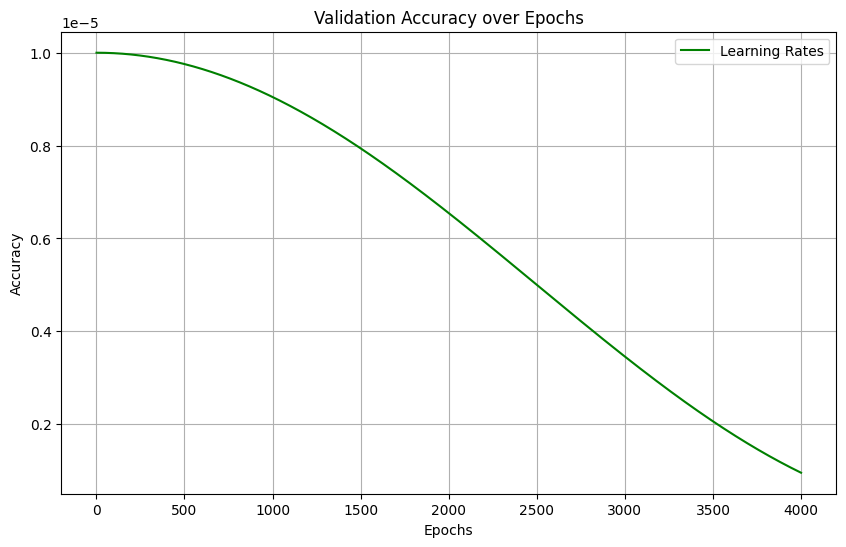

Model for bin 39 saved to GCNModels-5A_exp1/model_bin_39.pth
Training on bin 40/50
Bin 40, Epoch 1/4000, Train Loss: 0.6992, Validation Loss: 0.6974,  Accuracy: 0.2203, LR: 0.000010
Bin 40, Epoch 101/4000, Train Loss: 0.6192, Validation Loss: 0.6308,  Accuracy: 0.8079, LR: 0.000010
Bin 40, Epoch 201/4000, Train Loss: 0.5467, Validation Loss: 0.5678,  Accuracy: 0.8362, LR: 0.000010
Bin 40, Epoch 301/4000, Train Loss: 0.5112, Validation Loss: 0.5025,  Accuracy: 0.8305, LR: 0.000010
Bin 40, Epoch 401/4000, Train Loss: 0.4773, Validation Loss: 0.4522,  Accuracy: 0.8446, LR: 0.000010
Bin 40, Epoch 501/4000, Train Loss: 0.4386, Validation Loss: 0.4075,  Accuracy: 0.8559, LR: 0.000010
Bin 40, Epoch 601/4000, Train Loss: 0.4225, Validation Loss: 0.3956,  Accuracy: 0.8503, LR: 0.000010
Bin 40, Epoch 701/4000, Train Loss: 0.3931, Validation Loss: 0.3628,  Accuracy: 0.8588, LR: 0.000010
Bin 40, Epoch 801/4000, Train Loss: 0.3752, Validation Loss: 0.3603,  Accuracy: 0.8588, LR: 0.000009
Bin 40, Ep

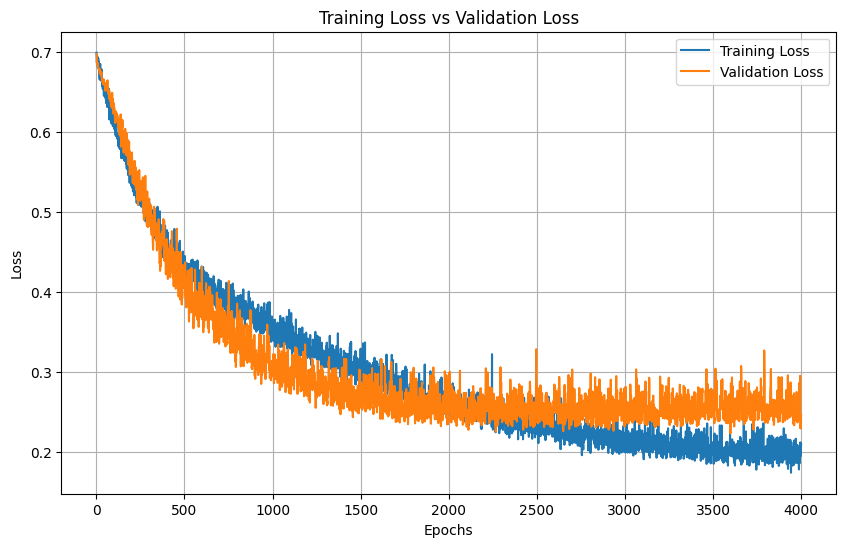

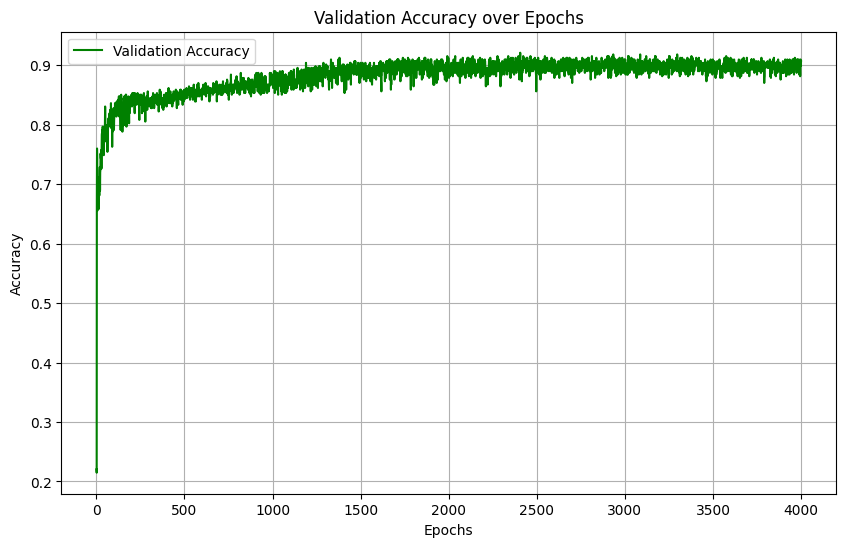

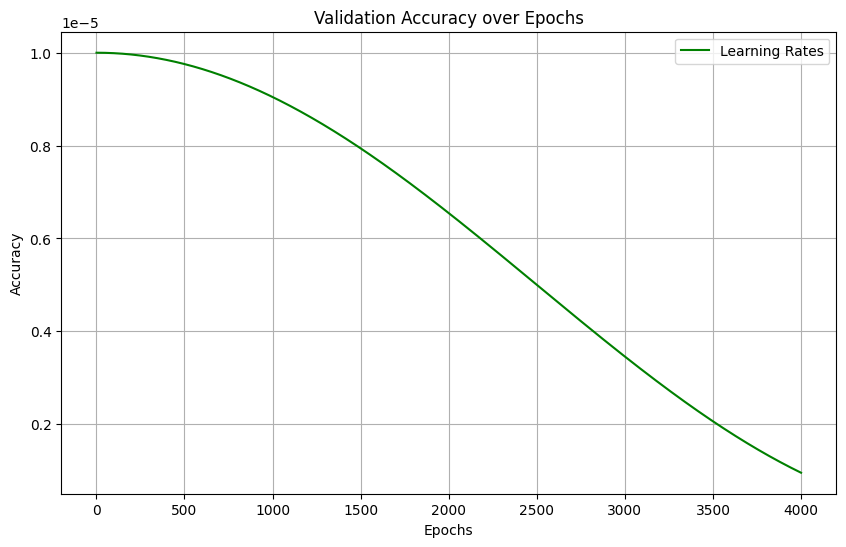

Model for bin 40 saved to GCNModels-5A_exp1/model_bin_40.pth
Training on bin 41/50
Bin 41, Epoch 1/4000, Train Loss: 0.6897, Validation Loss: 0.6659,  Accuracy: 0.7825, LR: 0.000010
Bin 41, Epoch 101/4000, Train Loss: 0.6074, Validation Loss: 0.6227,  Accuracy: 0.7881, LR: 0.000010
Bin 41, Epoch 201/4000, Train Loss: 0.5665, Validation Loss: 0.5841,  Accuracy: 0.8023, LR: 0.000010
Bin 41, Epoch 301/4000, Train Loss: 0.5148, Validation Loss: 0.4879,  Accuracy: 0.8588, LR: 0.000010
Bin 41, Epoch 401/4000, Train Loss: 0.4795, Validation Loss: 0.4508,  Accuracy: 0.8559, LR: 0.000010
Bin 41, Epoch 501/4000, Train Loss: 0.4328, Validation Loss: 0.4131,  Accuracy: 0.8644, LR: 0.000010
Bin 41, Epoch 601/4000, Train Loss: 0.4087, Validation Loss: 0.4414,  Accuracy: 0.8475, LR: 0.000010
Bin 41, Epoch 701/4000, Train Loss: 0.4282, Validation Loss: 0.3945,  Accuracy: 0.8672, LR: 0.000010
Bin 41, Epoch 801/4000, Train Loss: 0.3836, Validation Loss: 0.4078,  Accuracy: 0.8616, LR: 0.000009
Bin 41, Ep

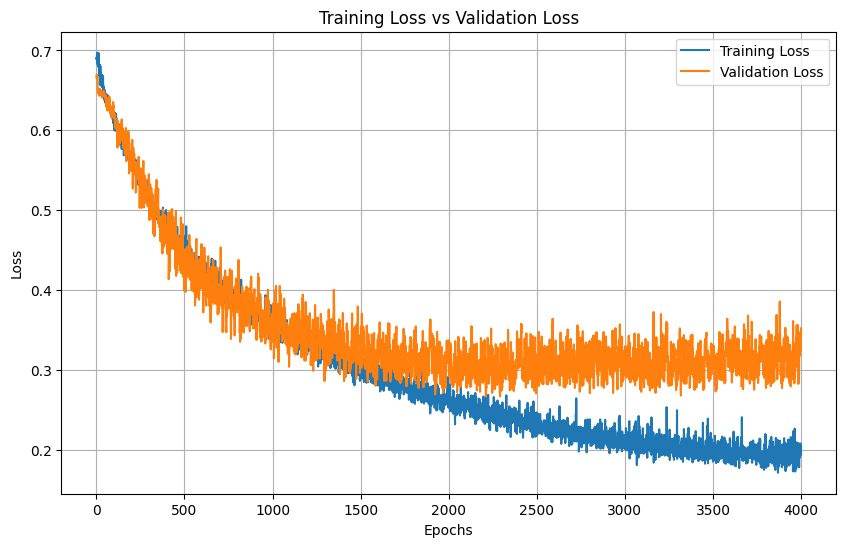

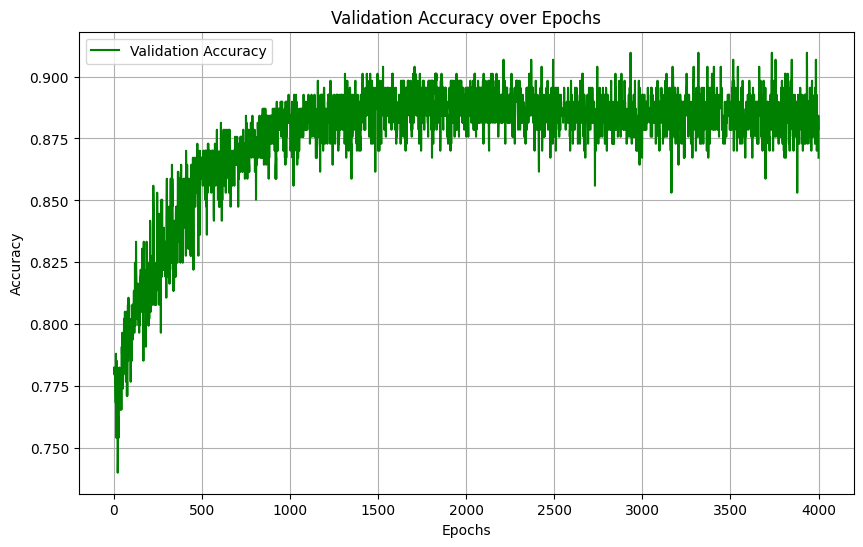

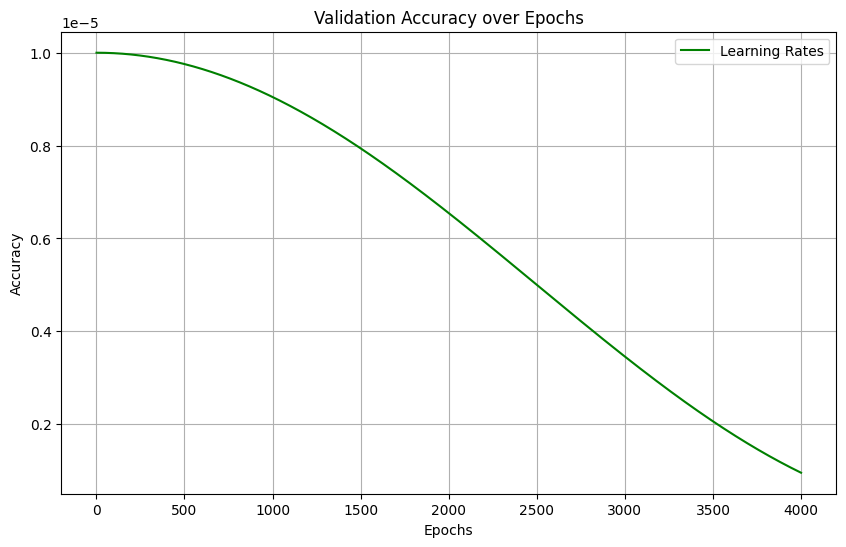

Model for bin 41 saved to GCNModels-5A_exp1/model_bin_41.pth
Training on bin 42/50
Bin 42, Epoch 1/4000, Train Loss: 0.6907, Validation Loss: 0.7341,  Accuracy: 0.2175, LR: 0.000010
Bin 42, Epoch 101/4000, Train Loss: 0.6289, Validation Loss: 0.6390,  Accuracy: 0.7571, LR: 0.000010
Bin 42, Epoch 201/4000, Train Loss: 0.5613, Validation Loss: 0.5814,  Accuracy: 0.7825, LR: 0.000010
Bin 42, Epoch 301/4000, Train Loss: 0.4986, Validation Loss: 0.5214,  Accuracy: 0.7881, LR: 0.000010
Bin 42, Epoch 401/4000, Train Loss: 0.4757, Validation Loss: 0.4488,  Accuracy: 0.8192, LR: 0.000010
Bin 42, Epoch 501/4000, Train Loss: 0.4389, Validation Loss: 0.4440,  Accuracy: 0.8051, LR: 0.000010
Bin 42, Epoch 601/4000, Train Loss: 0.4123, Validation Loss: 0.3924,  Accuracy: 0.8390, LR: 0.000010
Bin 42, Epoch 701/4000, Train Loss: 0.3867, Validation Loss: 0.3859,  Accuracy: 0.8333, LR: 0.000010
Bin 42, Epoch 801/4000, Train Loss: 0.3649, Validation Loss: 0.4090,  Accuracy: 0.8362, LR: 0.000009
Bin 42, Ep

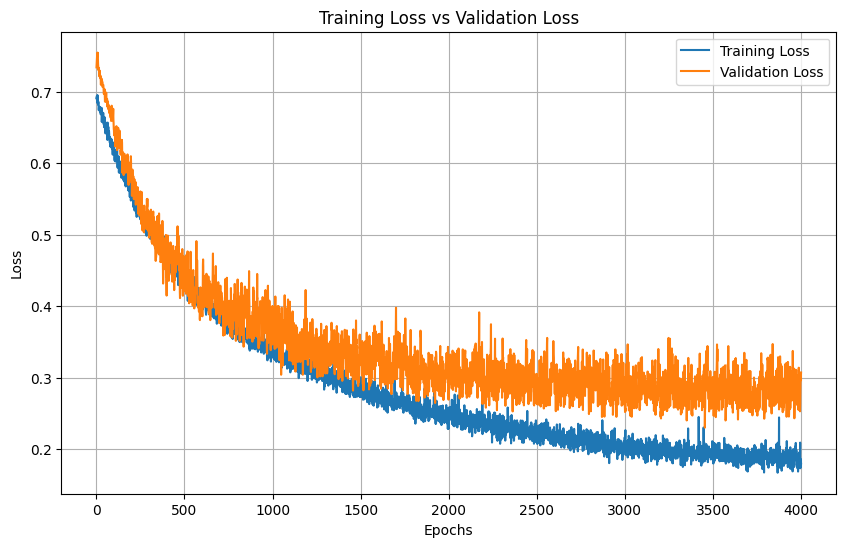

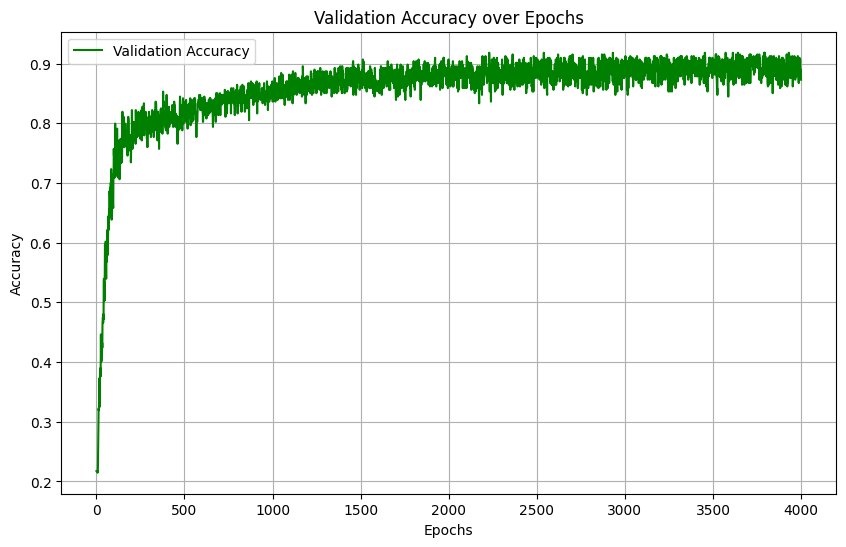

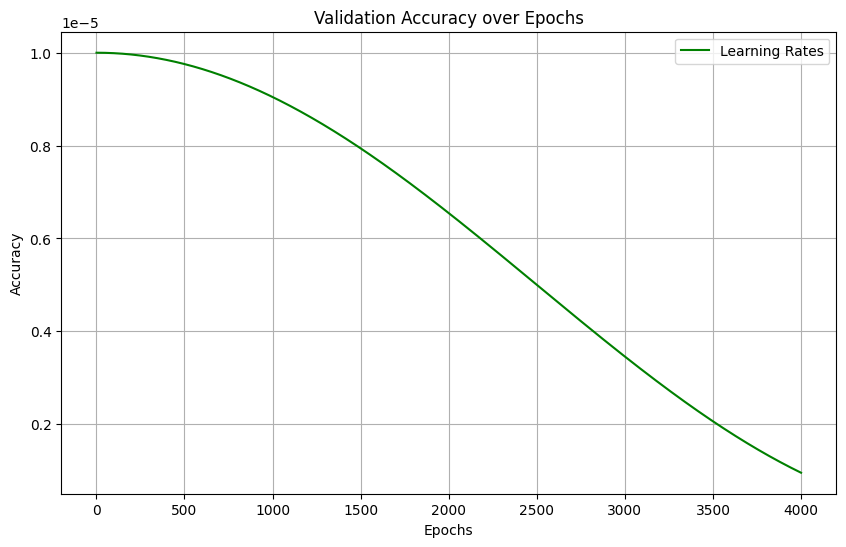

Model for bin 42 saved to GCNModels-5A_exp1/model_bin_42.pth
Training on bin 43/50
Bin 43, Epoch 1/4000, Train Loss: 0.7281, Validation Loss: 0.6990,  Accuracy: 0.2203, LR: 0.000010
Bin 43, Epoch 101/4000, Train Loss: 0.6374, Validation Loss: 0.6525,  Accuracy: 0.6949, LR: 0.000010
Bin 43, Epoch 201/4000, Train Loss: 0.5691, Validation Loss: 0.5854,  Accuracy: 0.7853, LR: 0.000010
Bin 43, Epoch 301/4000, Train Loss: 0.5389, Validation Loss: 0.5292,  Accuracy: 0.7994, LR: 0.000010
Bin 43, Epoch 401/4000, Train Loss: 0.4794, Validation Loss: 0.5165,  Accuracy: 0.8051, LR: 0.000010
Bin 43, Epoch 501/4000, Train Loss: 0.4437, Validation Loss: 0.4574,  Accuracy: 0.8277, LR: 0.000010
Bin 43, Epoch 601/4000, Train Loss: 0.4233, Validation Loss: 0.4900,  Accuracy: 0.7797, LR: 0.000010
Bin 43, Epoch 701/4000, Train Loss: 0.3987, Validation Loss: 0.4445,  Accuracy: 0.8192, LR: 0.000010
Bin 43, Epoch 801/4000, Train Loss: 0.3870, Validation Loss: 0.4114,  Accuracy: 0.8390, LR: 0.000009
Bin 43, Ep

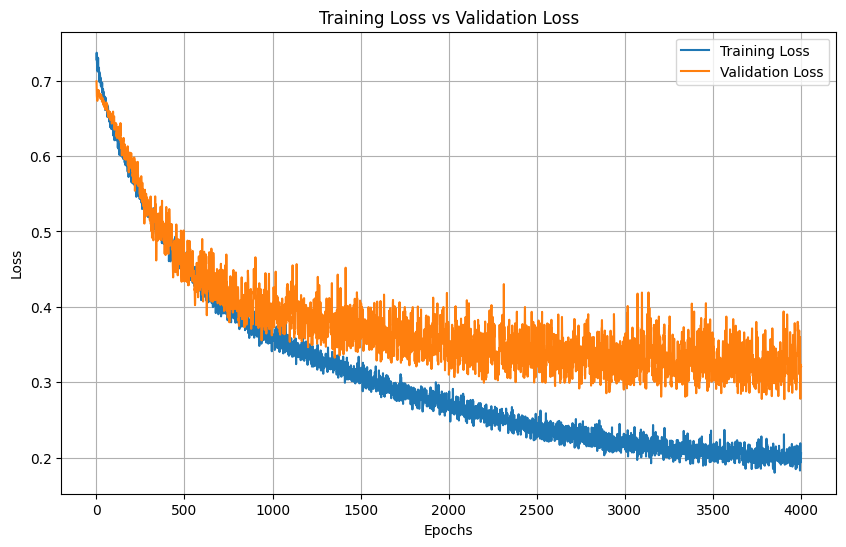

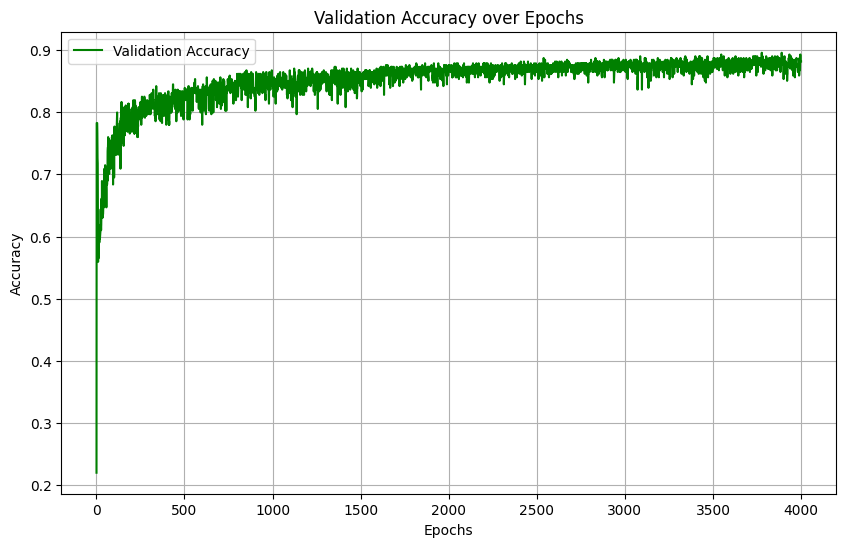

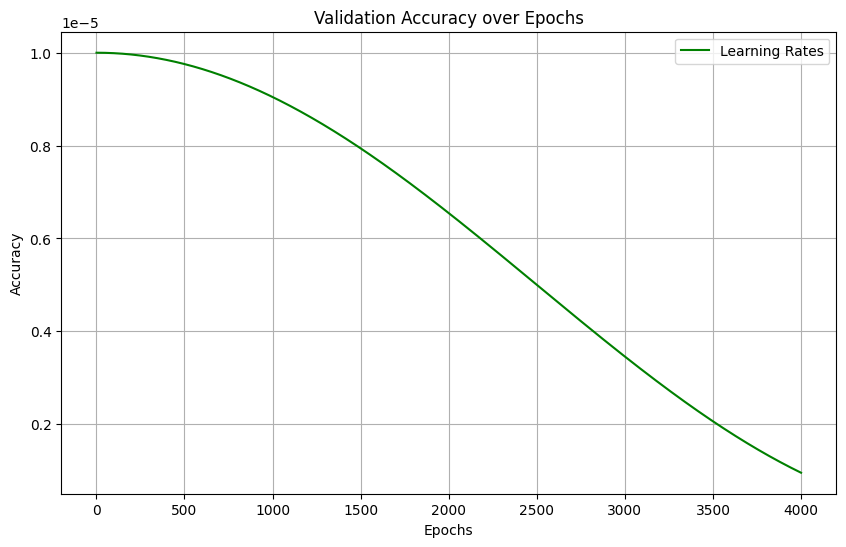

Model for bin 43 saved to GCNModels-5A_exp1/model_bin_43.pth
Training on bin 44/50
Bin 44, Epoch 1/4000, Train Loss: 0.6887, Validation Loss: 0.7058,  Accuracy: 0.2175, LR: 0.000010
Bin 44, Epoch 101/4000, Train Loss: 0.6126, Validation Loss: 0.6397,  Accuracy: 0.7514, LR: 0.000010
Bin 44, Epoch 201/4000, Train Loss: 0.5512, Validation Loss: 0.5603,  Accuracy: 0.8136, LR: 0.000010
Bin 44, Epoch 301/4000, Train Loss: 0.5056, Validation Loss: 0.5250,  Accuracy: 0.8164, LR: 0.000010
Bin 44, Epoch 401/4000, Train Loss: 0.4700, Validation Loss: 0.4673,  Accuracy: 0.8503, LR: 0.000010
Bin 44, Epoch 501/4000, Train Loss: 0.4369, Validation Loss: 0.4545,  Accuracy: 0.8531, LR: 0.000010
Bin 44, Epoch 601/4000, Train Loss: 0.4189, Validation Loss: 0.4049,  Accuracy: 0.8616, LR: 0.000010
Bin 44, Epoch 701/4000, Train Loss: 0.3923, Validation Loss: 0.4029,  Accuracy: 0.8644, LR: 0.000010
Bin 44, Epoch 801/4000, Train Loss: 0.3756, Validation Loss: 0.3651,  Accuracy: 0.8729, LR: 0.000009
Bin 44, Ep

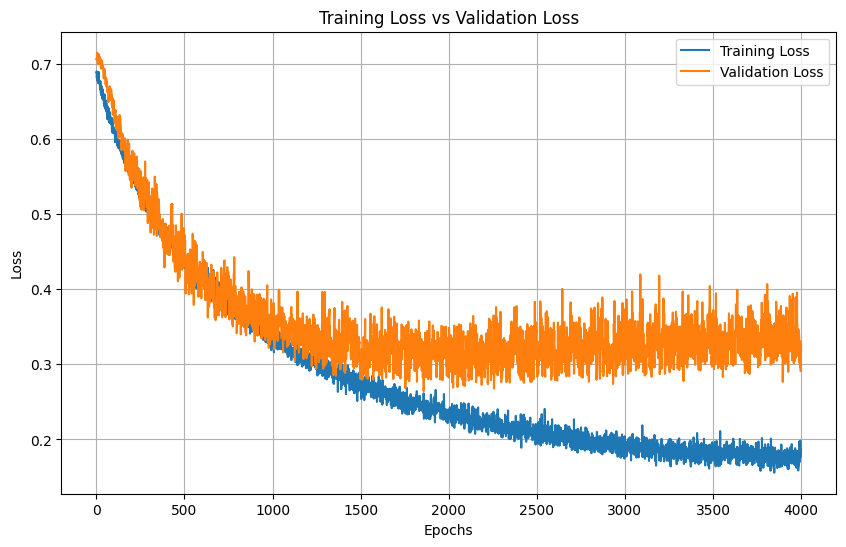

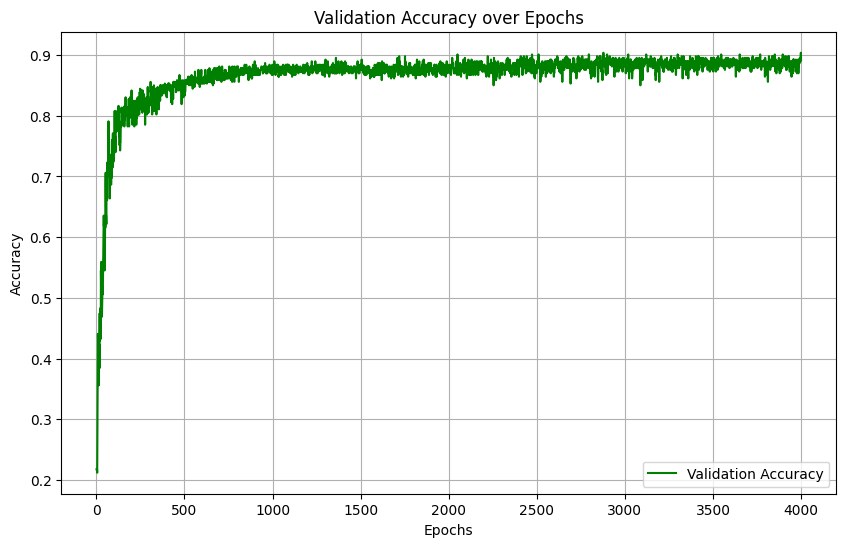

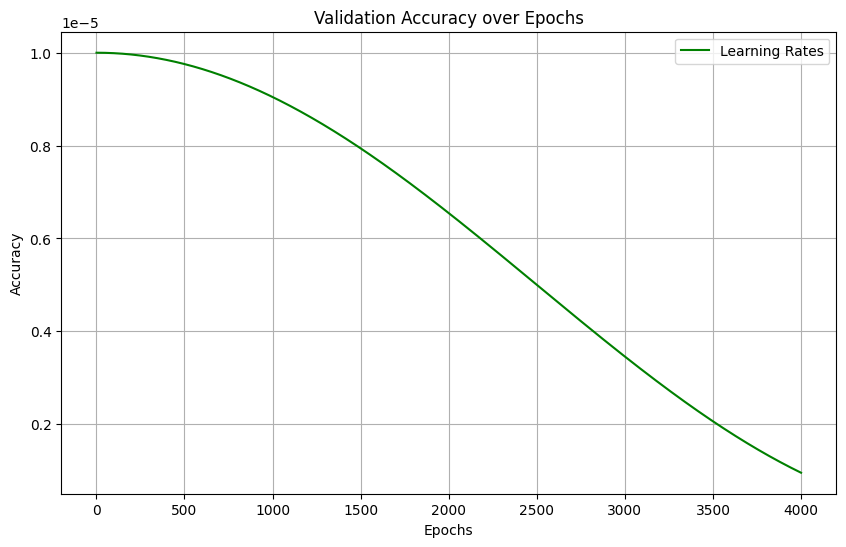

Model for bin 44 saved to GCNModels-5A_exp1/model_bin_44.pth
Training on bin 45/50
Bin 45, Epoch 1/4000, Train Loss: 0.6860, Validation Loss: 0.6850,  Accuracy: 0.7825, LR: 0.000010
Bin 45, Epoch 101/4000, Train Loss: 0.6005, Validation Loss: 0.6317,  Accuracy: 0.8277, LR: 0.000010
Bin 45, Epoch 201/4000, Train Loss: 0.5404, Validation Loss: 0.5879,  Accuracy: 0.8418, LR: 0.000010
Bin 45, Epoch 301/4000, Train Loss: 0.4684, Validation Loss: 0.5220,  Accuracy: 0.8588, LR: 0.000010
Bin 45, Epoch 401/4000, Train Loss: 0.4412, Validation Loss: 0.4896,  Accuracy: 0.8644, LR: 0.000010
Bin 45, Epoch 501/4000, Train Loss: 0.4020, Validation Loss: 0.4931,  Accuracy: 0.8672, LR: 0.000010
Bin 45, Epoch 601/4000, Train Loss: 0.3772, Validation Loss: 0.4552,  Accuracy: 0.8757, LR: 0.000010
Bin 45, Epoch 701/4000, Train Loss: 0.3487, Validation Loss: 0.4530,  Accuracy: 0.8757, LR: 0.000010
Bin 45, Epoch 801/4000, Train Loss: 0.3323, Validation Loss: 0.4509,  Accuracy: 0.8785, LR: 0.000009
Bin 45, Ep

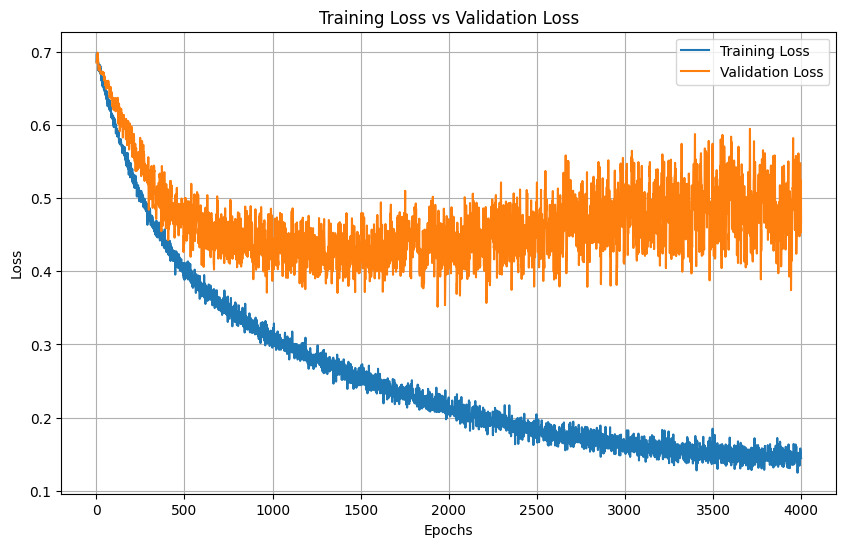

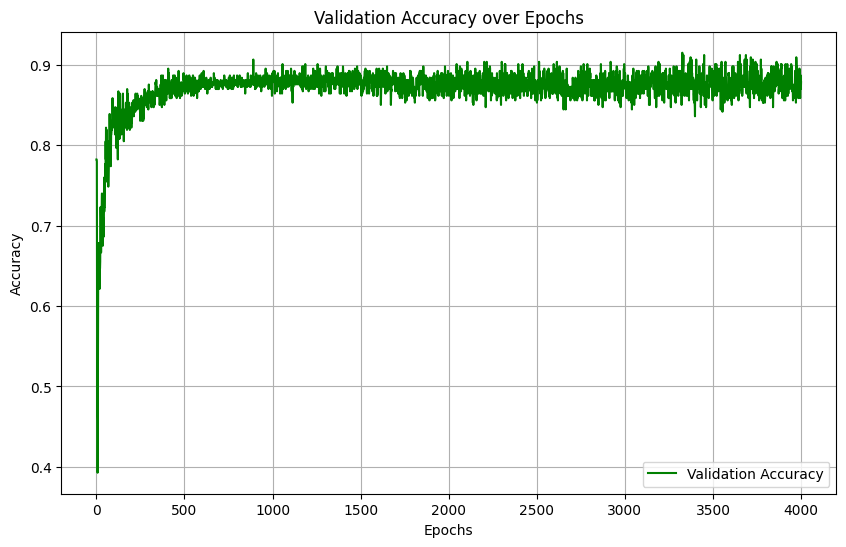

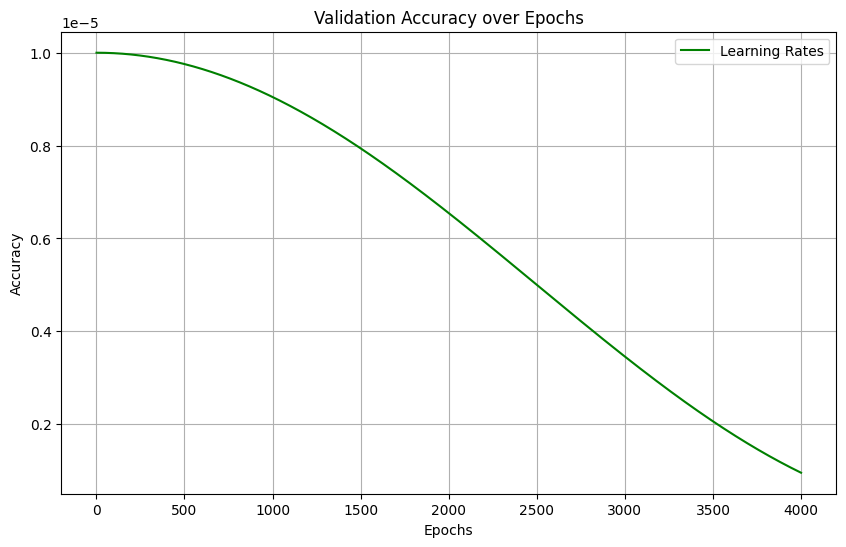

Model for bin 45 saved to GCNModels-5A_exp1/model_bin_45.pth
Training on bin 46/50
Bin 46, Epoch 1/4000, Train Loss: 0.7075, Validation Loss: 0.6699,  Accuracy: 0.7825, LR: 0.000010
Bin 46, Epoch 101/4000, Train Loss: 0.6233, Validation Loss: 0.6335,  Accuracy: 0.7910, LR: 0.000010
Bin 46, Epoch 201/4000, Train Loss: 0.5588, Validation Loss: 0.5709,  Accuracy: 0.8333, LR: 0.000010
Bin 46, Epoch 301/4000, Train Loss: 0.5038, Validation Loss: 0.4943,  Accuracy: 0.8446, LR: 0.000010
Bin 46, Epoch 401/4000, Train Loss: 0.4637, Validation Loss: 0.4150,  Accuracy: 0.8785, LR: 0.000010
Bin 46, Epoch 501/4000, Train Loss: 0.4241, Validation Loss: 0.3837,  Accuracy: 0.8644, LR: 0.000010
Bin 46, Epoch 601/4000, Train Loss: 0.4127, Validation Loss: 0.3750,  Accuracy: 0.8644, LR: 0.000010
Bin 46, Epoch 701/4000, Train Loss: 0.3981, Validation Loss: 0.3303,  Accuracy: 0.8729, LR: 0.000010
Bin 46, Epoch 801/4000, Train Loss: 0.3611, Validation Loss: 0.3556,  Accuracy: 0.8729, LR: 0.000009
Bin 46, Ep

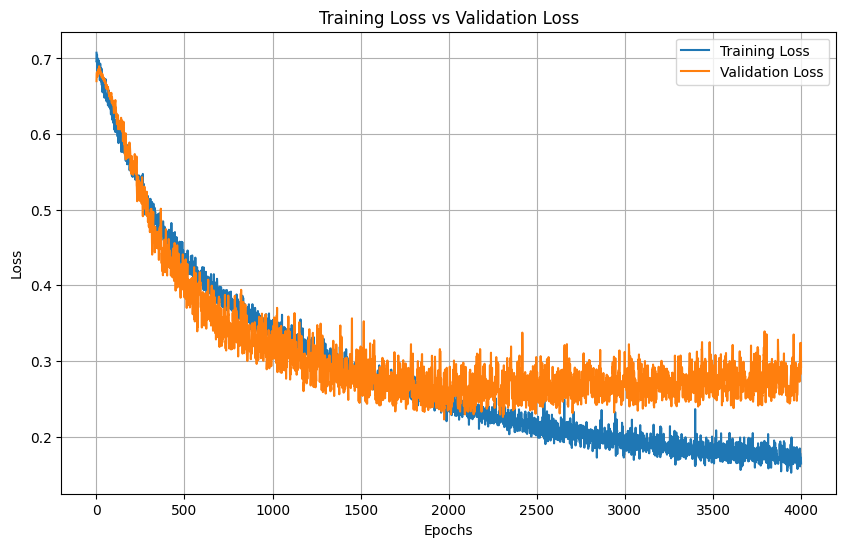

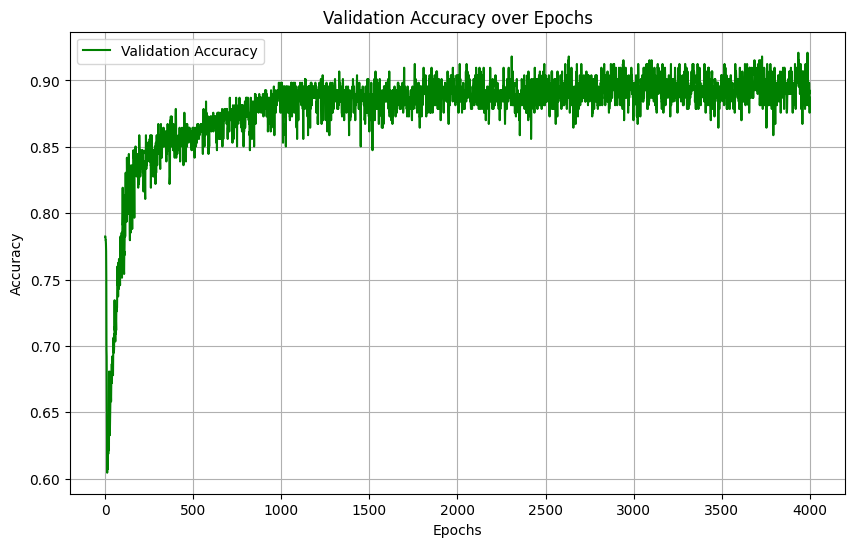

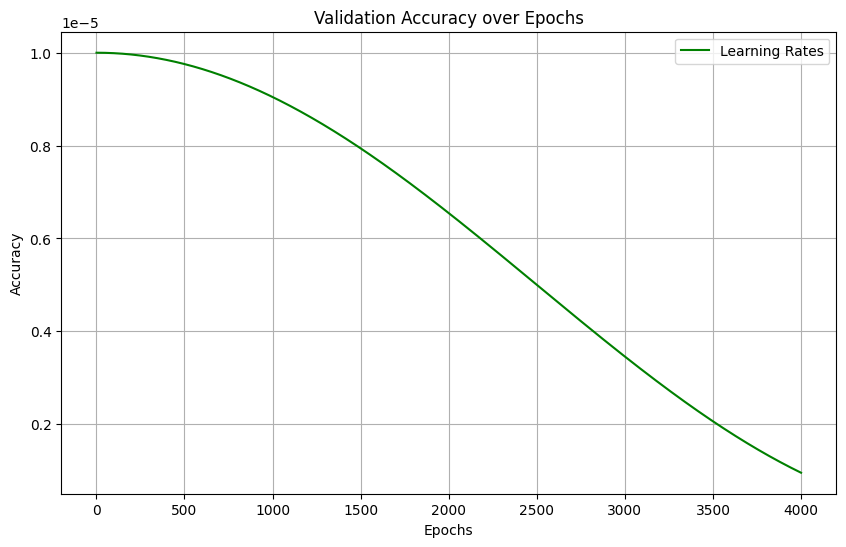

Model for bin 46 saved to GCNModels-5A_exp1/model_bin_46.pth
Training on bin 47/50
Bin 47, Epoch 1/4000, Train Loss: 0.7016, Validation Loss: 0.7271,  Accuracy: 0.2175, LR: 0.000010
Bin 47, Epoch 101/4000, Train Loss: 0.6509, Validation Loss: 0.6820,  Accuracy: 0.5678, LR: 0.000010
Bin 47, Epoch 201/4000, Train Loss: 0.6178, Validation Loss: 0.6247,  Accuracy: 0.7316, LR: 0.000010
Bin 47, Epoch 301/4000, Train Loss: 0.5828, Validation Loss: 0.5954,  Accuracy: 0.7429, LR: 0.000010
Bin 47, Epoch 401/4000, Train Loss: 0.5482, Validation Loss: 0.5253,  Accuracy: 0.7938, LR: 0.000010
Bin 47, Epoch 501/4000, Train Loss: 0.5224, Validation Loss: 0.4932,  Accuracy: 0.8107, LR: 0.000010
Bin 47, Epoch 601/4000, Train Loss: 0.4824, Validation Loss: 0.4747,  Accuracy: 0.8164, LR: 0.000010
Bin 47, Epoch 701/4000, Train Loss: 0.4627, Validation Loss: 0.4360,  Accuracy: 0.8333, LR: 0.000010
Bin 47, Epoch 801/4000, Train Loss: 0.4346, Validation Loss: 0.4130,  Accuracy: 0.8446, LR: 0.000009
Bin 47, Ep

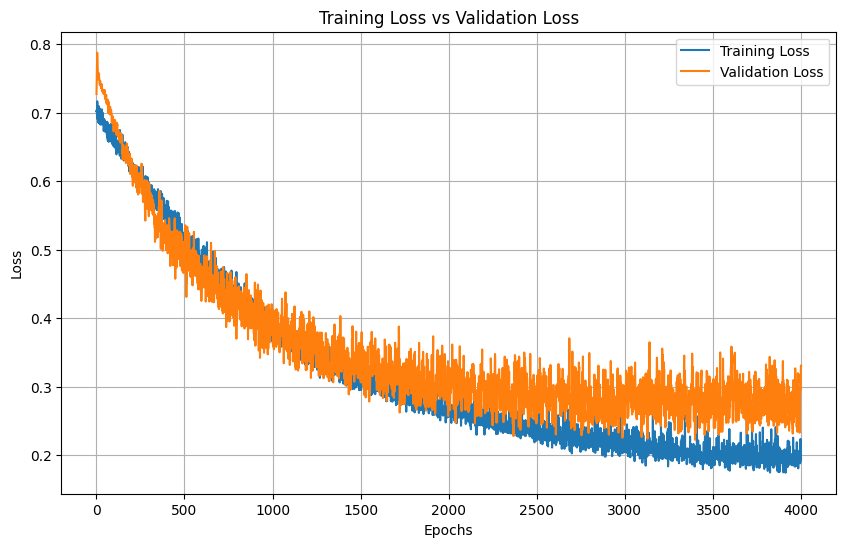

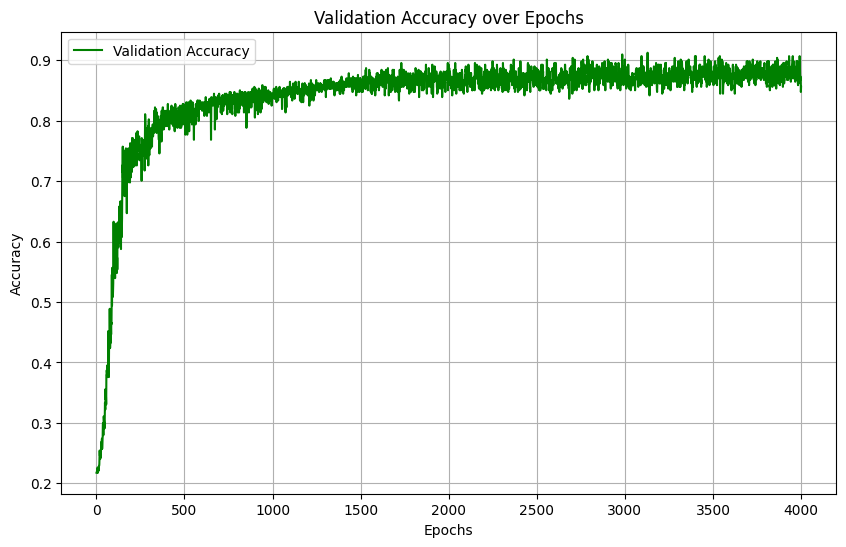

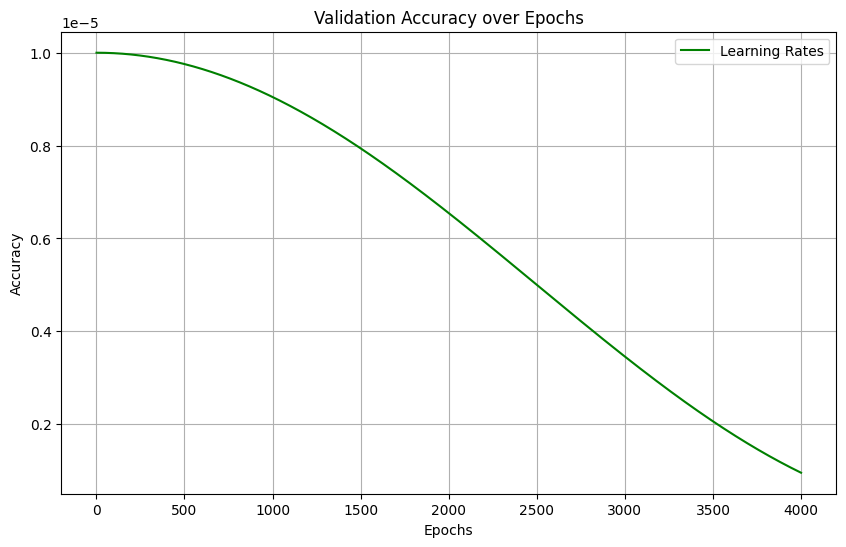

Model for bin 47 saved to GCNModels-5A_exp1/model_bin_47.pth
Training on bin 48/50
Bin 48, Epoch 1/4000, Train Loss: 0.7312, Validation Loss: 0.7014,  Accuracy: 0.2175, LR: 0.000010
Bin 48, Epoch 101/4000, Train Loss: 0.6452, Validation Loss: 0.6736,  Accuracy: 0.7429, LR: 0.000010
Bin 48, Epoch 201/4000, Train Loss: 0.6049, Validation Loss: 0.6146,  Accuracy: 0.7938, LR: 0.000010
Bin 48, Epoch 301/4000, Train Loss: 0.5347, Validation Loss: 0.5633,  Accuracy: 0.8107, LR: 0.000010
Bin 48, Epoch 401/4000, Train Loss: 0.5083, Validation Loss: 0.4823,  Accuracy: 0.8616, LR: 0.000010
Bin 48, Epoch 501/4000, Train Loss: 0.4934, Validation Loss: 0.4649,  Accuracy: 0.8503, LR: 0.000010
Bin 48, Epoch 601/4000, Train Loss: 0.4457, Validation Loss: 0.4158,  Accuracy: 0.8616, LR: 0.000010
Bin 48, Epoch 701/4000, Train Loss: 0.4201, Validation Loss: 0.4332,  Accuracy: 0.8333, LR: 0.000010
Bin 48, Epoch 801/4000, Train Loss: 0.4348, Validation Loss: 0.4289,  Accuracy: 0.8418, LR: 0.000009
Bin 48, Ep

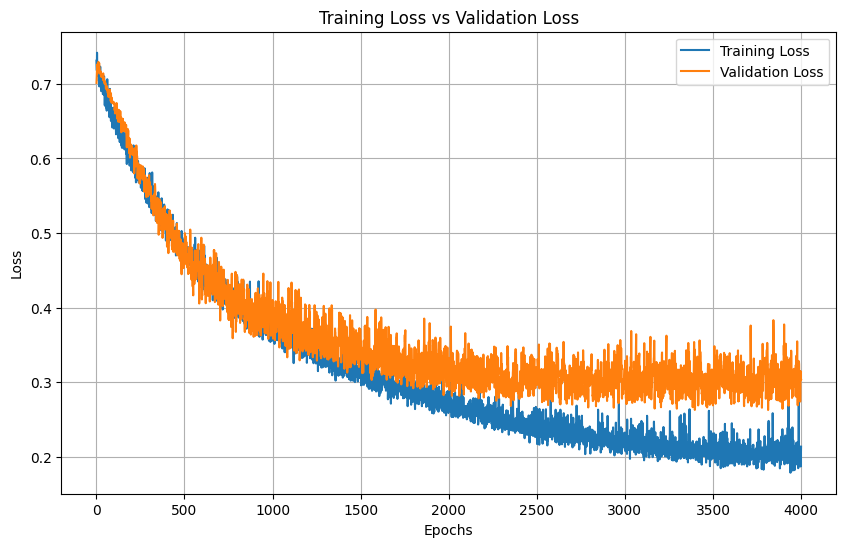

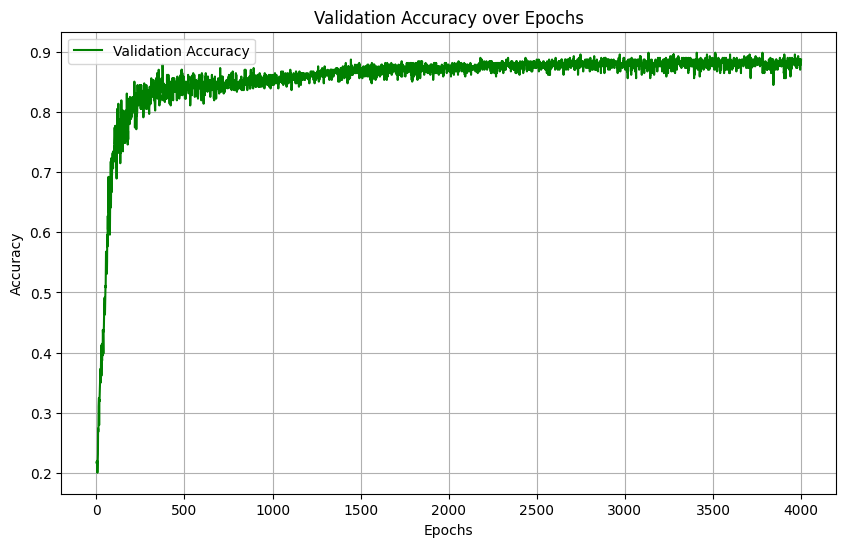

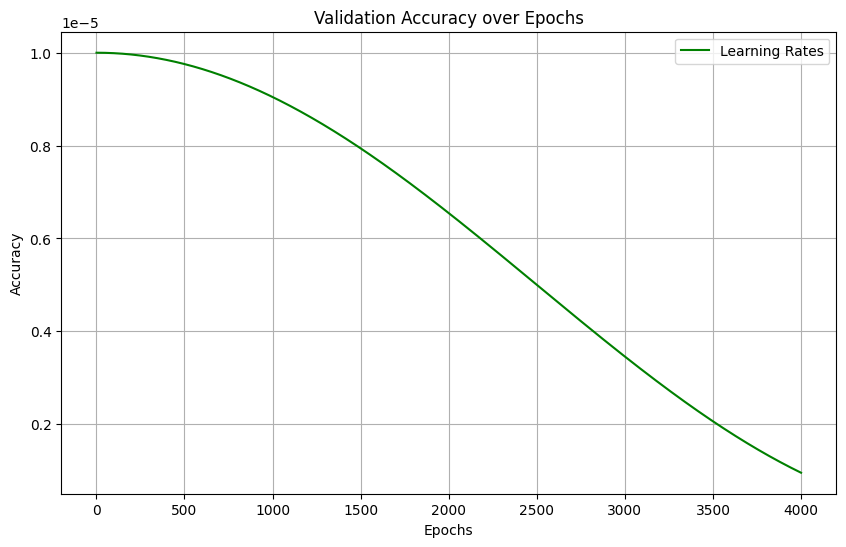

Model for bin 48 saved to GCNModels-5A_exp1/model_bin_48.pth
Training on bin 49/50
Bin 49, Epoch 1/4000, Train Loss: 0.7220, Validation Loss: 0.6965,  Accuracy: 0.2175, LR: 0.000010
Bin 49, Epoch 101/4000, Train Loss: 0.6475, Validation Loss: 0.6415,  Accuracy: 0.7514, LR: 0.000010
Bin 49, Epoch 201/4000, Train Loss: 0.6118, Validation Loss: 0.5887,  Accuracy: 0.8023, LR: 0.000010
Bin 49, Epoch 301/4000, Train Loss: 0.5728, Validation Loss: 0.5309,  Accuracy: 0.8362, LR: 0.000010
Bin 49, Epoch 401/4000, Train Loss: 0.5194, Validation Loss: 0.4662,  Accuracy: 0.8418, LR: 0.000010
Bin 49, Epoch 501/4000, Train Loss: 0.4992, Validation Loss: 0.4634,  Accuracy: 0.8362, LR: 0.000010
Bin 49, Epoch 601/4000, Train Loss: 0.4801, Validation Loss: 0.4876,  Accuracy: 0.8023, LR: 0.000010
Bin 49, Epoch 701/4000, Train Loss: 0.4598, Validation Loss: 0.4154,  Accuracy: 0.8446, LR: 0.000010
Bin 49, Epoch 801/4000, Train Loss: 0.4388, Validation Loss: 0.4420,  Accuracy: 0.8023, LR: 0.000009
Bin 49, Ep

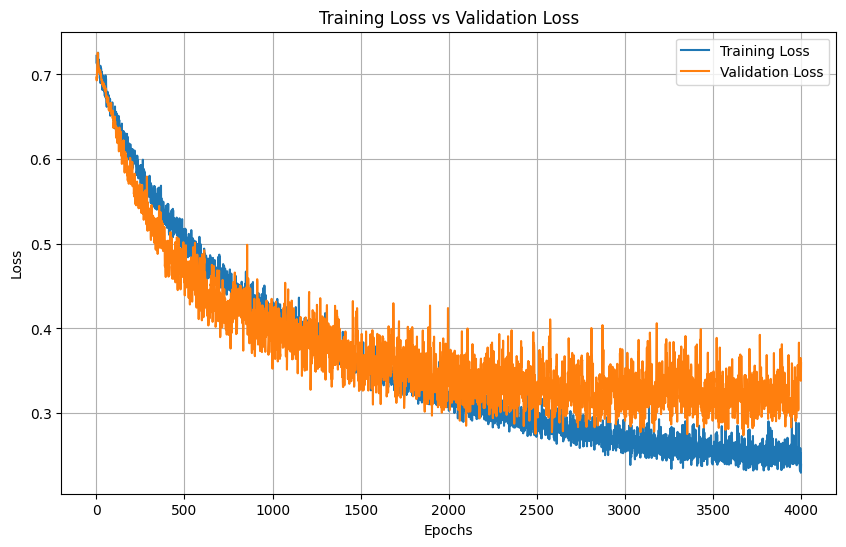

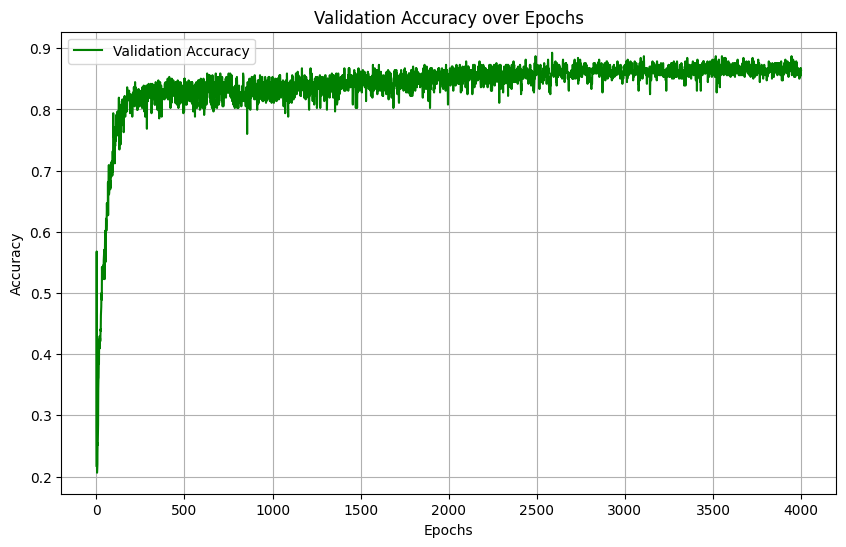

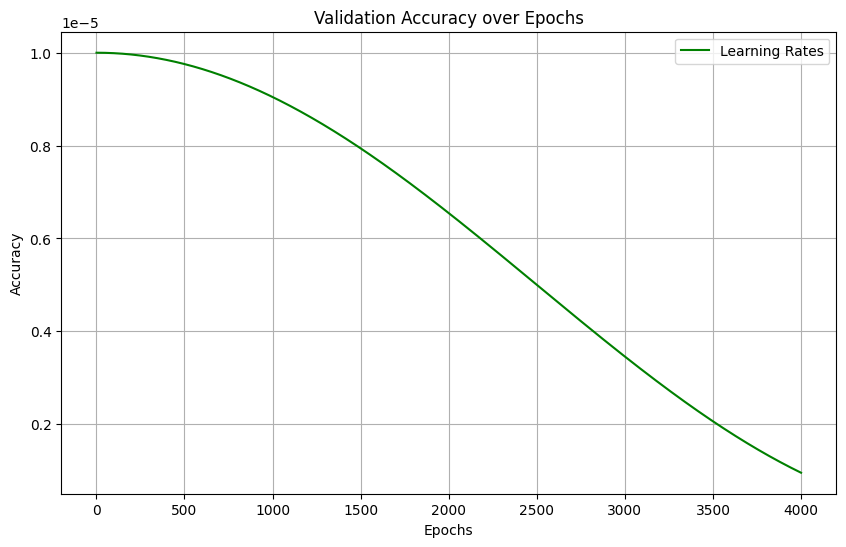

Model for bin 49 saved to GCNModels-5A_exp1/model_bin_49.pth
Training on bin 50/50
Bin 50, Epoch 1/4000, Train Loss: 0.7016, Validation Loss: 0.7009,  Accuracy: 0.2203, LR: 0.000010
Bin 50, Epoch 101/4000, Train Loss: 0.6288, Validation Loss: 0.6399,  Accuracy: 0.7571, LR: 0.000010
Bin 50, Epoch 201/4000, Train Loss: 0.5797, Validation Loss: 0.5755,  Accuracy: 0.8079, LR: 0.000010
Bin 50, Epoch 301/4000, Train Loss: 0.5222, Validation Loss: 0.5029,  Accuracy: 0.8333, LR: 0.000010
Bin 50, Epoch 401/4000, Train Loss: 0.4935, Validation Loss: 0.4206,  Accuracy: 0.8559, LR: 0.000010
Bin 50, Epoch 501/4000, Train Loss: 0.4410, Validation Loss: 0.4368,  Accuracy: 0.8362, LR: 0.000010
Bin 50, Epoch 601/4000, Train Loss: 0.4360, Validation Loss: 0.3745,  Accuracy: 0.8588, LR: 0.000010
Bin 50, Epoch 701/4000, Train Loss: 0.4151, Validation Loss: 0.3825,  Accuracy: 0.8559, LR: 0.000010
Bin 50, Epoch 801/4000, Train Loss: 0.3750, Validation Loss: 0.3414,  Accuracy: 0.8729, LR: 0.000009
Bin 50, Ep

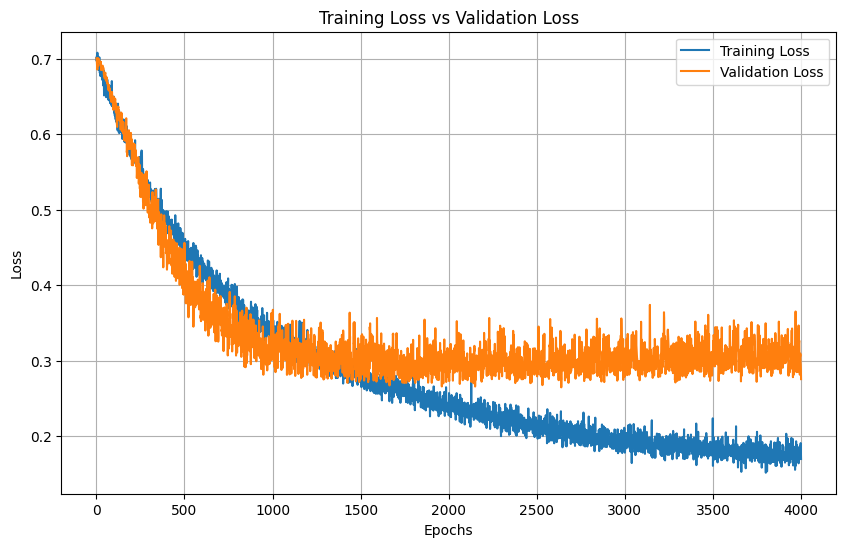

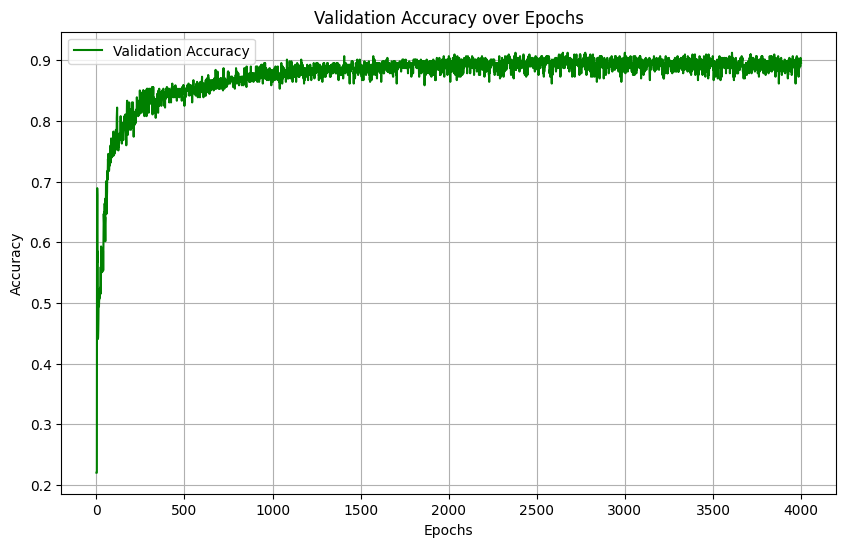

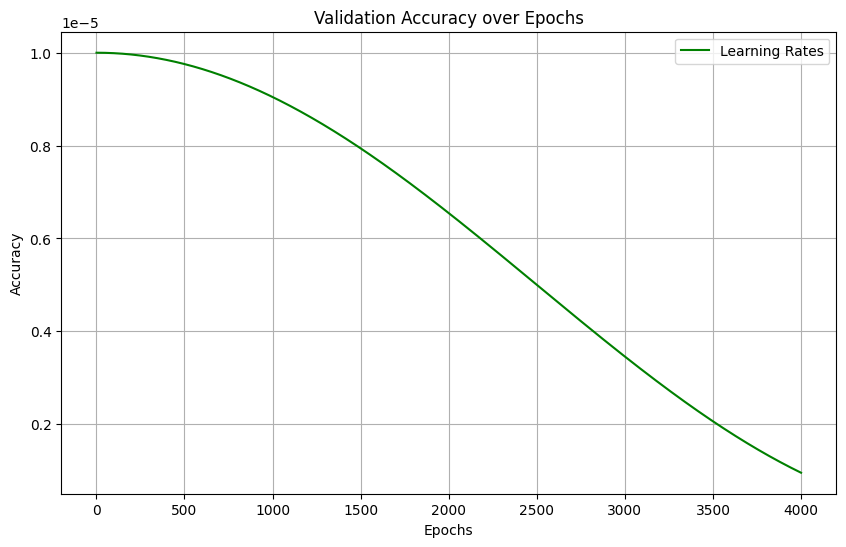

Model for bin 50 saved to GCNModels-5A_exp1/model_bin_50.pth
Training complete.


In [47]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GCNModels-5A_exp1"
os.makedirs(f"{save_dir}/Models", exist_ok=True)

# Training loop
epochs = 4000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = GCN(input_dim=37).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    train_loader = DataLoader(bins[i], batch_size=batch_size, shuffle=True)    

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

print("Training complete.")